# **IEEE Fraud Detection**

Avi Gutman 313288300

Liron Ohana 206764599

Sapir Elad 322612706

## Imports & Settings

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve

)
from imblearn.over_sampling import SMOTE
import joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)
from imblearn.over_sampling import SMOTE
import joblib

import xgboost as xgb
import lightgbm as lgb
import catboost as cb

import gdown
import cv2

# Visualization settings
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# Helper function: downcast numeric columns to reduce memory usage
def reduce_memory_usage(df):
    """
    Converts float64 -> float32 and int64 -> int32 to help reduce memory footprint.
    """
    for col in df.columns:
        col_type = df[col].dtype

        if col_type == 'float64':
            df[col] = df[col].astype('float32')
        elif col_type == 'int64':
            df[col] = df[col].astype('int32')
    return df

import gdown
import cv2

# Visualization settings
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# Helper function: downcast numeric columns to reduce memory usage
def reduce_memory_usage(df):
    """
    Converts float64 -> float32 and int64 -> int32 to help reduce memory footprint.
    """
    for col in df.columns:
        col_type = df[col].dtype

        if col_type == 'float64':
            df[col] = df[col].astype('float32')
        elif col_type == 'int64':
            df[col] = df[col].astype('int32')
    return df

<a id="introduction"></a>

## 1. Introduction

We are working with the IEEE Fraud Detection dataset, which contains these files:
- **train_transaction.csv**, **train_identity.csv** (training data)
- **test_transaction.csv**, **test_identity.csv** (test data)
- **sample_submission.csv** (Kaggle submission format)

---

<a id="section2"></a>

## 2. Load & Merge Data

We’ll load the transaction and identity files for both train and test sets, then merge on `TransactionID`. We’ll also load the sample submission for final output.


In [2]:
print("Loading training data...")

transaction_data = pd.read_csv('train_transaction.csv')
identity_data    = pd.read_csv('train_identity.csv')
merged_data = pd.merge(transaction_data, identity_data, on='TransactionID', how='left')

print(f"train_transaction shape: {transaction_data.shape}")
print(f"train_identity shape: {identity_data.shape}")
print(f"Merged train_df shape: {merged_data.shape}\n")

Loading training data...
train_transaction shape: (590540, 394)
train_identity shape: (144233, 41)
Merged train_df shape: (590540, 434)



In [3]:
merged_data.head(5)

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5  ...                id_31  id_32  \
0    NaN  150.0    discover  142.0  ...                  NaN    NaN   
1  404.0  150.0  mastercard  102.0  ...                  NaN    NaN   
2  490.0  150.0        visa  166.0  ...                  NaN    NaN   
3  567.0  150.0  mastercard  117.0  ...                  NaN    NaN   
4  514.0  150.0  mastercard  102.0  ...  samsung browser 6.2   32.0   

       id_33           id_34  id_35 id_36 id_37  id_38  DeviceType  \
0        NaN             NaN    NaN   NaN   NaN    NaN         NaN   
1        NaN             NaN    NaN   NaN   NaN    NaN         NaN   
2        NaN             NaN    NaN   NaN   NaN    NaN         NaN   
3        NaN             NaN    NaN   NaN   NaN    NaN         NaN   
4  2220x1080  match_status:2      T     F     T      T      mobile   

                      DeviceInfo  
0                            NaN  
1                            NaN  
2                            NaN  
3                            NaN  
4  SAMSUNG SM-G892A Build/NRD90M  

[5 rows x 434 columns]

In [4]:
print(f"Dataset shape: {merged_data.shape}")

Dataset shape: (590540, 434)


In [5]:
# pd.set_option('display.max_columns', None)
# merged_data.info()

In [6]:
print(merged_data.columns.tolist())

['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V

## EDA + Feature Engineering

### Info

In [7]:
def full_info(df):
    col_info = []
    for col in df.columns:
        total_rows = df.shape[0]
        non_null_count = df[col].notna().sum()
        null_count = total_rows - non_null_count  # Count of null values
        dtype = df[col].dtype
        unique_values = df[col].nunique()  # Number of unique values in the column

        col_info.append(f"{col}: {non_null_count} non-null, {null_count} null, {unique_values} unique, {dtype}")

    print("\n".join(col_info))

full_info(merged_data)

TransactionID: 590540 non-null, 0 null, 590540 unique, int64
isFraud: 590540 non-null, 0 null, 2 unique, int64
TransactionDT: 590540 non-null, 0 null, 573349 unique, int64
TransactionAmt: 590540 non-null, 0 null, 20902 unique, float64
ProductCD: 590540 non-null, 0 null, 5 unique, object
card1: 590540 non-null, 0 null, 13553 unique, int64
card2: 581607 non-null, 8933 null, 500 unique, float64
card3: 588975 non-null, 1565 null, 114 unique, float64
card4: 588963 non-null, 1577 null, 4 unique, object
card5: 586281 non-null, 4259 null, 119 unique, float64
card6: 588969 non-null, 1571 null, 4 unique, object
addr1: 524834 non-null, 65706 null, 332 unique, float64
addr2: 524834 non-null, 65706 null, 74 unique, float64
dist1: 238269 non-null, 352271 null, 2651 unique, float64
dist2: 37627 non-null, 552913 null, 1751 unique, float64
P_emaildomain: 496084 non-null, 94456 null, 59 unique, object
R_emaildomain: 137291 non-null, 453249 null, 60 unique, object
C1: 590540 non-null, 0 null, 1657 unique

In [8]:
nan_percentage = merged_data.isna().mean() * 100

nan_percentage_df = (
    pd.DataFrame({
        "Column": nan_percentage.index,
        "NaN Percentage": nan_percentage.values
    })
    .query("`NaN Percentage` > 80")  # Filter for columns with more than 80% NaNs
    .sort_values(by="NaN Percentage", ascending=False).reset_index(drop=True)
    .reset_index(drop=True)
)

nan_percentage_df

Column  NaN Percentage
0   id_24       99.196159
1   id_25       99.130965
2   id_07       99.127070
3   id_08       99.127070
4   id_21       99.126393
..    ...             ...
69   V333       86.054967
70   V334       86.054967
71   V336       86.054967
72   V337       86.054967
73   V322       86.054967

[74 rows x 2 columns]

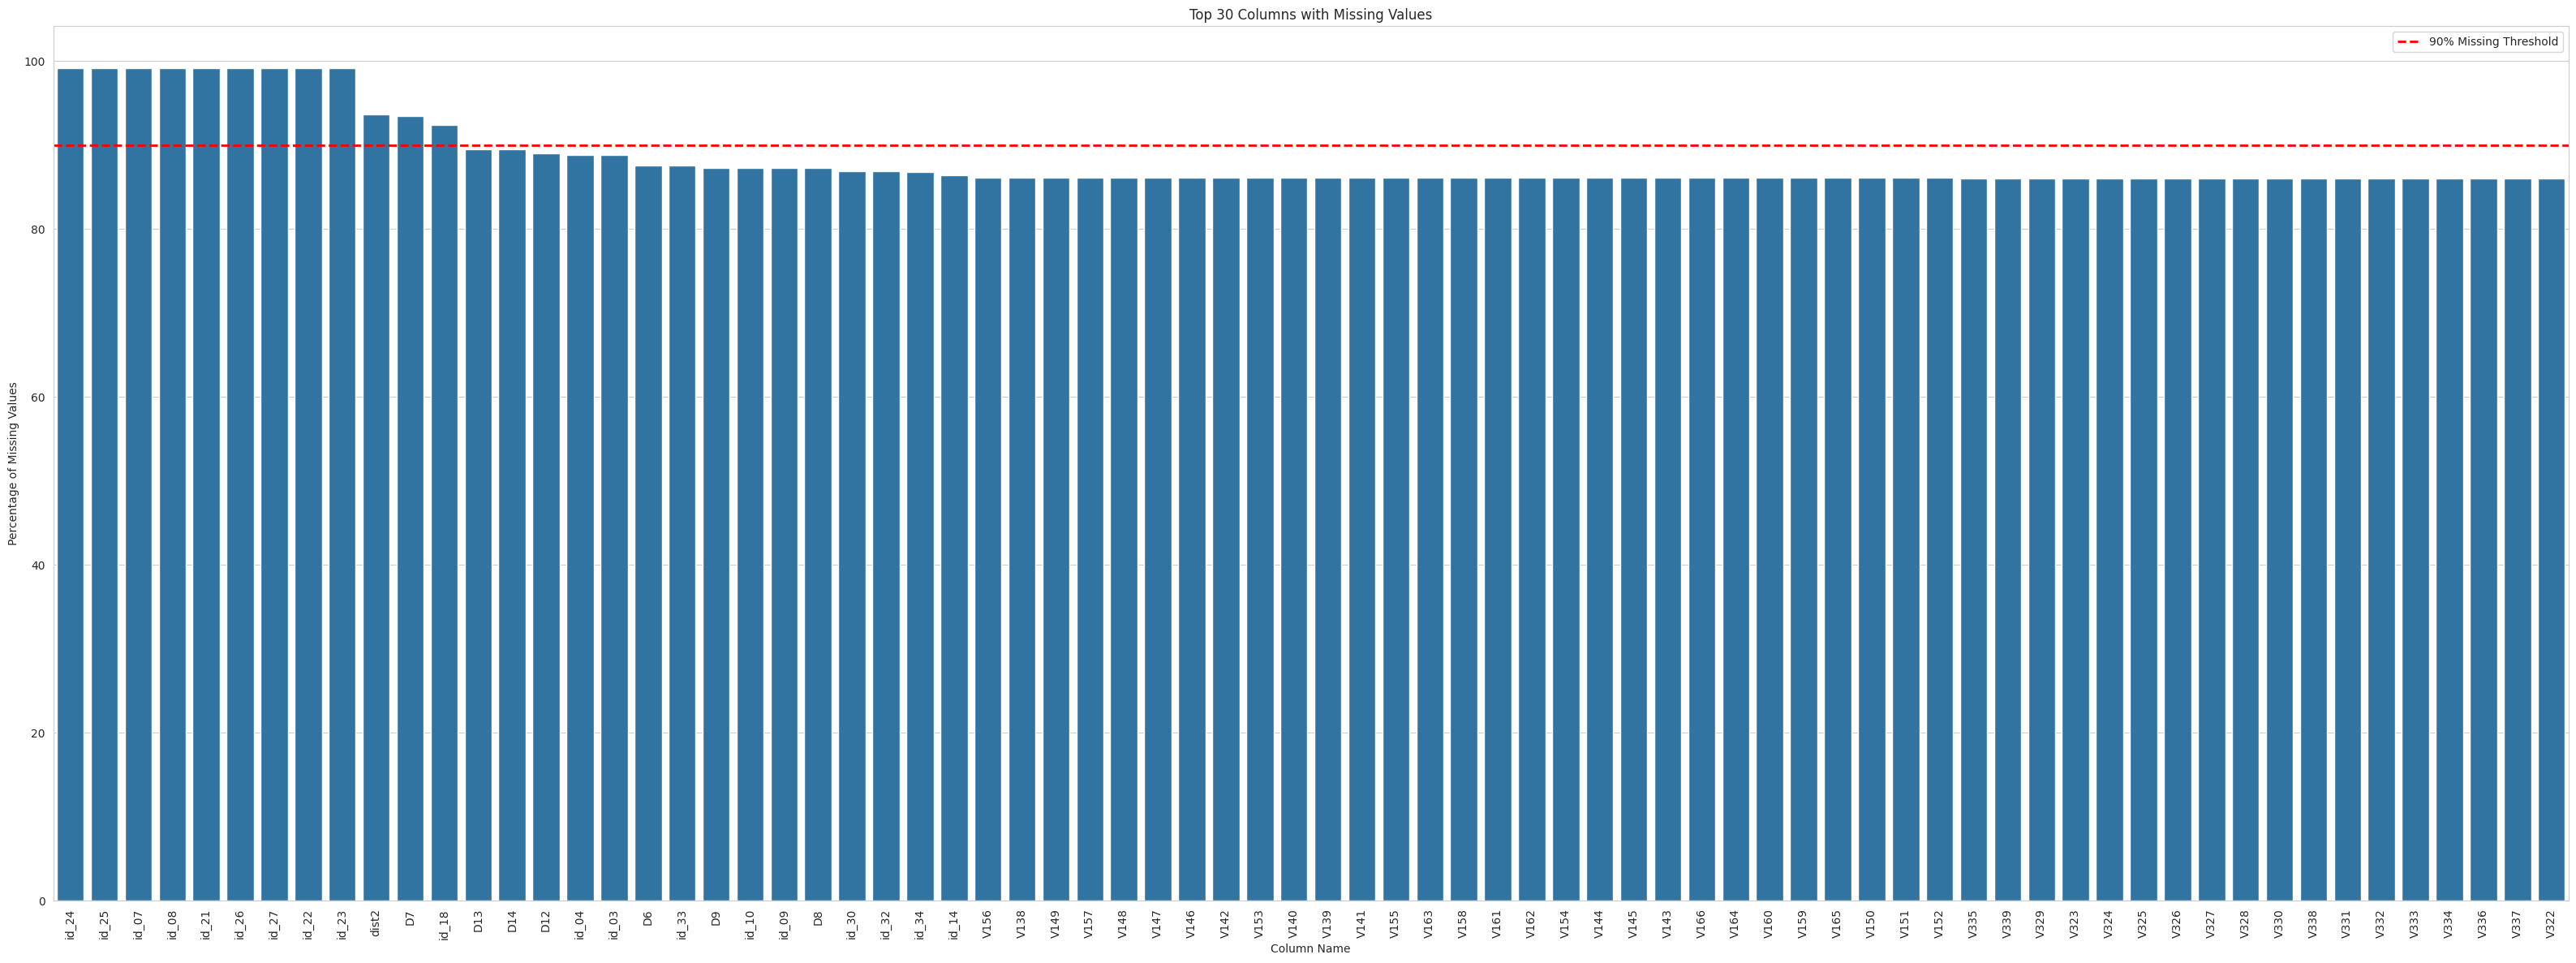

In [9]:
plt.figure(figsize=(40, 14))
sns.barplot(x=nan_percentage_df["Column"][:], y=nan_percentage_df["NaN Percentage"][:])
plt.xticks(rotation=90)
plt.xlabel("Column Name")
plt.ylabel("Percentage of Missing Values")
plt.title("Top 30 Columns with Missing Values")

plt.axhline(90, color='red', linestyle='--', linewidth=2, label="90% Missing Threshold")

plt.legend()

plt.show()

Need to drop some of the columns. After the EDA.

### Is_Fraud


    isFraud   Count  Percentage
0        0  569877   96.500999
1        1   20663    3.499001 



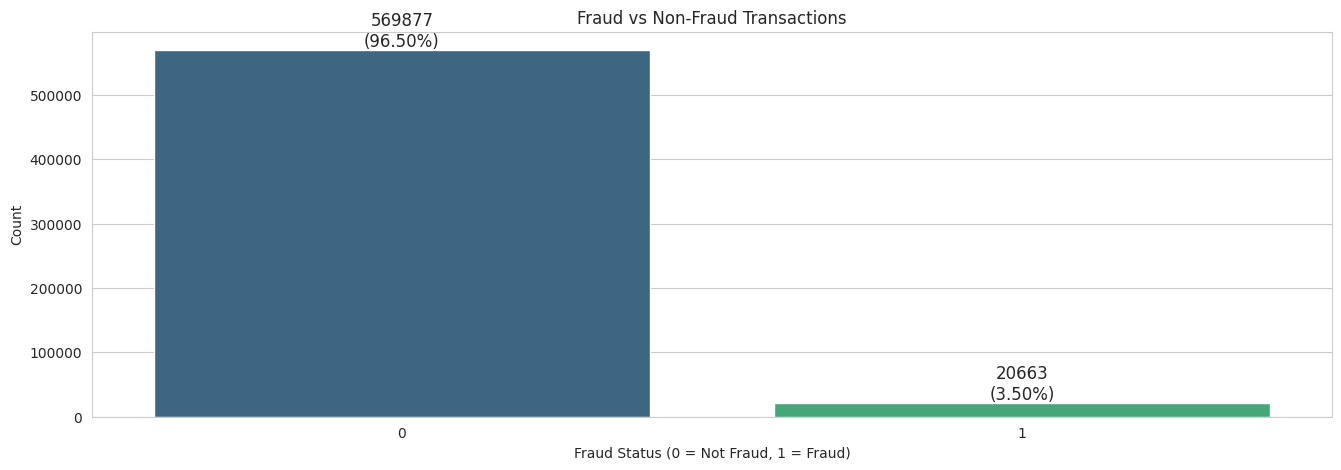

In [10]:
col_name = "isFraud"

counts = merged_data[col_name].value_counts(dropna=False)
normalized_counts = merged_data[col_name].value_counts(dropna=False, normalize=True)

result = pd.DataFrame({
    col_name: counts.index,
    "Count": counts.values,
    "Percentage": normalized_counts.values * 100
})

print("\n",result,"\n")


plt.figure(figsize=(16, 5))

ax = sns.countplot(x=merged_data["isFraud"], hue=merged_data["isFraud"], palette="viridis", legend=False)

total = len(merged_data["isFraud"])

for p in ax.patches:
    count = int(p.get_height())
    percentage = f"{100 * count / total:.2f}%"

    ax.text(p.get_x() + p.get_width()/2, p.get_height(), f'{count}\n({percentage})',
            ha='center', va='bottom', fontsize=12)

plt.xlabel("Fraud Status (0 = Not Fraud, 1 = Fraud)")
plt.ylabel("Count")
plt.title("Fraud vs Non-Fraud Transactions")

plt.show()

#### Observations
- We can see that most of the data is not fraud, and its make sense because most of transactions in real-life are valid.

### TransactionDT

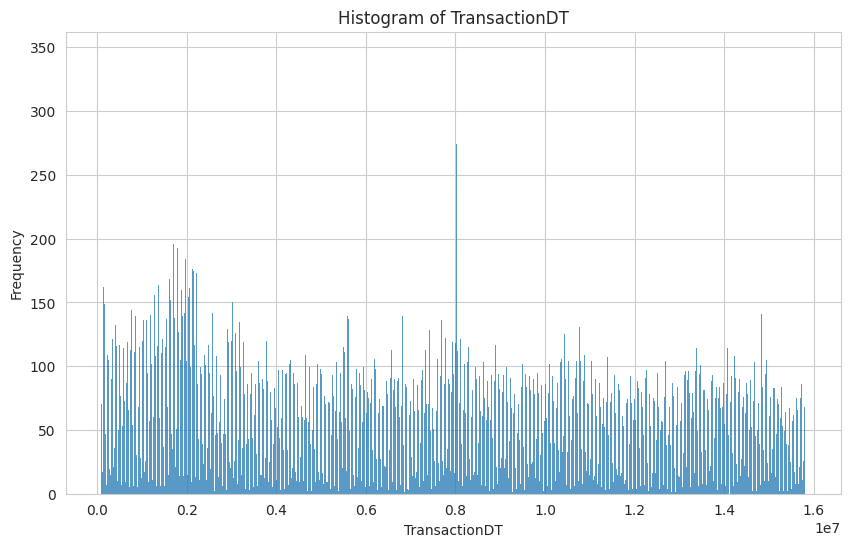

In [11]:
col_name = "TransactionDT"

counts = merged_data[col_name].value_counts(dropna=False)
normalized_counts = merged_data[col_name].value_counts(dropna=False, normalize=True)


sns.histplot(merged_data[col_name], bins=10000, kde=False)
plt.xlabel(col_name,rotation=0)
plt.ylabel("Frequency")
plt.title(f"Histogram of {col_name}")
plt.show()

This is a time delta, and the numbers are huge!

We found that it's the time delta in seconds. Let's check it out:

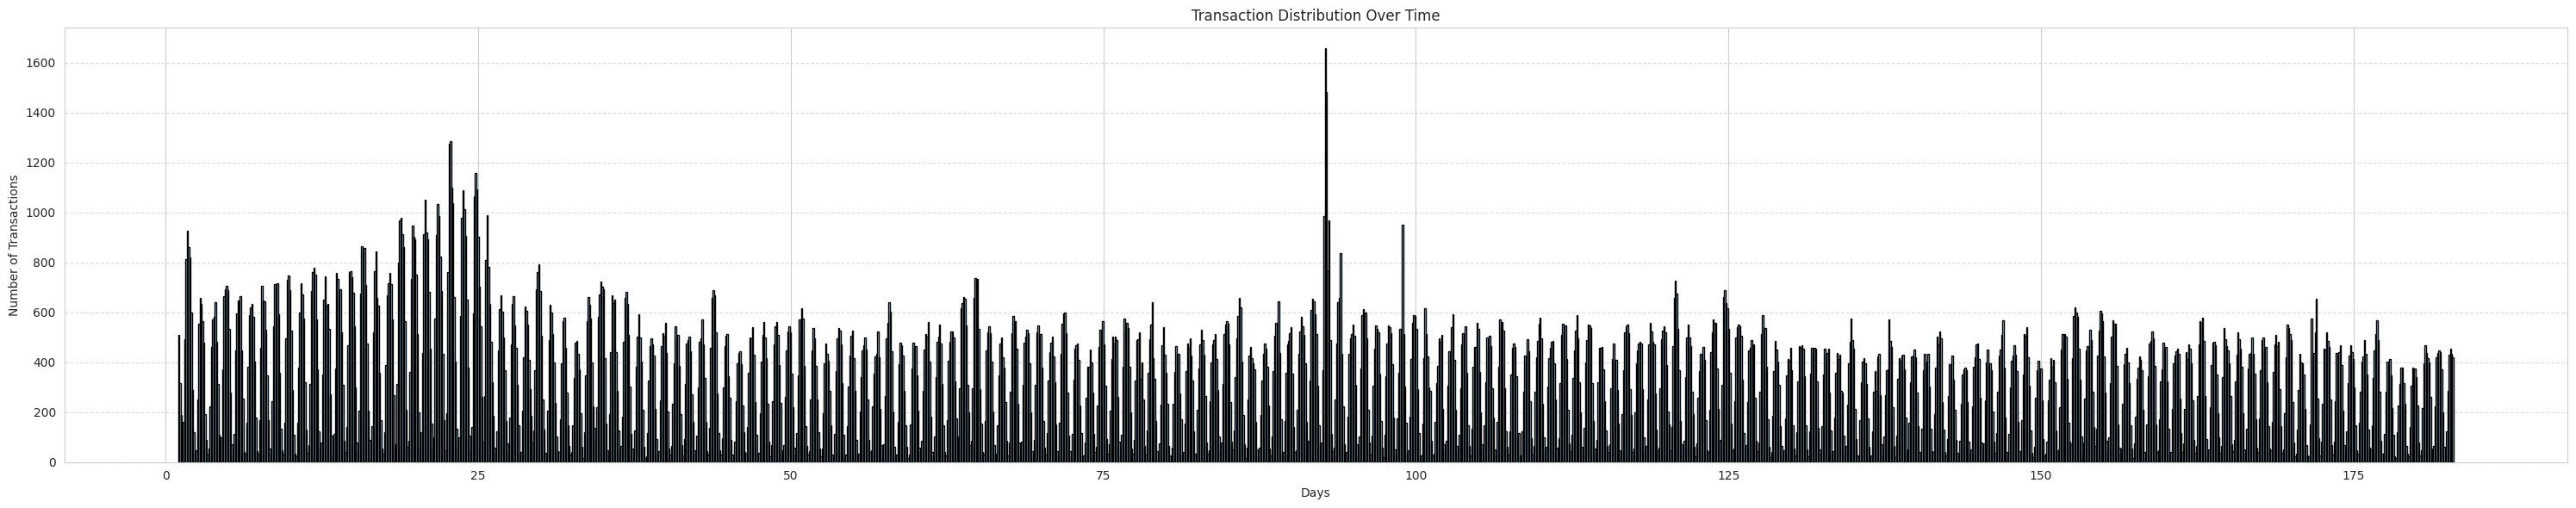

In [12]:
plt.figure(figsize=(30, 6))
vals = plt.hist(merged_data['TransactionDT'] / (3600*24), bins=1800, color='skyblue', edgecolor='black')

plt.xlabel('Days')
plt.ylabel('Number of Transactions')
plt.title('Transaction Distribution Over Time')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Zoom in a bit:

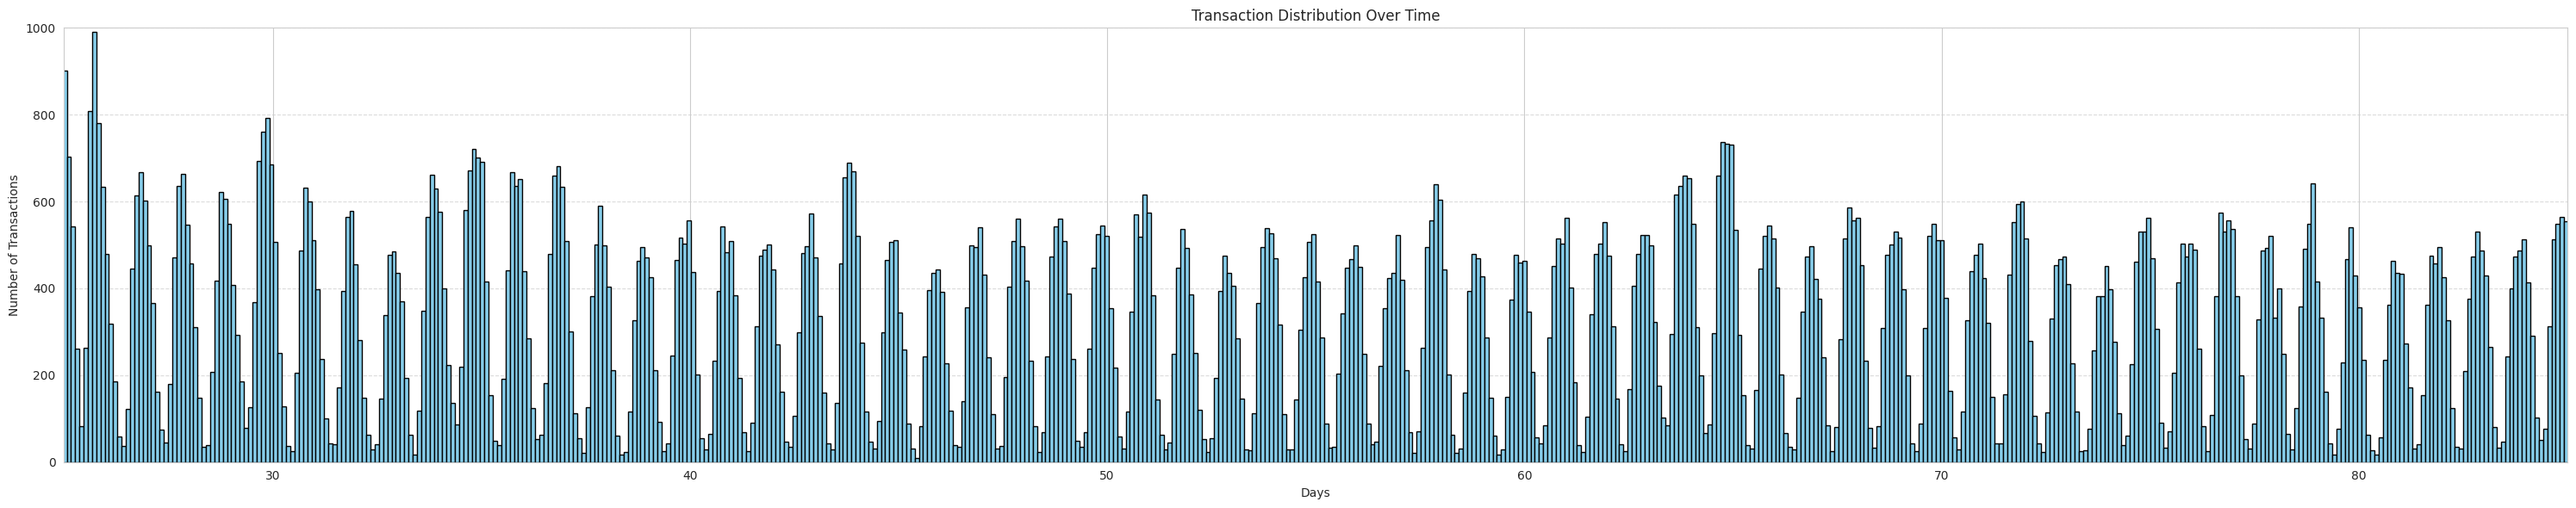

In [13]:
plt.figure(figsize=(30, 6))
vals = plt.hist(merged_data['TransactionDT'] / (3600*24), bins=1800, color='skyblue', edgecolor='black')
plt.xlim(25, 85)
plt.ylim(0, 1000)
plt.xlabel('Days')
plt.ylabel('Number of Transactions')
plt.title('Transaction Distribution Over Time')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

We can clearly understand that this are a days.

Assuming the delta started at 00:00 :

(Even if it's not - it will not disrupt the model.)

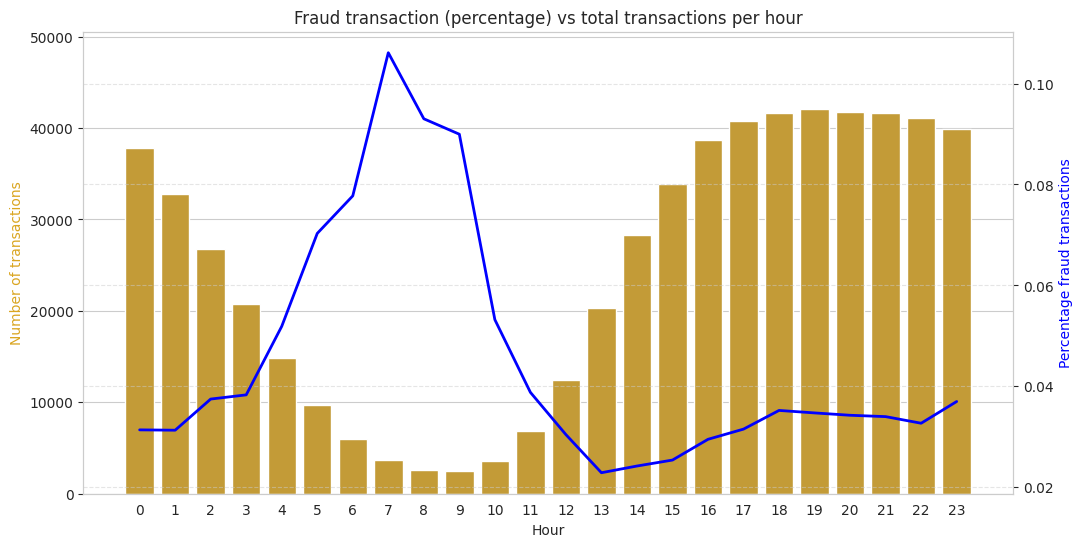

In [14]:
merged_data['Transaction_Hour'] = (merged_data['TransactionDT'] // 3600) % 24

hourly_stats = merged_data.groupby('Transaction_Hour').agg(
    fraud_percentage=('isFraud', lambda x: x.mean()),
    total_transactions=('isFraud', 'count')
).reset_index()

fig, ax1 = plt.subplots(figsize=(12, 6))

sns.barplot(x='Transaction_Hour', y='total_transactions', data=hourly_stats,
            color='goldenrod', ax=ax1)
ax1.set_ylabel("Number of transactions", color='goldenrod')
ax1.set_xlabel("Hour")
ax1.set_ylim(0, hourly_stats['total_transactions'].max() * 1.2)

ax2 = ax1.twinx()
ax2.plot(hourly_stats['Transaction_Hour'], hourly_stats['fraud_percentage'],
         color='blue', linewidth=2)
ax2.set_ylabel("Percentage fraud transactions", color='blue')

plt.title("Fraud transaction (percentage) vs total transactions per hour")
plt.grid(True, linestyle="--", alpha=0.5)

plt.show()


Looks interesting. 7 AM is for more prime time for fraudulent transactions. It may be a good predictor.

I want it without importance to the number itself, so I'll convert it to string, and will encode it later:

In [15]:
merged_data["Transaction_Hour"] = merged_data["Transaction_Hour"].astype(str)

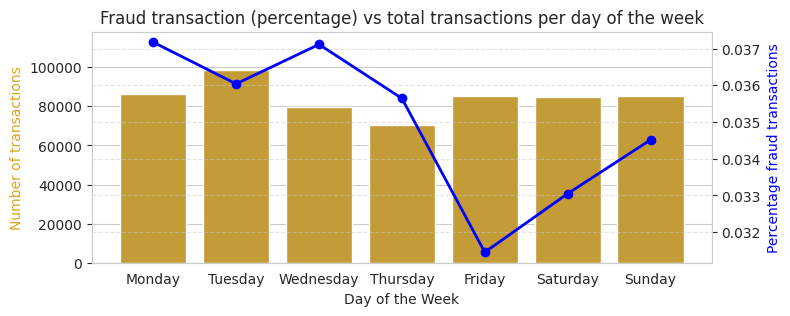

In [16]:
merged_data['Transaction_Weekday'] = ((merged_data['TransactionDT'] // (24*3600)) % 7).astype(int)

day_mapping = {
    0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday",
    4: "Friday", 5: "Saturday", 6: "Sunday"
}
merged_data['Transaction_Weekday'] = merged_data['Transaction_Weekday'].map(day_mapping)

weekday_stats = merged_data.groupby('Transaction_Weekday').agg(
    fraud_percentage=('isFraud', lambda x: x.mean()),
    total_transactions=('isFraud', 'count')
).reset_index()

weekday_stats['Transaction_Weekday'] = pd.Categorical(
    weekday_stats['Transaction_Weekday'],
    categories=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"],
    ordered=True
)
weekday_stats = weekday_stats.sort_values("Transaction_Weekday")

fig, ax1 = plt.subplots(figsize=(8, 3))

sns.barplot(x='Transaction_Weekday', y='total_transactions', data=weekday_stats,
            color='goldenrod', ax=ax1)
ax1.set_ylabel("Number of transactions", color='goldenrod')
ax1.set_xlabel("Day of the Week")
ax1.set_ylim(0, weekday_stats['total_transactions'].max() * 1.2)

ax2 = ax1.twinx()
ax2.plot(weekday_stats['Transaction_Weekday'], weekday_stats['fraud_percentage'],
         color='blue', linewidth=2, marker='o')
ax2.set_ylabel("Percentage fraud transactions", color='blue')

plt.title("Fraud transaction (percentage) vs total transactions per day of the week")
plt.grid(True, linestyle="--", alpha=0.5)

plt.show()

Less informative. we will let the model choose if this feature is important.

### TransactionAmt

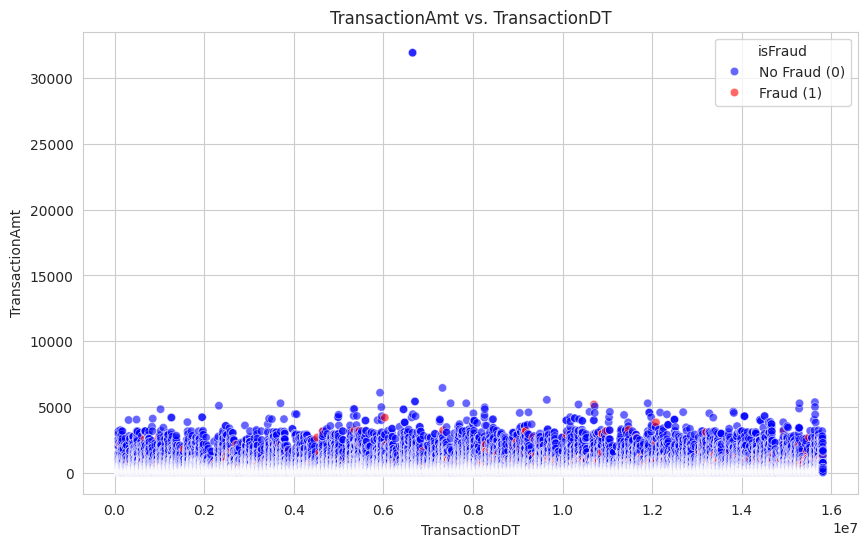

In [17]:
scatter_plot = sns.scatterplot(x=merged_data["TransactionDT"],
                               y=merged_data["TransactionAmt"],
                               hue=merged_data["isFraud"],
                               palette={0: "blue", 1: "red"},  # Blue for isFraud = 0, Red for isFraud = 1
                               alpha=0.6)  # Adjust transparency for better visibility

plt.xlabel("TransactionDT")
plt.ylabel("TransactionAmt")
plt.title("TransactionAmt vs. TransactionDT")

handles, labels = scatter_plot.get_legend_handles_labels()
scatter_plot.legend(handles=handles, labels=["No Fraud (0)", "Fraud (1)"], title="isFraud")

plt.show()

let's make a box-plot to find out if the highest point is a outlier

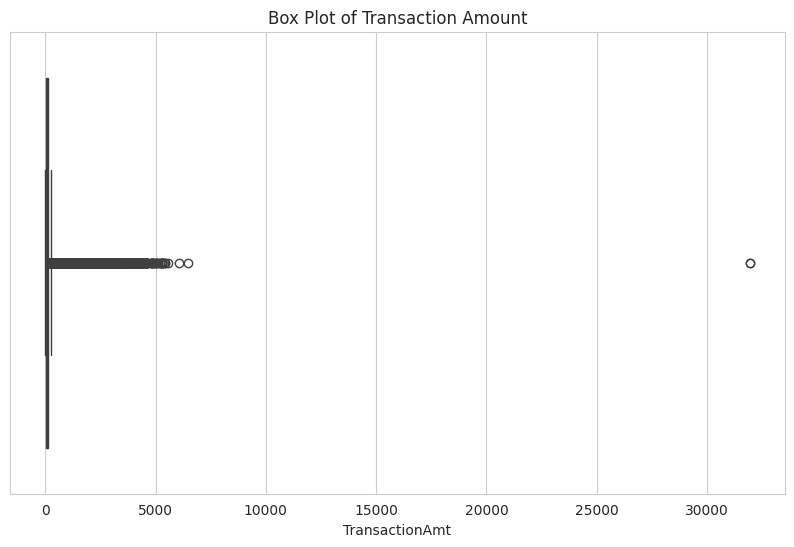

In [18]:
sns.boxplot(x=merged_data["TransactionAmt"])

plt.xlabel("TransactionAmt")
plt.title("Box Plot of Transaction Amount")
plt.show()

we'll remove this outlier.

In [19]:
merged_data = merged_data[merged_data['TransactionAmt'] <= 10000]

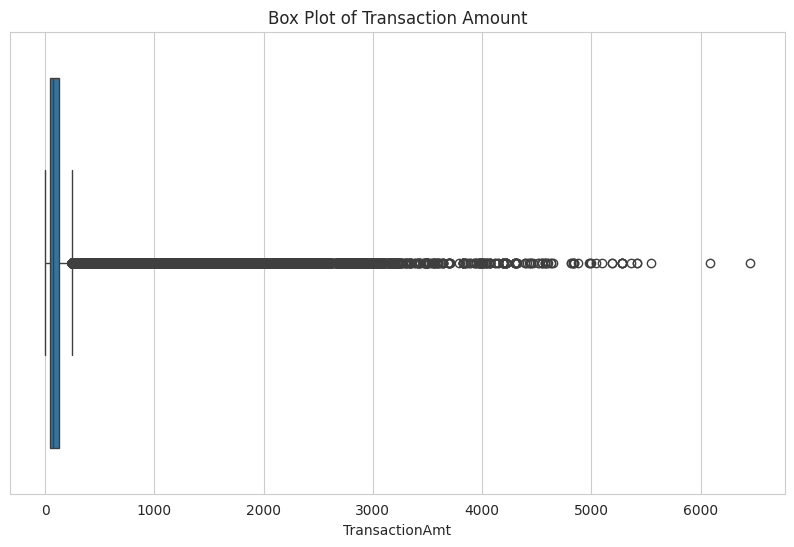

In [20]:
sns.boxplot(x=merged_data["TransactionAmt"])

plt.xlabel("TransactionAmt")
plt.title("Box Plot of Transaction Amount")
plt.show()

About this outliers - we will choose how to handle them in the next section

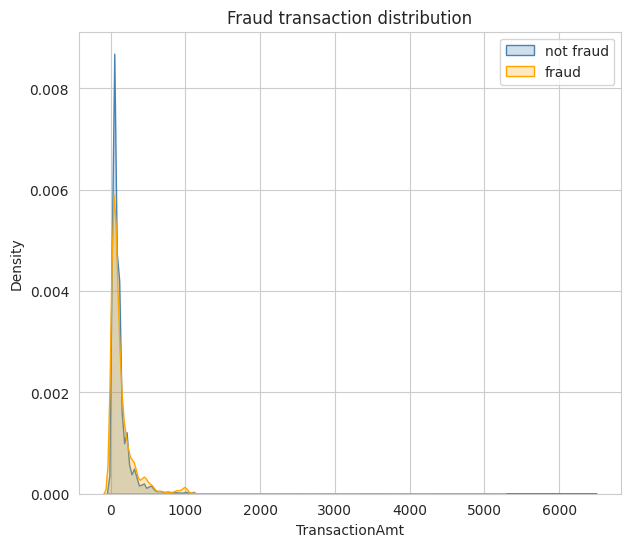

In [21]:
sns.set_style("whitegrid")

plt.figure(figsize=(7, 6))

sns.kdeplot(
    data=merged_data[merged_data["isFraud"] == 0], x="TransactionAmt",
    label="not fraud", color="steelblue", fill=True
)
sns.kdeplot(
    data=merged_data[merged_data["isFraud"] == 1], x="TransactionAmt",
    label="fraud", color="orange", fill=True
)

plt.title("Fraud transaction distribution")
plt.xlabel("TransactionAmt")
plt.ylabel("Density")
plt.legend()

plt.show()

Not so informative. we will try to manipulate it:

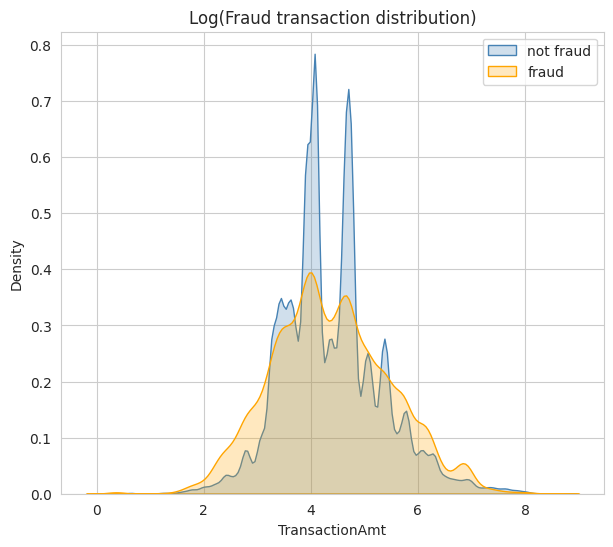

In [22]:
sns.set_style("whitegrid")

merged_data["LogTransactionAmt"] = np.log1p(merged_data["TransactionAmt"])

plt.figure(figsize=(7, 6))

sns.kdeplot(
    data=merged_data[merged_data["isFraud"] == 0], x="LogTransactionAmt",
    label="not fraud", color="steelblue", fill=True
)
sns.kdeplot(
    data=merged_data[merged_data["isFraud"] == 1], x="LogTransactionAmt",
    label="fraud", color="orange", fill=True
)

plt.title("Log(Fraud transaction distribution)")
plt.xlabel("TransactionAmt")
plt.ylabel("Density")
plt.legend()

plt.show()

Both fraud and non-fraud transactions peak at similar values, suggesting a high density of small transactions.

There seems to be a higher frequency and probability density of fraud in transactions with a LogTransactionAmt greater than 5.5 (244 dollars) and less than 3.3 (27 dollars).
However, those with the 'LogTransactionAmt' between 3.3 and 5.5 have a greater likelihood of being legitimate.

Also, there are whole amounts and there are non-whole amounts. We will create a new feature for each type, and see if this has an impact on our target variable:

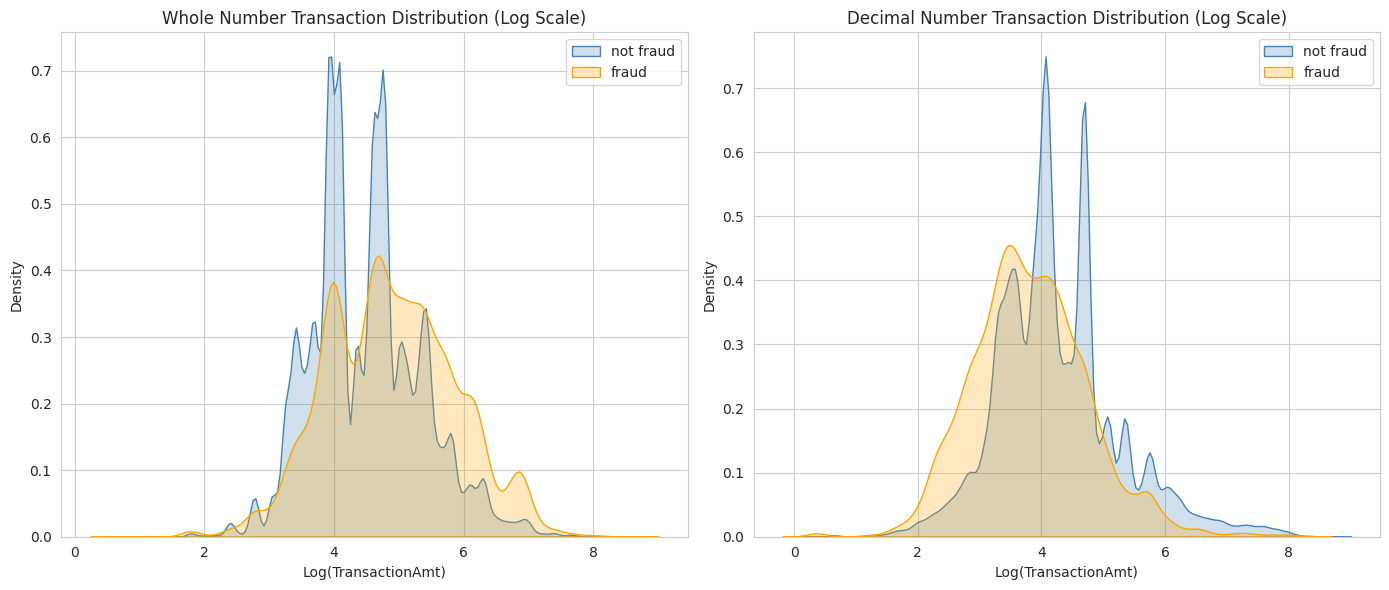

In [23]:
merged_data["AmountType"] = merged_data["TransactionAmt"].apply(lambda x: "Whole" if x.is_integer() else "Decimal")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.kdeplot(
    data=merged_data[(merged_data["AmountType"] == "Whole") & (merged_data["isFraud"] == 0)],
    x="LogTransactionAmt", label="not fraud", ax=axes[0], color="steelblue", fill=True
)
sns.kdeplot(
    data=merged_data[(merged_data["AmountType"] == "Whole") & (merged_data["isFraud"] == 1)],
    x="LogTransactionAmt", label="fraud", ax=axes[0], color="orange", fill=True
)
axes[0].set_title("Whole Number Transaction Distribution (Log Scale)")
axes[0].set_xlabel("Log(TransactionAmt)")
axes[0].set_ylabel("Density")
axes[0].legend()

sns.kdeplot(
    data=merged_data[(merged_data["AmountType"] == "Decimal") & (merged_data["isFraud"] == 0)],
    x="LogTransactionAmt", label="not fraud", ax=axes[1], color="steelblue", fill=True
)
sns.kdeplot(
    data=merged_data[(merged_data["AmountType"] == "Decimal") & (merged_data["isFraud"] == 1)],
    x="LogTransactionAmt", label="fraud", ax=axes[1], color="orange", fill=True
)
axes[1].set_title("Decimal Number Transaction Distribution (Log Scale)")
axes[1].set_xlabel("Log(TransactionAmt)")
axes[1].set_ylabel("Density")
axes[1].legend()

plt.tight_layout()
plt.show()

It can be noted that there is indeed a difference.
For whole amounts there is a greater probability density of being fraudulent when it comes to high amounts.
On the other hand, for non-whole amounts, there is a greater probability density of being fraudulent when it comes to low amounts.

### ProductCD

<ipython-input-24-3201ab10eeb3>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=axes[0], data=merged_data, x='ProductCD', order=product_order, palette=palette_dict)
<ipython-input-24-3201ab10eeb3>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[1], x=fraud_percent.index, y=fraud_percent.values, palette=[palette_dict[p] for p in fraud_percent.index])


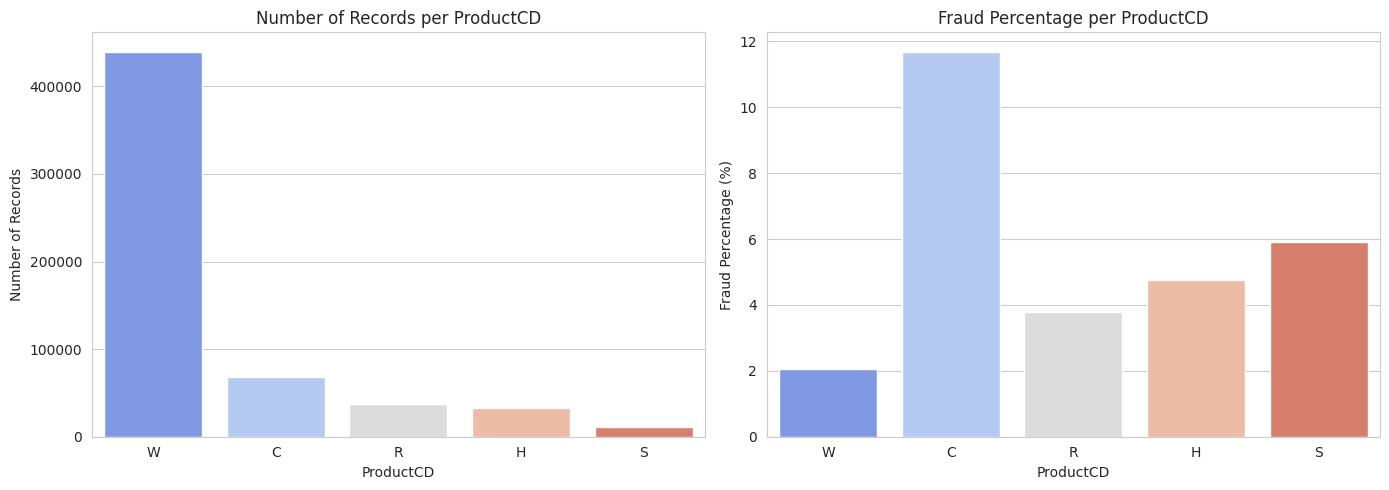

In [24]:
product_order = merged_data['ProductCD'].value_counts().index

unique_products = product_order.tolist()
palette_dict = dict(zip(unique_products, sns.color_palette("coolwarm", len(unique_products))))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # 1 row, 2 columns

sns.countplot(ax=axes[0], data=merged_data, x='ProductCD', order=product_order, palette=palette_dict)
axes[0].set_xlabel('ProductCD')
axes[0].set_ylabel('Number of Records')
axes[0].set_title('Number of Records per ProductCD')

fraud_percent = merged_data.groupby('ProductCD')['isFraud'].mean().loc[product_order] * 100  # Ensure same order

sns.barplot(ax=axes[1], x=fraud_percent.index, y=fraud_percent.values, palette=[palette_dict[p] for p in fraud_percent.index])
axes[1].set_xlabel('ProductCD')
axes[1].set_ylabel('Fraud Percentage (%)')
axes[1].set_title('Fraud Percentage per ProductCD')

plt.tight_layout()
plt.show()

It can be seen that for 'ProductCD' = C there are almost 12% frauds.

Followed by S with about 6%, which is the rarest category of all transactions.

### D's

We have D columns from D1 to D15.

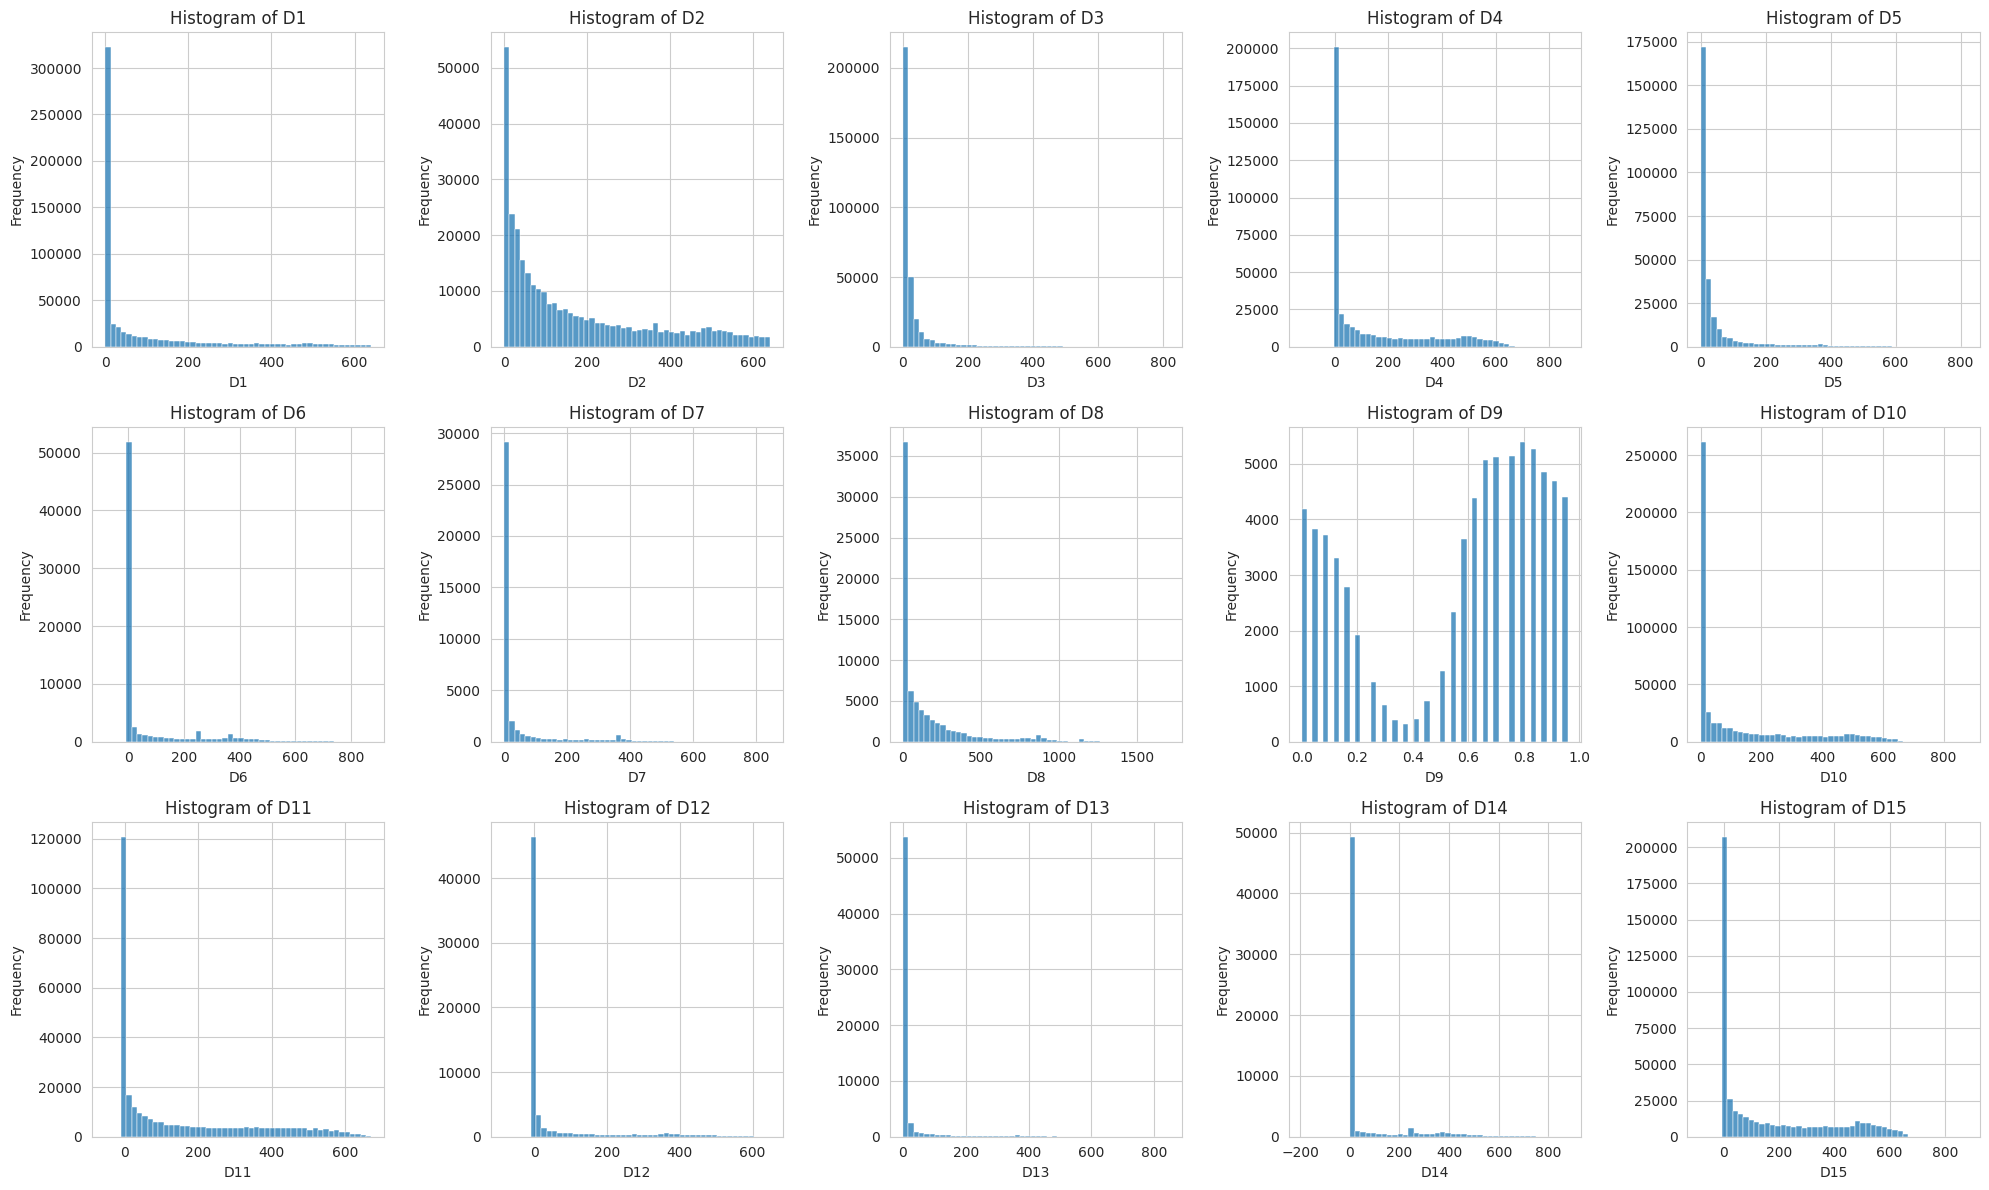

In [25]:
d_columns = [f'D{i}' for i in range(1, 16) ]#if i != 7]

n_cols = 5
n_rows = (len(d_columns) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 4))
axes = axes.flatten()

for i, col_name in enumerate(d_columns):
    sns.histplot(merged_data[col_name], bins=50, kde=False, ax=axes[i])
    axes[i].set_xlabel(col_name, rotation=0)
    axes[i].set_ylabel("Frequency")
    axes[i].set_title(f"Histogram of {col_name}")

for j in range(len(d_columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

we guess the D columns are days delta.

In [26]:
# #d_columns = [f'D{i}' for i in range(1, 16) ]#if i != 7]

# fig, axes = plt.subplots(len(d_columns), 1, figsize=(8, len(d_columns) * 5))

# if len(d_columns) == 1:
#     axes = [axes]

# for ax, col in zip(axes, d_columns):
#     ax.scatter(merged_data['TransactionDT'] / np.float32(24 * 60 * 60), merged_data[col], alpha=0.5)
#     ax.set_xlabel('TransactionDT - Days')
#     ax.set_ylabel(col)
#     ax.set_title(f'Scatter Plot of {col} vs TransactionDT - Days')

# plt.tight_layout()
# plt.show()

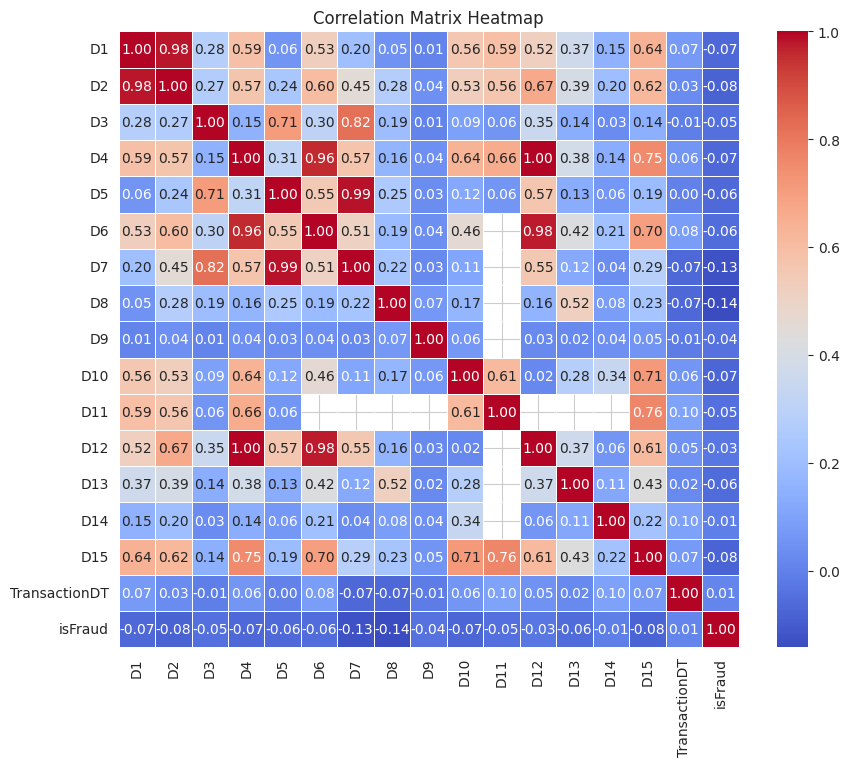

In [27]:
columns = [f"D{i}" for i in range(1, 16)] + ["TransactionDT"] + ["isFraud"]

correlation_matrix = merged_data[columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)

plt.title("Correlation Matrix Heatmap")
plt.show()

D11 have no values when D6, D7, D8, D9, D12, D13, D14 have values.

There are some high correlations.

No correlation with the Target variable.

Let's normalize those columns according to what we found about 'TransactionDT'.

We will normalize these time intervals so that they will be recalculated from the point in time of transaction execution.

In [28]:
d_columns = [f'D{i}' for i in range(1, 16) ]#if i != 7]

for col in d_columns:
    normalized_col = f'{col}new'
    merged_data[normalized_col] = merged_data[col] - merged_data['TransactionDT'] / np.float32(24 * 60 * 60)

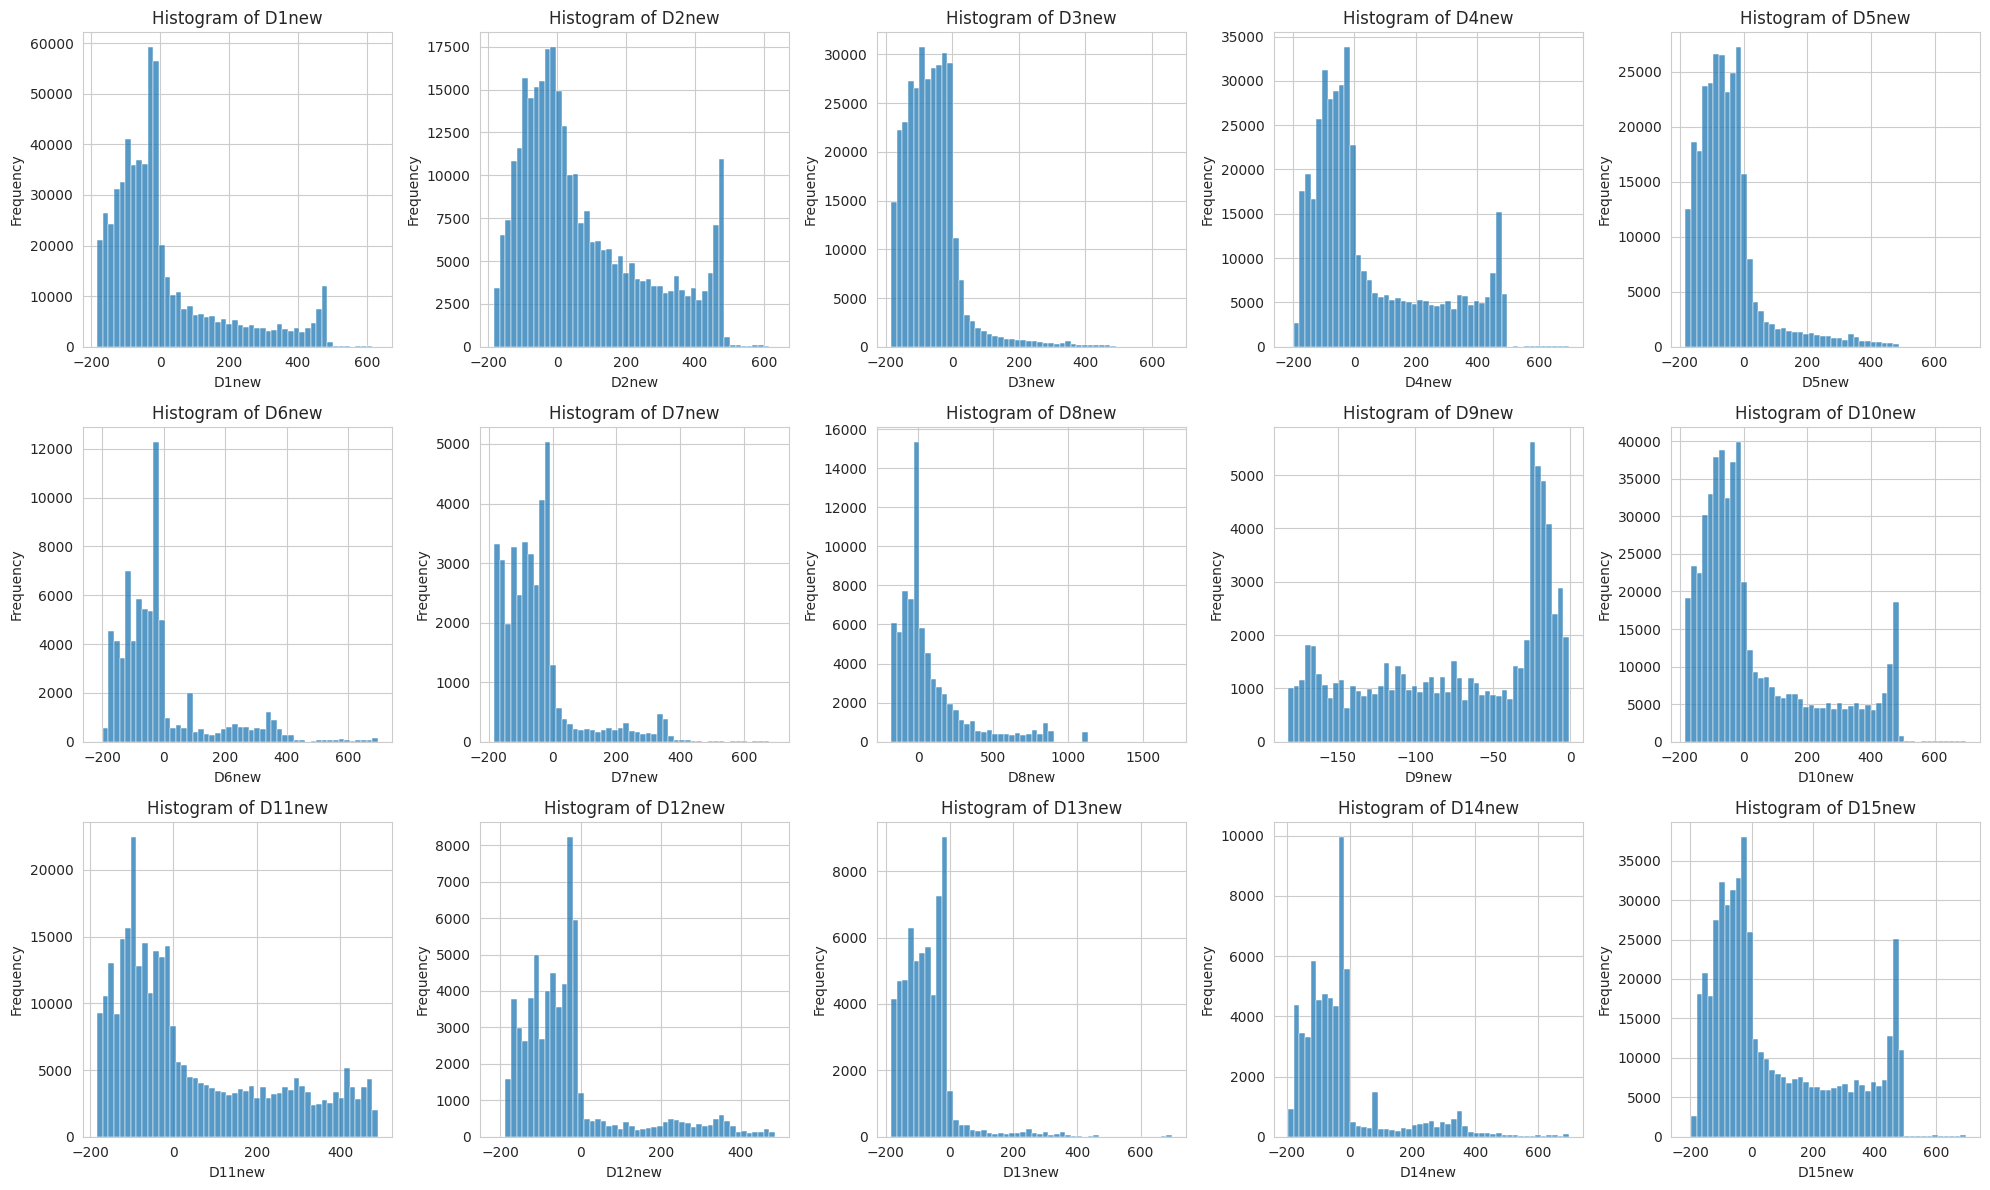

In [29]:
d_columns = [f'D{i}new' for i in range(1, 16) ]#if i != 7]

n_cols = 5
n_rows = (len(d_columns) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 4))
axes = axes.flatten()

for i, col_name in enumerate(d_columns):
    sns.histplot(merged_data[col_name], bins=50, kde=False, ax=axes[i])
    axes[i].set_xlabel(col_name, rotation=0)
    axes[i].set_ylabel("Frequency")
    axes[i].set_title(f"Histogram of {col_name}")

for j in range(len(d_columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [30]:
# d_columns = [f'D{i}new' for i in range(1, 16) ]#if i != 7]

# fig, axes = plt.subplots(len(d_columns), 1, figsize=(8, len(d_columns) * 5))

# if len(d_columns) == 1:
#     axes = [axes]

# for ax, col in zip(axes, d_columns):
#     ax.scatter(merged_data['TransactionDT'] / np.float32(24 * 60 * 60), merged_data[col], alpha=0.5)
#     ax.set_xlabel('TransactionDT - Days')
#     ax.set_ylabel(col)
#     ax.set_title(f'Scatter Plot of {col} vs TransactionDT - Days')

# plt.tight_layout()
# plt.show()

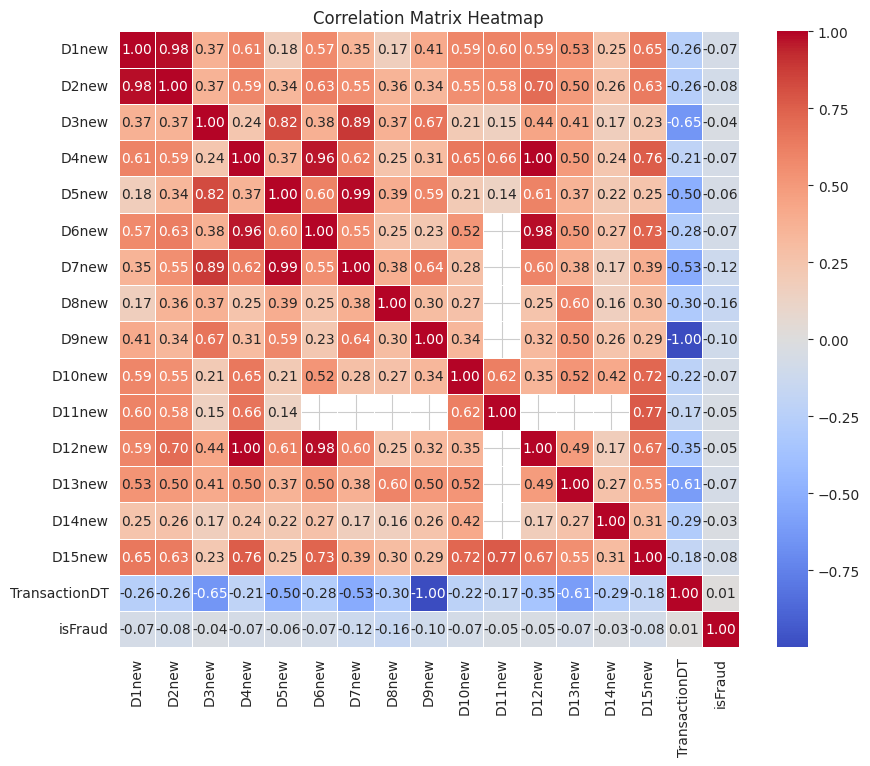

In [31]:
columns = [f"D{i}new" for i in range(1, 16)] + ["TransactionDT"] + ["isFraud"]
# columns.remove("D7new")

correlation_matrix = merged_data[columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)

plt.title("Correlation Matrix Heatmap")
plt.show()

There are more linear/high correlation relations between some of the D columns.

### Cards

The following columns contain information related to the transaction related cards.

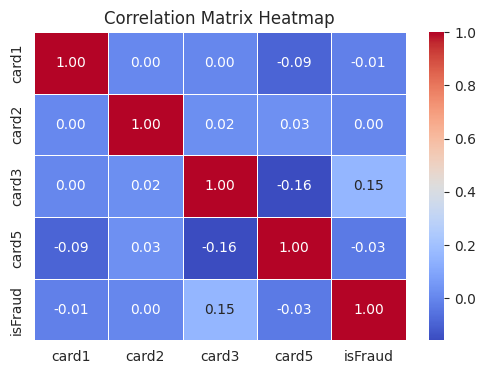

In [32]:
columns = [f"card{i}" for i in range(1, 7)] + ["isFraud"]
columns.remove("card4")
columns.remove("card6")

correlation_matrix = merged_data[columns].corr()

plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)

plt.title("Correlation Matrix Heatmap")
plt.show()

we see no correlation

In [33]:
col_name = "card4"

counts = merged_data[col_name].value_counts(dropna=False)
normalized_counts = merged_data[col_name].value_counts(dropna=False, normalize=True)

result = pd.DataFrame({
    col_name: counts.index,
    "Count": counts.values,
    "Percentage": normalized_counts.values * 100
})

print("\n",result,"\n")

temp_col = merged_data[col_name].astype(str).replace("nan", "nan")

counts = temp_col.value_counts(dropna=False)
result = pd.DataFrame({
    col_name: counts.index,
    "Count": counts.values
})


               card4   Count  Percentage
0              visa  384767   65.155333
1        mastercard  189215   32.041122
2  american express    8328    1.410239
3          discover    6651    1.126261
4               NaN    1577    0.267045 



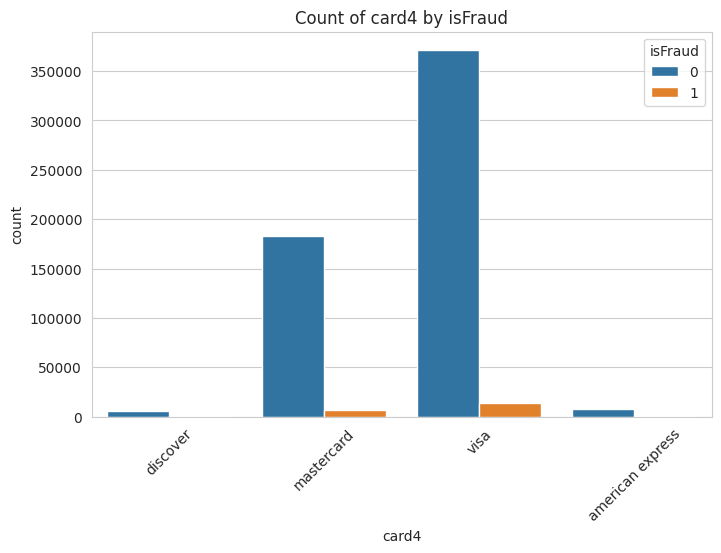

In [34]:
plt.figure(figsize=(8, 5))
sns.countplot(data=merged_data, x="card4", hue="isFraud")
plt.title("Count of card4 by isFraud")
plt.xticks(rotation=45)
plt.show()


we can see that many transactions done without any card. interesting...

In [35]:
col_name = "card6"

counts = merged_data[col_name].value_counts(dropna=False)
normalized_counts = merged_data[col_name].value_counts(dropna=False, normalize=True)

result = pd.DataFrame({
    col_name: counts.index,
    "Count": counts.values,
    "Percentage": normalized_counts.values * 100
})

print("\n",result,"\n")

temp_col = merged_data[col_name].astype(str).replace("nan", "nan")

counts = temp_col.value_counts(dropna=False)
result = pd.DataFrame({
    col_name: counts.index,
    "Count": counts.values
})


              card6   Count  Percentage
0            debit  439938   74.497831
1           credit  148984   25.228520
2              NaN    1571    0.266029
3  debit or credit      30    0.005080
4      charge card      15    0.002540 



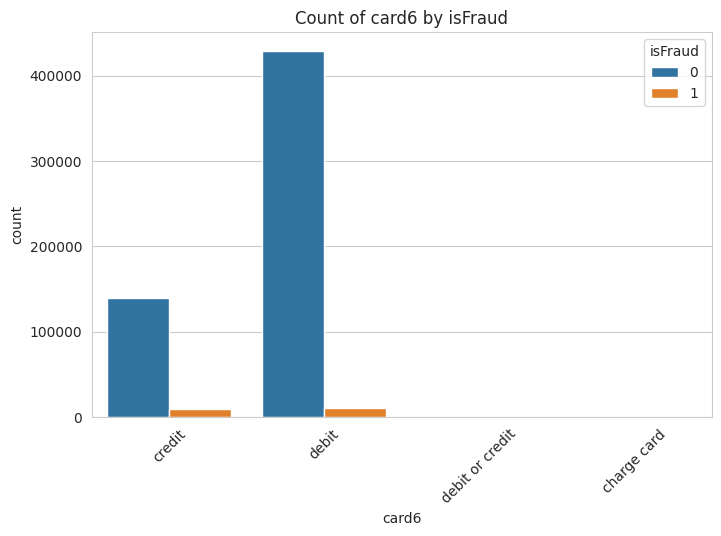

In [36]:
plt.figure(figsize=(8, 5))
sns.countplot(data=merged_data, x="card6", hue="isFraud")
plt.title("Count of card6 by isFraud")
plt.xticks(rotation=45)
plt.show()


Same problem.

Let's check more about it:

In [37]:
merged_data[merged_data['card4'].isna() | merged_data['card6'].isna()][['card4', 'card6']]

card4   card6
9686                 NaN     NaN
11400                NaN   debit
11403                NaN   debit
28994                NaN     NaN
29013                NaN     NaN
...                  ...     ...
526604               NaN     NaN
531569               NaN   debit
531683               NaN  credit
535821  american express     NaN
563720               NaN     NaN

[1583 rows x 2 columns]

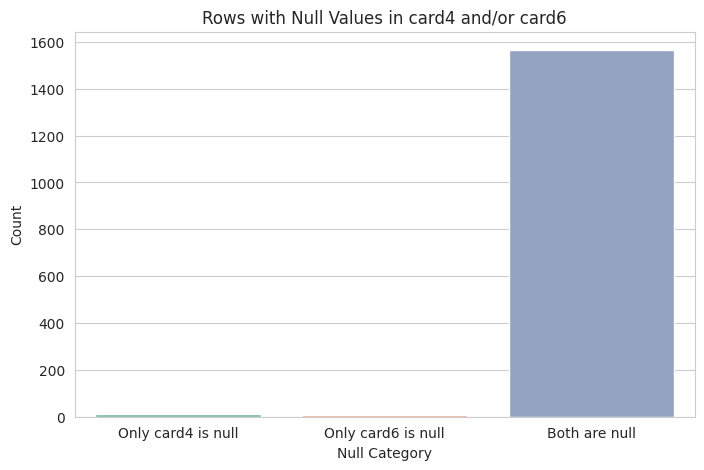

In [38]:
# 0: neither is null (we will filter these out)
# 1: only card4 is null
# 2: only card6 is null
# 3: both are null
merged_data['null_status'] = 0
merged_data.loc[merged_data['card4'].isna() & merged_data['card6'].notna(), 'null_status'] = 1
merged_data.loc[merged_data['card4'].notna() & merged_data['card6'].isna(), 'null_status'] = 2
merged_data.loc[merged_data['card4'].isna() & merged_data['card6'].isna(), 'null_status'] = 3

filtered_data = merged_data[merged_data['null_status'] != 0]

plt.figure(figsize=(8, 5))
ax = sns.countplot(x='null_status', data=filtered_data, hue='null_status', palette="Set2")

if ax.get_legend() is not None:
    ax.get_legend().remove()

plt.xticks(ticks=[0, 1, 2], labels=["Only card4 is null", "Only card6 is null", "Both are null"], rotation=0)

plt.xlabel("Null Category")
plt.ylabel("Count")
plt.title("Rows with Null Values in card4 and/or card6")
plt.show()

Most of the nulls are common to both card4 and card6.

In [39]:
nulls_per_row = merged_data.isnull().sum(axis=1)

mean_nulls = nulls_per_row.mean()

print("Mean number of NULLs per row:", mean_nulls)

Mean number of NULLs per row: 204.34541045622805


In [40]:
only_card4_null_mask = merged_data['card4'].isnull() & merged_data['card6'].notnull()
only_card6_null_mask = merged_data['card4'].notnull() & merged_data['card6'].isnull()
both_null_mask      = merged_data['card4'].isnull() & merged_data['card6'].isnull()

mean_nulls_only_card4 = merged_data[only_card4_null_mask].isnull().sum(axis=1).mean()
mean_nulls_only_card6 = merged_data[only_card6_null_mask].isnull().sum(axis=1).mean()
mean_nulls_both       = merged_data[both_null_mask].isnull().sum(axis=1).mean()

print("\nMean number of nulls per row where only card4 is null:", mean_nulls_only_card4)
print("Mean number of nulls per row where only card6 is null:", mean_nulls_only_card6)
print("Mean number of nulls per row where both card4 and card6 are null:", mean_nulls_both, "\n")


Mean number of nulls per row where only card4 is null: 160.66666666666666
Mean number of nulls per row where only card6 is null: 142.66666666666666
Mean number of nulls per row where both card4 and card6 are null: 217.29073482428115 



When only one of them is null, there are much less NULLs for the entire record.

When both of them are NULL's, there are a bit more.

Maybe we should drop those records..

### Device

In [41]:
col_name = "DeviceInfo"

counts = merged_data[col_name].value_counts(dropna=False)
normalized_counts = merged_data[col_name].value_counts(dropna=False, normalize=True)

result = pd.DataFrame({
    col_name: counts.index,
    "Count": counts.values,
    "Percentage": normalized_counts.values * 100
})

result

DeviceInfo   Count  Percentage
0                               NaN  471872   79.905442
1                           Windows   47722    8.081106
2                        iOS Device   19782    3.349827
3                             MacOS   12573    2.129076
4                       Trident/7.0    7440    1.259868
...                             ...     ...         ...
1782                      SM-A500FU       1    0.000169
1783                  verykoolS5019       1    0.000169
1784                       SM-T537V       1    0.000169
1785  SAMSUNG SM-J111M Build/LMY47V       1    0.000169
1786              SAMSUNG-SM-G930AZ       1    0.000169

[1787 rows x 3 columns]


   DeviceType   Count  Percentage
0        NaN  449728   76.155641
1    desktop   85165   14.421595
2     mobile   55645    9.422764 



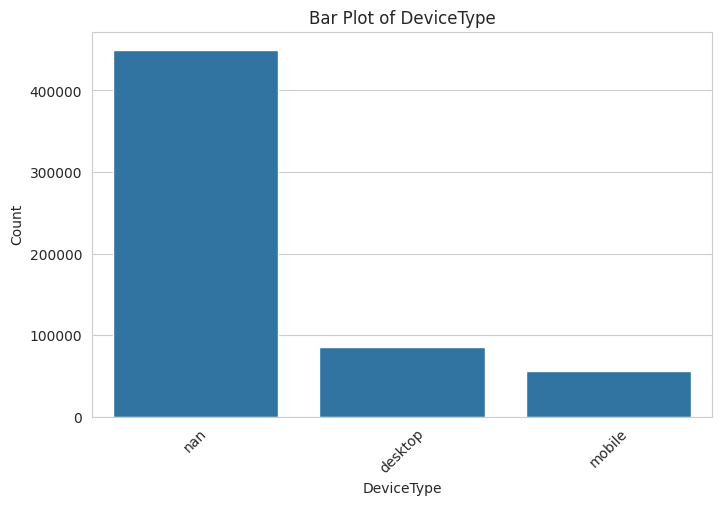

In [42]:
col_name = "DeviceType"

counts = merged_data[col_name].value_counts(dropna=False)
normalized_counts = merged_data[col_name].value_counts(dropna=False, normalize=True)

result = pd.DataFrame({
    col_name: counts.index,
    "Count": counts.values,
    "Percentage": normalized_counts.values * 100
})

print("\n",result,"\n")

temp_col = merged_data[col_name].astype(str).replace("nan", "nan")

counts = temp_col.value_counts(dropna=False)
result = pd.DataFrame({
    col_name: counts.index,
    "Count": counts.values
})

plt.figure(figsize=(8, 5))
sns.barplot(x=result[col_name], y=result["Count"], order=result[col_name])

plt.xlabel(col_name)
plt.ylabel("Count")
plt.title(f"Bar Plot of {col_name}")

plt.xticks(rotation=45)
plt.show()

In [43]:
filtered_data = merged_data[merged_data['DeviceType'].isnull() | merged_data['DeviceInfo'].isnull()]

columns_of_interest = ['card4', 'card6', 'DeviceType', 'DeviceInfo','isFraud']
filtered_data = filtered_data[columns_of_interest]

filtered_data

card4   card6 DeviceType DeviceInfo  isFraud
0         discover  credit        NaN        NaN        0
1       mastercard  credit        NaN        NaN        0
2             visa   debit        NaN        NaN        0
3       mastercard   debit        NaN        NaN        0
5             visa   debit        NaN        NaN        0
...            ...     ...        ...        ...      ...
590535        visa   debit        NaN        NaN        0
590536  mastercard   debit        NaN        NaN        0
590537  mastercard   debit        NaN        NaN        0
590538  mastercard   debit        NaN        NaN        0
590539  mastercard  credit        NaN        NaN        0

[471917 rows x 5 columns]

In [44]:
filtered_data[filtered_data["card4"].isnull() | filtered_data['card6'].isnull()]

card4 card6 DeviceType DeviceInfo  isFraud
28994    NaN   NaN        NaN        NaN        1
29013    NaN   NaN        NaN        NaN        1
254275   NaN   NaN    desktop        NaN        0
283428   NaN   NaN        NaN        NaN        0
313714   NaN   NaN        NaN        NaN        0
...      ...   ...        ...        ...      ...
526600   NaN   NaN        NaN        NaN        0
526601   NaN   NaN        NaN        NaN        0
526603   NaN   NaN        NaN        NaN        0
526604   NaN   NaN        NaN        NaN        0
563720   NaN   NaN        NaN        NaN        0

[1463 rows x 5 columns]

And the opposite:

In [45]:
filtered_data_2 = merged_data[merged_data['card4'].isnull() | merged_data['card6'].isnull()]

columns_of_interest = ['card4', 'card6', 'DeviceType', 'DeviceInfo','isFraud']
filtered_data_2 = filtered_data_2[columns_of_interest]

filtered_data_2

card4   card6 DeviceType             DeviceInfo  isFraud
9686                 NaN     NaN     mobile  SM-G955U Build/NRD90M        0
11400                NaN   debit     mobile  SM-G950U Build/NRD90M        0
11403                NaN   debit     mobile  SM-G950U Build/NRD90M        0
28994                NaN     NaN        NaN                    NaN        1
29013                NaN     NaN        NaN                    NaN        1
...                  ...     ...        ...                    ...      ...
526604               NaN     NaN        NaN                    NaN        0
531569               NaN   debit     mobile             iOS Device        0
531683               NaN  credit     mobile             iOS Device        0
535821  american express     NaN    desktop                Windows        0
563720               NaN     NaN        NaN                    NaN        0

[1583 rows x 5 columns]

In [46]:
len(filtered_data_2[filtered_data_2["isFraud"]==1])

41

In [47]:
filtered_data_2[filtered_data_2["DeviceType"].isnull() | filtered_data_2["DeviceType"].isnull()]

card4 card6 DeviceType DeviceInfo  isFraud
28994    NaN   NaN        NaN        NaN        1
29013    NaN   NaN        NaN        NaN        1
283428   NaN   NaN        NaN        NaN        0
313714   NaN   NaN        NaN        NaN        0
313715   NaN   NaN        NaN        NaN        0
...      ...   ...        ...        ...      ...
526600   NaN   NaN        NaN        NaN        0
526601   NaN   NaN        NaN        NaN        0
526603   NaN   NaN        NaN        NaN        0
526604   NaN   NaN        NaN        NaN        0
563720   NaN   NaN        NaN        NaN        0

[1394 rows x 5 columns]

It seems that maybe when there is a no device - there is a card, but not the oposite.
(More than half of the NULL card and NULL device are fraud..)

we will create a new feature from this insight:

In [48]:
merged_data['all_4_is_nan'] = merged_data.apply(
    lambda row: 1 if pd.isnull(row['card4'])
                   and pd.isnull(row['card6'])
                   and pd.isnull(row['DeviceType'])
                   and pd.isnull(row['DeviceInfo'])
               else 0,
    axis=1
)


In [49]:
filtered_data = merged_data.loc[
    merged_data['all_4_is_nan'] == 1,
    ['card4', 'card6', 'DeviceType', 'DeviceInfo', 'all_4_is_nan']]

filtered_data

card4 card6 DeviceType DeviceInfo  all_4_is_nan
28994    NaN   NaN        NaN        NaN             1
29013    NaN   NaN        NaN        NaN             1
283428   NaN   NaN        NaN        NaN             1
313714   NaN   NaN        NaN        NaN             1
313715   NaN   NaN        NaN        NaN             1
...      ...   ...        ...        ...           ...
526600   NaN   NaN        NaN        NaN             1
526601   NaN   NaN        NaN        NaN             1
526603   NaN   NaN        NaN        NaN             1
526604   NaN   NaN        NaN        NaN             1
563720   NaN   NaN        NaN        NaN             1

[1394 rows x 5 columns]

### Emails

Purchaser email:

In [50]:
merged_data['P_emaildomain'].value_counts()

P_emaildomain
gmail.com           228355
yahoo.com           100932
hotmail.com          45250
anonymous.com        36998
aol.com              28289
comcast.net           7888
icloud.com            6267
outlook.com           5096
msn.com               4092
att.net               4033
live.com              3041
sbcglobal.net         2970
verizon.net           2705
ymail.com             2396
bellsouth.net         1909
yahoo.com.mx          1543
me.com                1522
cox.net               1393
optonline.net         1011
charter.net            816
live.com.mx            749
rocketmail.com         664
mail.com               559
earthlink.net          514
gmail                  496
outlook.es             438
mac.com                436
juno.com               322
aim.com                315
hotmail.es             305
roadrunner.com         305
windstream.net         305
hotmail.fr             295
frontier.com           280
embarqmail.com         260
web.de                 240
netzero.com            230
twc.com                230
prodigy.net.mx         207
centurylink.net        205
netzero.net            196
frontiernet.net        195
q.com                  189
suddenlink.net         175
cfl.rr.com             172
sc.rr.com              164
cableone.net           159
gmx.de                 149
yahoo.fr               143
yahoo.es               134
hotmail.co.uk          112
protonmail.com          76
yahoo.de                74
ptd.net                 68
live.fr                 56
yahoo.co.uk             49
hotmail.de              43
servicios-ta.com        35
yahoo.co.jp             32
Name: count, dtype: int64

In [51]:
merged_data["P_emaildomain"] = merged_data["P_emaildomain"].str.replace(r"\.com$|\.net$|\.es$|\.fr$|\.de$|\.co\.uk$|\.co\.jp$","",regex=True)
merged_data['P_emaildomain'].value_counts()

P_emaildomain
gmail             228851
yahoo             101364
hotmail            46005
anonymous          36998
aol                28289
comcast             7888
icloud              6267
outlook             5534
msn                 4092
att                 4033
live                3097
sbcglobal           2970
verizon             2705
ymail               2396
bellsouth           1909
yahoo.com.mx        1543
me                  1522
cox                 1393
optonline           1011
charter              816
live.com.mx          749
rocketmail           664
mail                 559
earthlink            514
mac                  436
netzero              426
juno                 322
aim                  315
roadrunner           305
windstream           305
frontier             280
embarqmail           260
web                  240
twc                  230
prodigy.net.mx       207
centurylink          205
frontiernet          195
q                    189
suddenlink           175
cfl.rr               172
sc.rr                164
cableone             159
gmx                  149
protonmail            76
ptd                   68
servicios-ta          35
Name: count, dtype: int64

In [52]:
merged_data["P_emaildomain"].isna().sum()

94456

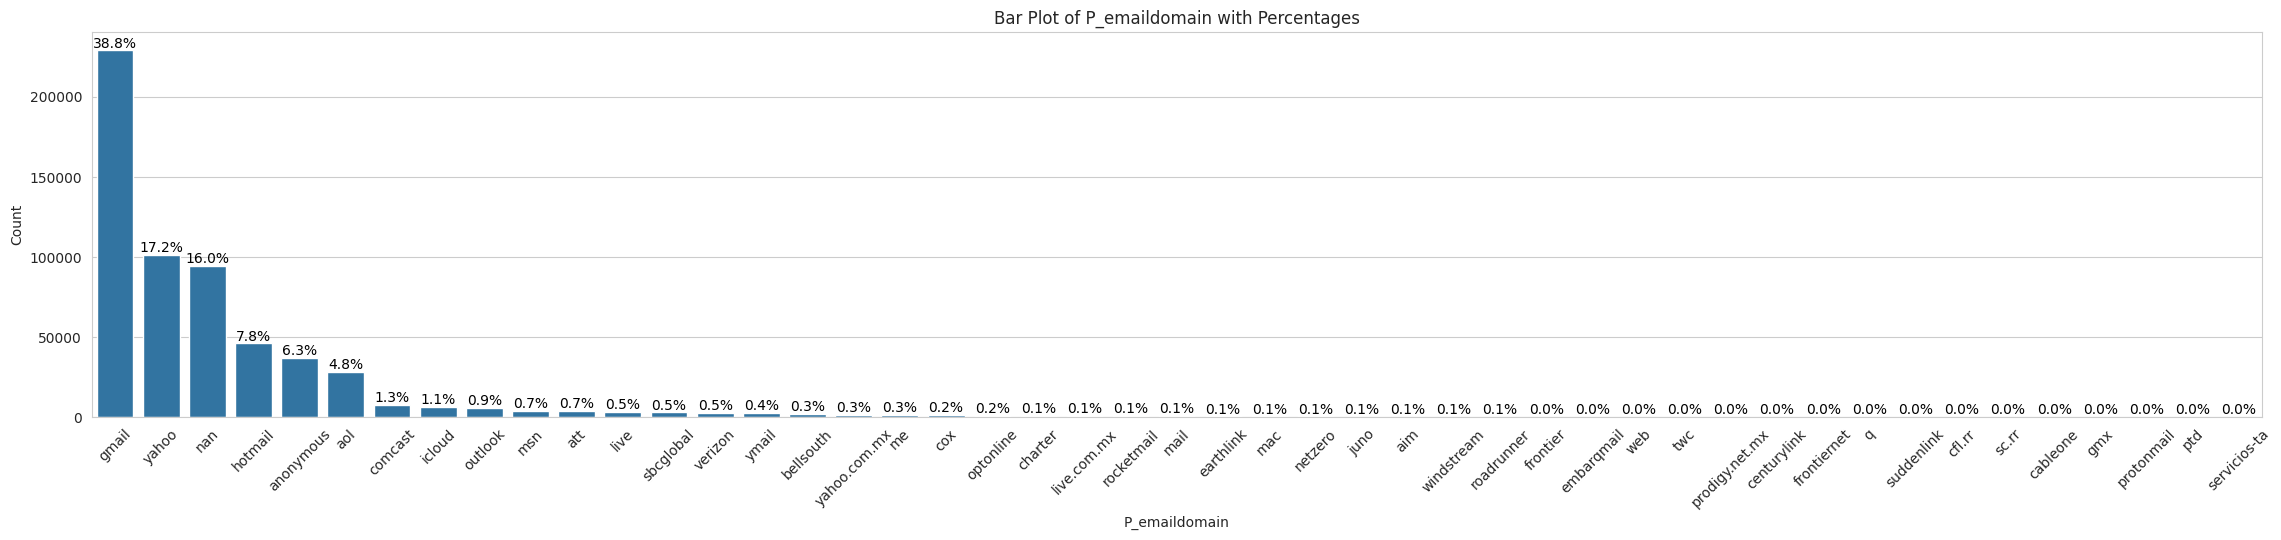

In [53]:
col_name = "P_emaildomain"

temp_col = merged_data[col_name].astype(str).replace("nan", "nan")

counts = temp_col.value_counts(dropna=False)
percentages = (counts / counts.sum()) * 100

result = pd.DataFrame({
    col_name: counts.index,
    "Count": counts.values,
    "Percentage": percentages.values
})

plt.figure(figsize=(28, 5))
ax = sns.barplot(x=result[col_name], y=result["Count"], order=result[col_name])

for i, (count, percentage) in enumerate(zip(result["Count"], result["Percentage"])):
    ax.text(i, count, f"{percentage:.1f}%", ha="center", va="bottom", fontsize=10, color="black")

plt.xlabel(col_name)
plt.ylabel("Count")
plt.title(f"Bar Plot of {col_name} with Percentages")

plt.xticks(rotation=45)
plt.show()

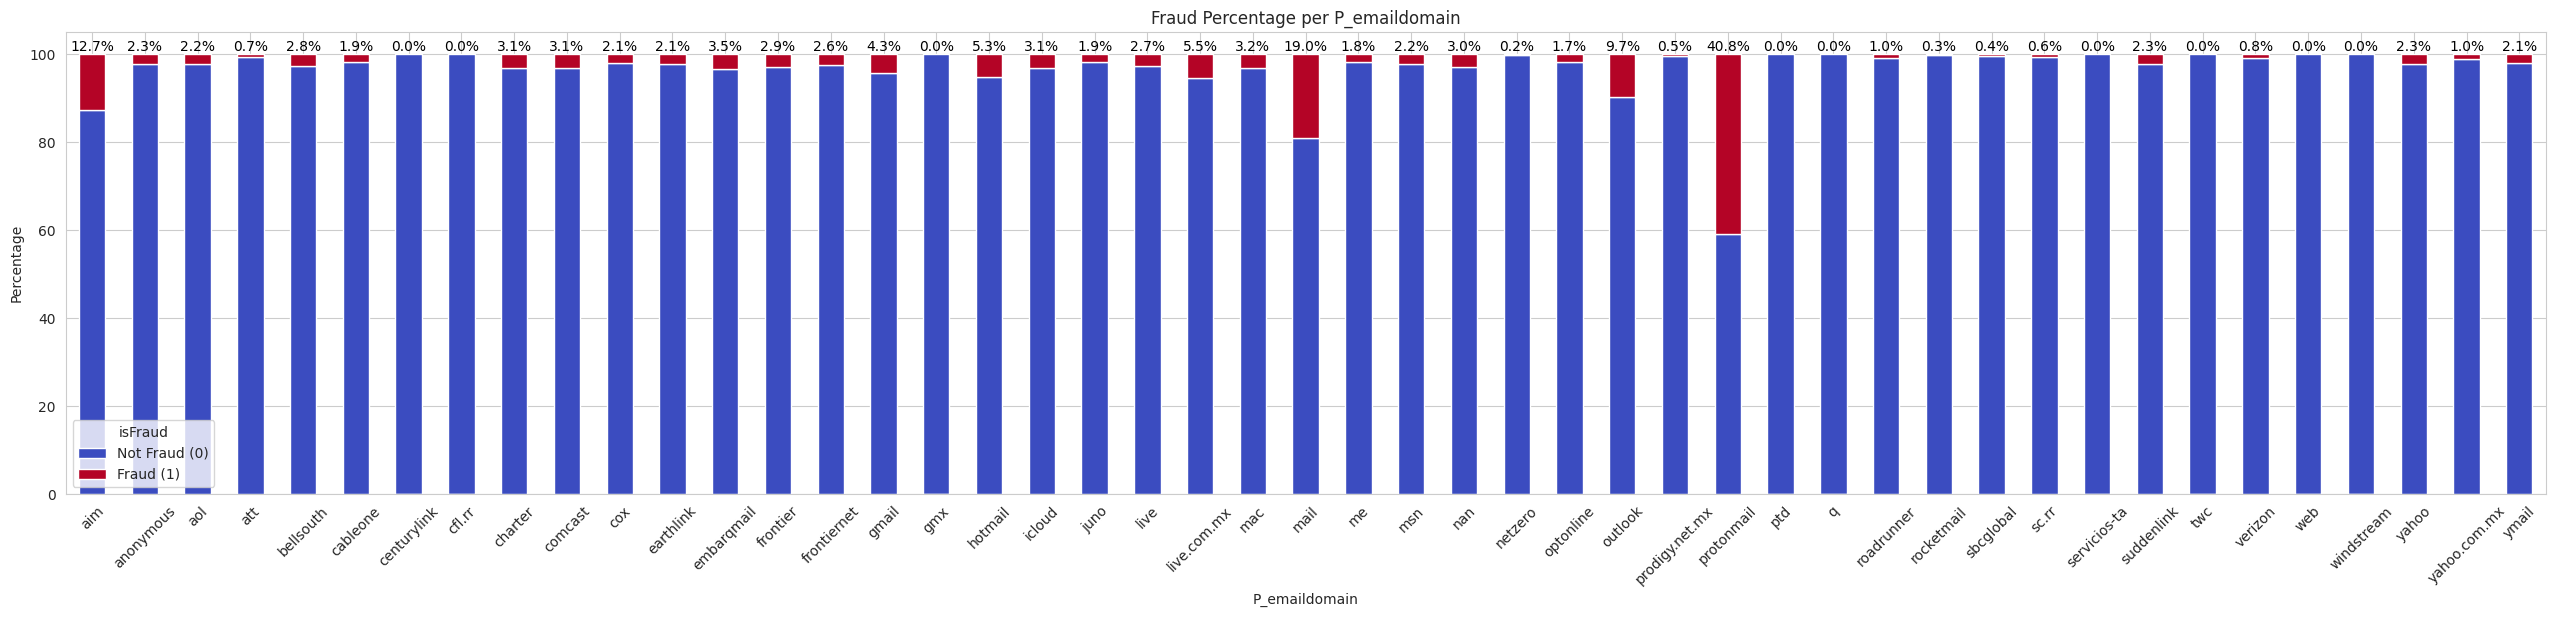

In [54]:
temp_col = merged_data[col_name].fillna("nan")

fraud_ratio = merged_data.groupby(temp_col)["isFraud"].value_counts(normalize=True).unstack() * 100

fraud_ratio = fraud_ratio.fillna(0)

fraud_percentage = fraud_ratio[1]

ax = fraud_ratio.plot(kind="bar", stacked=True, figsize=(32, 6), colormap="coolwarm")

for i, fraud_pct in enumerate(fraud_percentage):
    ax.text(i, 100, f"{fraud_pct:.1f}%", ha="center", va="bottom", fontsize=10, color="black")

plt.xlabel("P_emaildomain")
plt.ylabel("Percentage")
plt.title("Fraud Percentage per P_emaildomain")
plt.xticks(rotation=45)
plt.legend(title="isFraud", labels=["Not Fraud (0)", "Fraud (1)"])

plt.show()

Most of the email domains of the buyers are from Gmail, Yahoo or just NULL.

There are domains with significant percentages of frauds!

we will create new features by groups of email domains by precentage

In [55]:
def fraud_category(fraud_pct):
    if fraud_pct < 1:
        return "0-1%"
    elif fraud_pct < 10:
        return "1-10%"
    else:
        return "above 10%"


fraud_category_mapping = fraud_percentage.apply(fraud_category)
fraud_category_dict = fraud_category_mapping.to_dict()


merged_data["fraud_category_P_email"] = merged_data["P_emaildomain"].fillna("nan").map(fraud_category_dict)

Recipient email:

In [56]:
merged_data['R_emaildomain'].value_counts()

R_emaildomain
gmail.com           57147
hotmail.com         27509
anonymous.com       20529
yahoo.com           11842
aol.com              3701
outlook.com          2507
comcast.net          1812
yahoo.com.mx         1508
icloud.com           1398
msn.com               852
live.com              762
live.com.mx           754
verizon.net           620
me.com                556
sbcglobal.net         552
cox.net               459
outlook.es            433
att.net               430
bellsouth.net         422
hotmail.fr            293
hotmail.es            292
web.de                237
mac.com               218
ymail.com             207
prodigy.net.mx        207
optonline.net         187
gmx.de                147
yahoo.fr              137
charter.net           127
mail.com              122
hotmail.co.uk         105
gmail                  95
earthlink.net          79
yahoo.de               75
rocketmail.com         69
embarqmail.com         68
scranton.edu           63
yahoo.es               57
live.fr                55
roadrunner.com         53
juno.com               53
frontier.com           52
windstream.net         47
hotmail.de             42
protonmail.com         41
yahoo.co.uk            39
cfl.rr.com             37
aim.com                36
servicios-ta.com       35
yahoo.co.jp            33
twc.com                29
ptd.net                27
cableone.net           27
q.com                  25
suddenlink.net         25
frontiernet.net        14
netzero.com            14
centurylink.net        12
netzero.net             9
sc.rr.com               8
Name: count, dtype: int64

In [57]:
merged_data["R_emaildomain"] = merged_data["R_emaildomain"].str.replace(r"\.com$|\.net$|\.es$|\.fr$|\.de$|\.co\.uk$|\.co\.jp$","",regex=True)
merged_data['R_emaildomain'].value_counts()

R_emaildomain
gmail             57242
hotmail           28241
anonymous         20529
yahoo             12183
aol                3701
outlook            2940
comcast            1812
yahoo.com.mx       1508
icloud             1398
msn                 852
live                817
live.com.mx         754
verizon             620
me                  556
sbcglobal           552
cox                 459
att                 430
bellsouth           422
web                 237
mac                 218
ymail               207
prodigy.net.mx      207
optonline           187
gmx                 147
charter             127
mail                122
earthlink            79
rocketmail           69
embarqmail           68
scranton.edu         63
roadrunner           53
juno                 53
frontier             52
windstream           47
protonmail           41
cfl.rr               37
aim                  36
servicios-ta         35
twc                  29
ptd                  27
cableone             27
q                    25
suddenlink           25
netzero              23
frontiernet          14
centurylink          12
sc.rr                 8
Name: count, dtype: int64

In [58]:
merged_data["R_emaildomain"].isna().sum()

453247

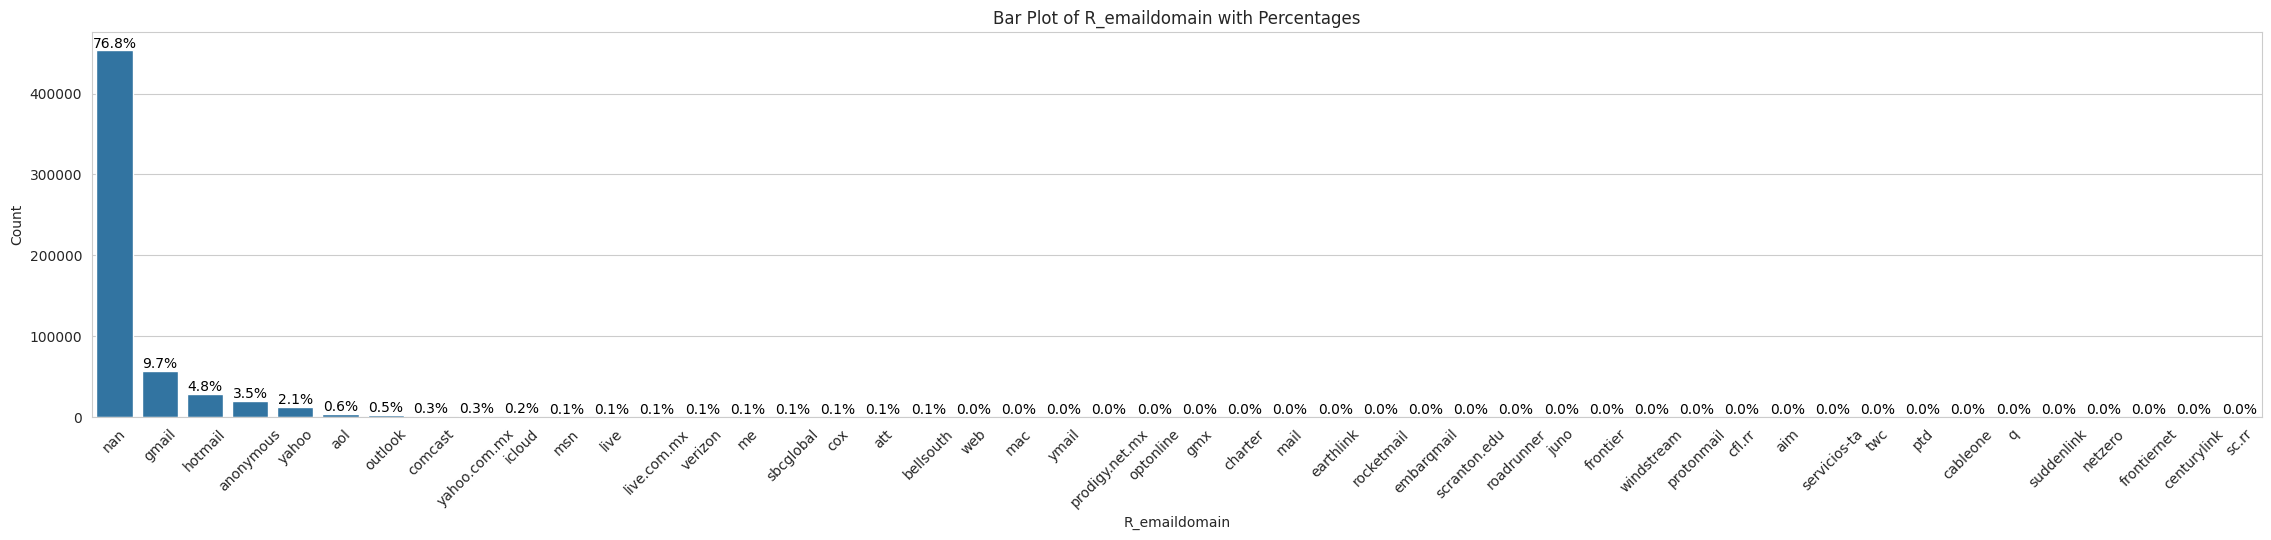

In [59]:
col_name = "R_emaildomain"

temp_col = merged_data[col_name].astype(str).replace("nan", "nan")

counts = temp_col.value_counts(dropna=False)
percentages = (counts / counts.sum()) * 100

result = pd.DataFrame({
    col_name: counts.index,
    "Count": counts.values,
    "Percentage": percentages.values
})

plt.figure(figsize=(28, 5))
ax = sns.barplot(x=result[col_name], y=result["Count"], order=result[col_name])

for i, (count, percentage) in enumerate(zip(result["Count"], result["Percentage"])):
    ax.text(i, count, f"{percentage:.1f}%", ha="center", va="bottom", fontsize=10, color="black")

plt.xlabel(col_name)
plt.ylabel("Count")
plt.title(f"Bar Plot of {col_name} with Percentages")

plt.xticks(rotation=45)
plt.show()

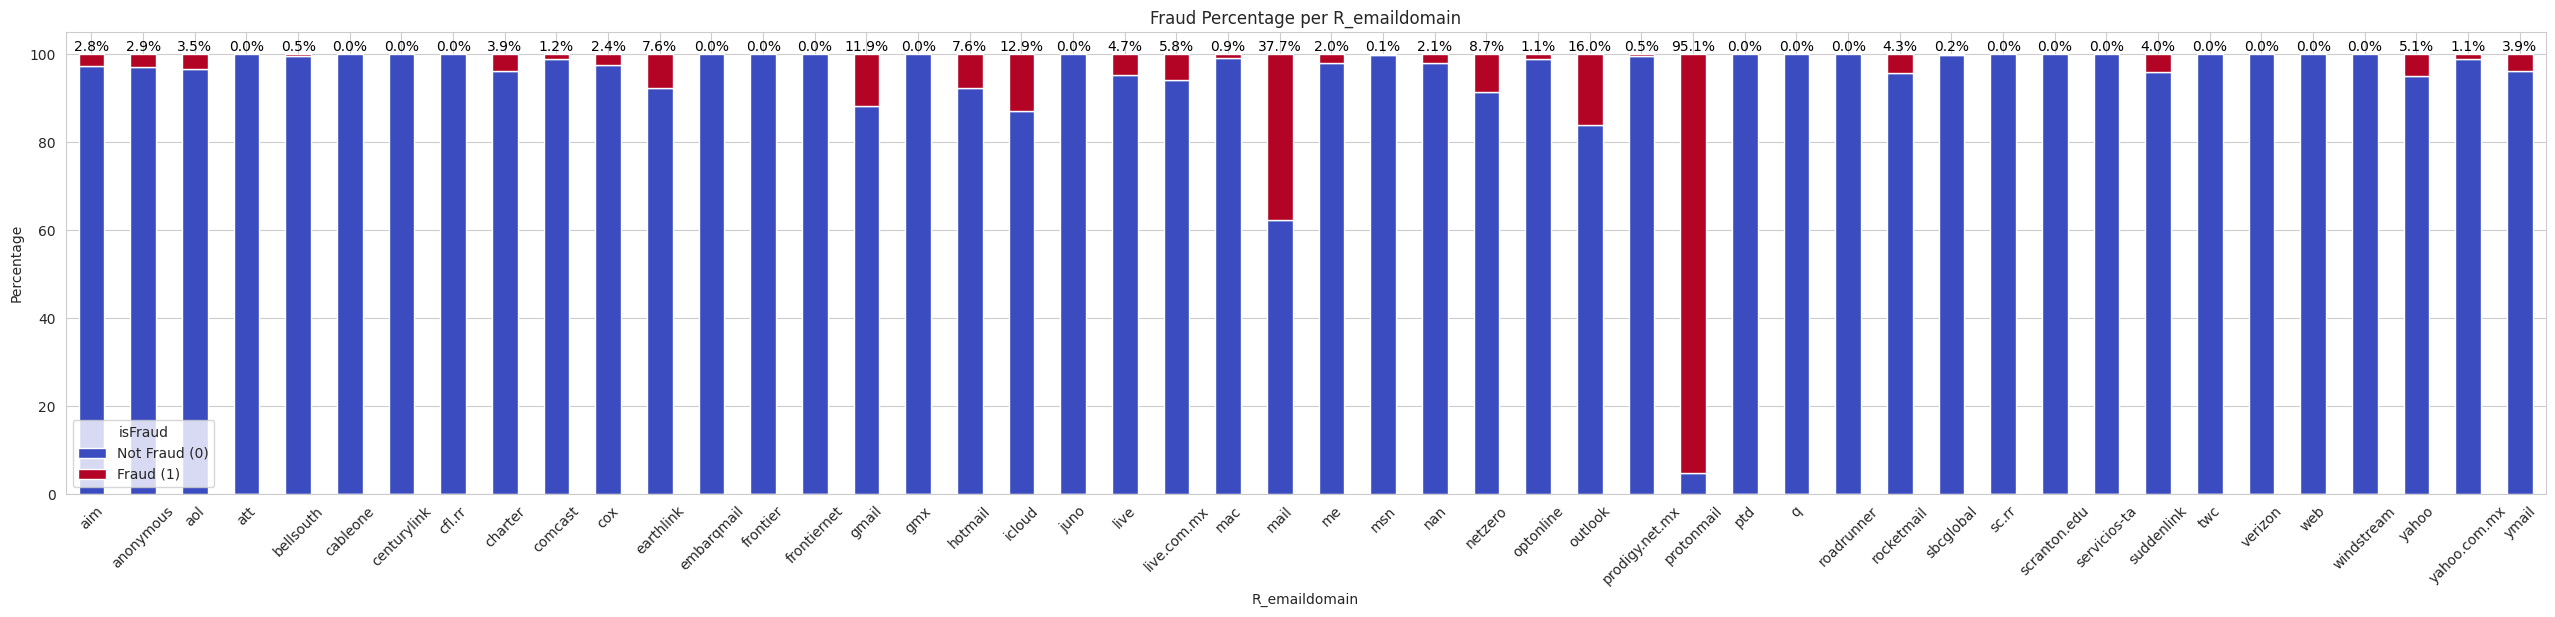

In [60]:
temp_col = merged_data[col_name].fillna("nan")

fraud_ratio = merged_data.groupby(temp_col)["isFraud"].value_counts(normalize=True).unstack() * 100

fraud_ratio = fraud_ratio.fillna(0)

fraud_percentage = fraud_ratio[1]

ax = fraud_ratio.plot(kind="bar", stacked=True, figsize=(32, 6), colormap="coolwarm")

for i, fraud_pct in enumerate(fraud_percentage):
    ax.text(i, 100, f"{fraud_pct:.1f}%", ha="center", va="bottom", fontsize=10, color="black")

plt.xlabel("R_emaildomain")
plt.ylabel("Percentage")
plt.title("Fraud Percentage per R_emaildomain")
plt.xticks(rotation=45)
plt.legend(title="isFraud", labels=["Not Fraud (0)", "Fraud (1)"])

plt.show()

Here we can see that most of the recipients' email domains are NULL.
There are domains with significant percentages of froads, with two of them being very significant:

* 'protonmail' with 95.1% fraud (40.8% for it in P_emaildomain)!

* 'mail' with 37.7% fraud (19% for it in P_emaildomain).

we will group also by the precentage.

In [61]:
def fraud_category_R(fraud_pct):
    if fraud_pct < 1:
        return "0-1%"
    elif fraud_pct < 10:
        return "1-10%"
    elif fraud_pct <20:
        return "10-20%"
    else:
        return "above 20%"


fraud_category_mapping = fraud_percentage.apply(fraud_category_R)
fraud_category_dict = fraud_category_mapping.to_dict()

merged_data["fraud_category_R_email"] = merged_data["R_emaildomain"].fillna("nan").map(fraud_category_dict)

In [62]:
def compute_fraud_mapping(train_df, col_name, category_type="P"):
    temp_col = train_df[col_name].astype(str).replace("nan", "nan")
    fraud_ratio = train_df.groupby(temp_col)["isFraud"].value_counts(normalize=True).unstack() * 100
    fraud_ratio = fraud_ratio.fillna(0)
    fraud_percentage = fraud_ratio[1] if 1 in fraud_ratio.columns else pd.Series()

    if category_type == "P":
        fraud_category_mapping = fraud_percentage.apply(
            lambda fraud_pct: "0-1%" if fraud_pct < 1 else "1-10%" if fraud_pct < 10 else "above 10%"
        )
    else:
        fraud_category_mapping = fraud_percentage.apply(
            lambda fraud_pct: "0-1%" if fraud_pct < 1 else "1-10%" if fraud_pct < 10 else "10-20%" if fraud_pct < 20 else "above 20%"
        )

    return fraud_category_mapping.to_dict()


now we will apply those functions on our emails columns.

In [63]:
fraud_category_dict_p = compute_fraud_mapping(merged_data, "P_emaildomain", category_type="P")
fraud_category_dict_r = compute_fraud_mapping(merged_data, "R_emaildomain", category_type="R")


In [64]:
merged_data.drop(['R_emaildomain',"P_emaildomain"],axis = 1,inplace = True)

### dist1 & dist2

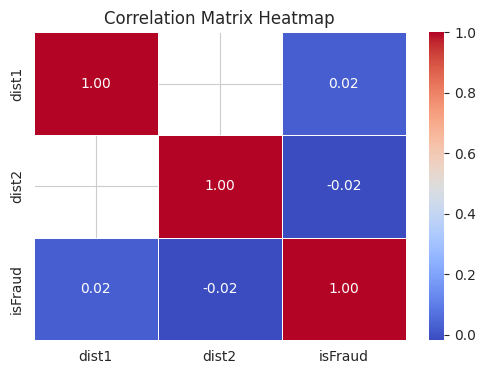

In [65]:
correlation_matrix = merged_data[['dist1','dist2','isFraud']].corr()

plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)

plt.title("Correlation Matrix Heatmap")
plt.show()

In [66]:
col_name = "dist1"

counts = merged_data[col_name].value_counts(dropna=False)
normalized_counts = merged_data[col_name].value_counts(dropna=False, normalize=True)

result = pd.DataFrame({
    col_name: counts.index,
    "Count": counts.values,
    "Percentage": normalized_counts.values * 100
})

print("\n",result,"\n")

col_name = "dist2"

counts = merged_data[col_name].value_counts(dropna=False)
normalized_counts = merged_data[col_name].value_counts(dropna=False, normalize=True)

result = pd.DataFrame({
    col_name: counts.index,
    "Count": counts.values,
    "Percentage": normalized_counts.values * 100
})

print("\n",result,"\n")


        dist1   Count  Percentage
0        NaN  352271   59.652554
1        0.0   19824    3.356939
2        1.0   18330    3.103949
3        2.0   17028    2.883472
4        4.0   13067    2.212728
...      ...     ...         ...
2647  4171.0       1    0.000169
2648  1670.0       1    0.000169
2649  2003.0       1    0.000169
2650  1973.0       1    0.000169
2651  1907.0       1    0.000169

[2652 rows x 3 columns] 


        dist2   Count  Percentage
0        NaN  552911   93.628352
1        7.0    5687    0.963020
2        0.0    3519    0.595897
3        1.0    1374    0.232669
4        9.0     742    0.125648
...      ...     ...         ...
1747  2015.0       1    0.000169
1748  2124.0       1    0.000169
1749  1347.0       1    0.000169
1750  1776.0       1    0.000169
1751  2296.0       1    0.000169

[1752 rows x 3 columns] 



Most of the values are NULL. No correlation.
if one calculated the other one wasnt.

### M's

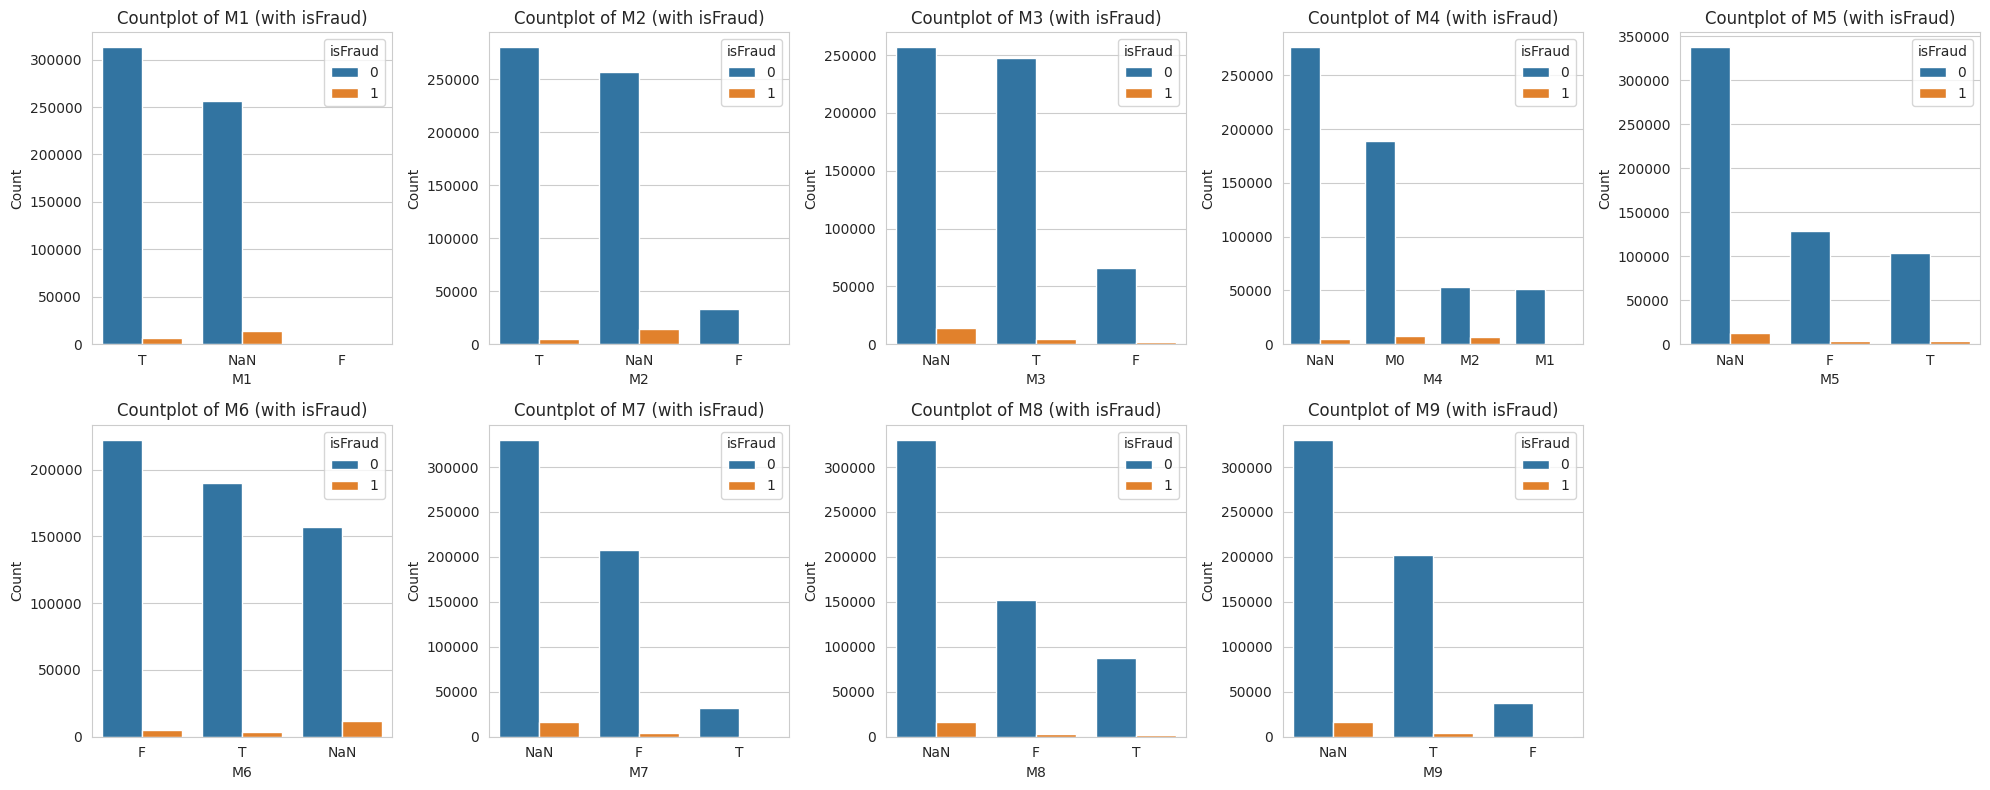

In [67]:
M_columns = [f'M{i}' for i in range(1, 10)]

n_cols = 5
n_rows = (len(M_columns) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 4))
axes = axes.flatten()

for i, col_name in enumerate(M_columns):
    temp_col = merged_data[[col_name, "isFraud"]].copy()
    temp_col[col_name] = temp_col[col_name].fillna("NaN").astype(str)

    sns.countplot(
        data=temp_col,
        x=col_name,
        order=temp_col[col_name].value_counts().index,
        hue="isFraud",
        ax=axes[i]
    )

    axes[i].set_xlabel(col_name, rotation=0)
    axes[i].set_ylabel("Count")
    axes[i].set_title(f"Countplot of {col_name} (with isFraud)")
    axes[i].tick_params(axis='x')
    axes[i].legend(title="isFraud", loc="upper right")

for j in range(len(M_columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

We don't know what are those columns.

No insights for now.

### C's

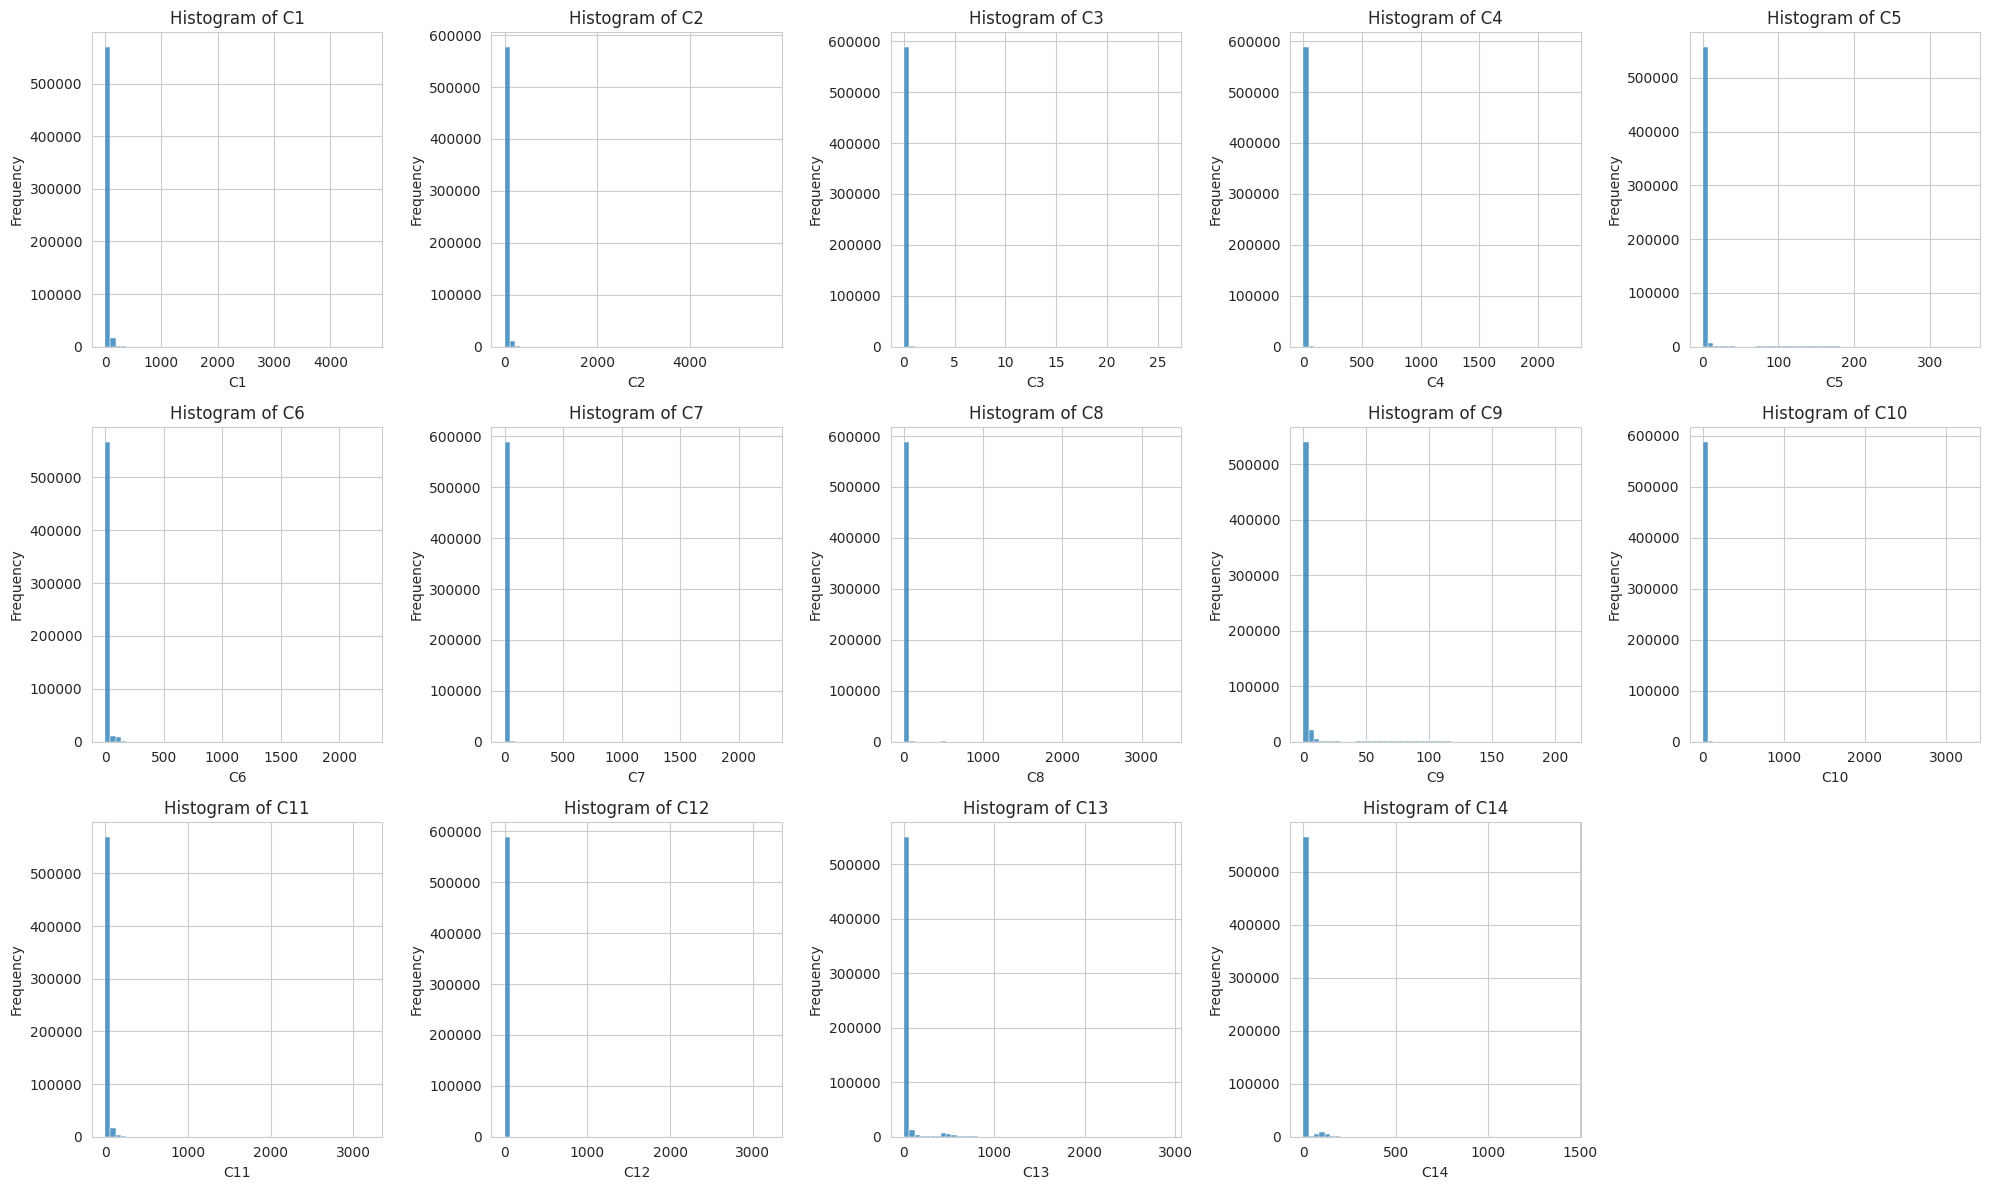

In [68]:
d_columns = [f'C{i}' for i in range(1, 15) ]

n_cols = 5
n_rows = (len(d_columns) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 4))
axes = axes.flatten()

for i, col_name in enumerate(d_columns):
    sns.histplot(merged_data[col_name], bins=50, kde=False, ax=axes[i])
    axes[i].set_xlabel(col_name, rotation=0)
    axes[i].set_ylabel("Frequency")
    axes[i].set_title(f"Histogram of {col_name}")

for j in range(len(d_columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

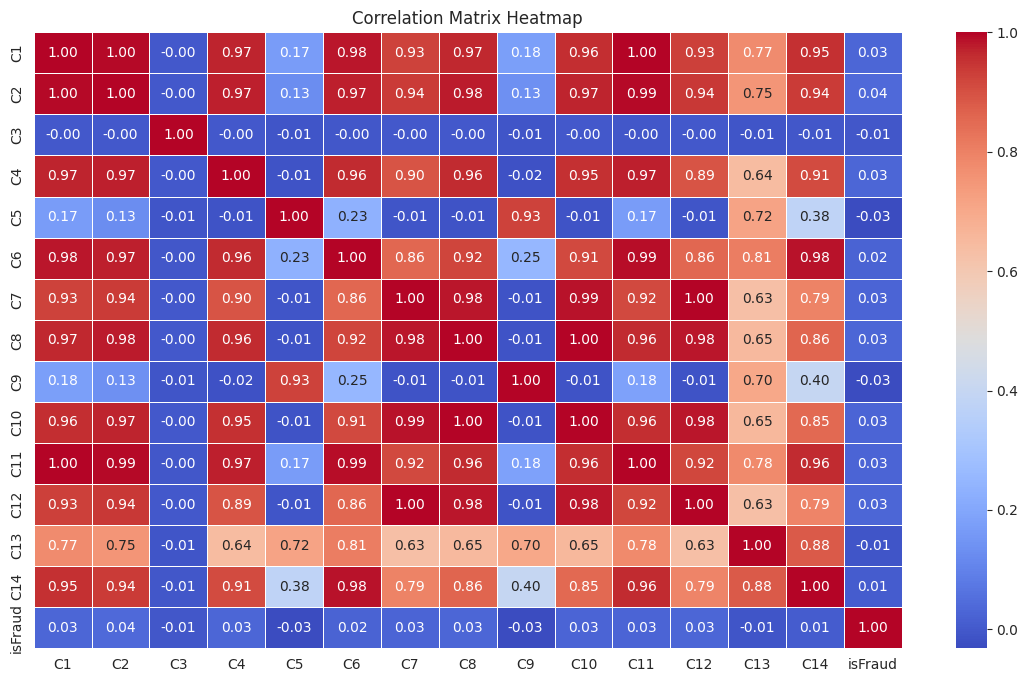

In [69]:
columns = [f"C{i}" for i in range(1, 15)] + ["isFraud"]

correlation_matrix = merged_data[columns].corr()

plt.figure(figsize=(14, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)

plt.title("Correlation Matrix Heatmap")
plt.show()

A lot of high correlation between the columns (except C3).

No correlation with the Dependent variable.
we will handle it in the next section.

### Address

In [70]:
col_name = "addr1"

counts = merged_data[col_name].value_counts(dropna=False)
normalized_counts = merged_data[col_name].value_counts(dropna=False, normalize=True)

result = pd.DataFrame({
    col_name: counts.index,
    "Count": counts.values,
    "Percentage": normalized_counts.values * 100
})

print("\n",result,"\n")

col_name = "addr2"

counts = merged_data[col_name].value_counts(dropna=False)
normalized_counts = merged_data[col_name].value_counts(dropna=False, normalize=True)

result = pd.DataFrame({
    col_name: counts.index,
    "Count": counts.values,
    "Percentage": normalized_counts.values * 100
})

print("\n",result,"\n")


      addr1  Count  Percentage
0      NaN  65706   11.126464
1    299.0  46335    7.846235
2    325.0  42751    7.239331
3    204.0  42020    7.115545
4    264.0  39870    6.751471
..     ...    ...         ...
328  323.0      1    0.000169
329  187.0      1    0.000169
330  178.0      1    0.000169
331  153.0      1    0.000169
332  245.0      1    0.000169

[333 rows x 3 columns] 


     addr2   Count  Percentage
0    87.0  520479   88.136411
1     NaN   65706   11.126464
2    60.0    3084    0.522236
3    96.0     638    0.108037
4    32.0      91    0.015410
..    ...     ...         ...
70   25.0       1    0.000169
71   22.0       1    0.000169
72   15.0       1    0.000169
73   35.0       1    0.000169
74   93.0       1    0.000169

[75 rows x 3 columns] 



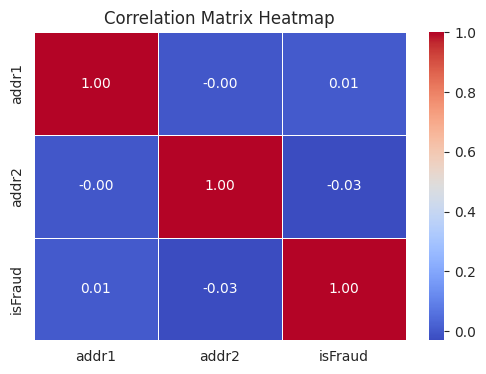

In [71]:
columns = [f"addr{i}" for i in range(1, 3)] + ["isFraud"]

correlation_matrix = merged_data[columns].corr()

plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)

plt.title("Correlation Matrix Heatmap")
plt.show()

No correlation. No visible insights for now, too.

### id's

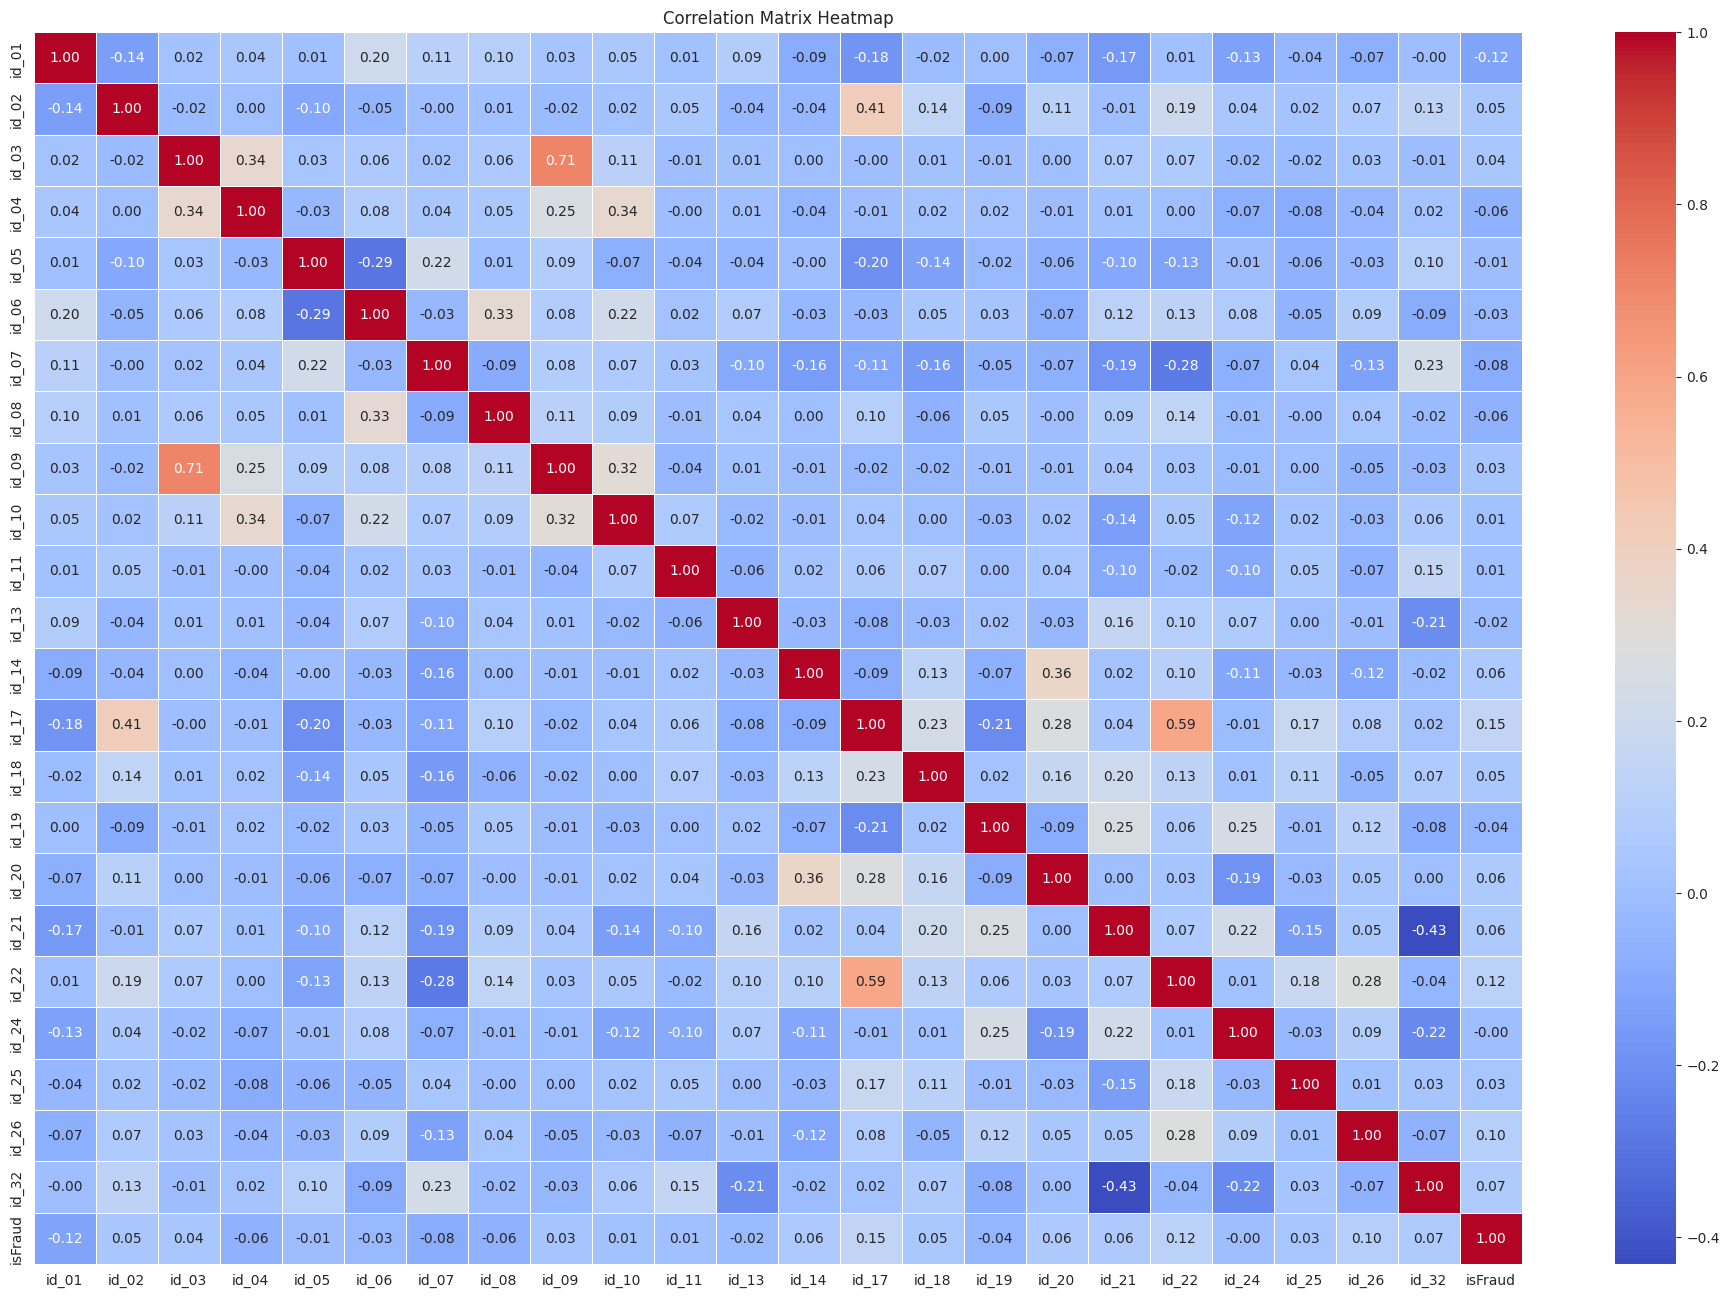

In [72]:
columns = [f'id_{i:02d}' for i in range(1, 12)] + ["id_13"] + ["id_14"] + ["id_17"] + ["id_18"] + ["id_19"] + ["id_20"] + ["id_21"] + ["id_22"] + ["id_24"] + ["id_25"] + ["id_26"] + ["id_32"] + ["isFraud"]

correlation_matrix = merged_data[columns].corr()

plt.figure(figsize=(24, 16))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)

plt.title("Correlation Matrix Heatmap")
plt.show()

In [73]:
excluded_cols = {"id_13", "id_14", "id_17", "id_18", "id_19", "id_20",
                 "id_21", "id_22", "id_24", "id_25", "id_26", "id_32"}

for col_name in [col for col in merged_data.loc[:, "id_12":"id_38"].columns if col not in excluded_cols]:
    counts = merged_data[col_name].value_counts(dropna=False)
    normalized_counts = merged_data[col_name].value_counts(dropna=False, normalize=True)

    result = pd.DataFrame({
        col_name: counts.index,
        "Count": counts.values,
        "Percentage": normalized_counts.values * 100
    })

    print(f"\nColumn: {col_name}\n")
    print(result)
    print("\n" + "-"*50 + "\n")


Column: id_12

      id_12   Count  Percentage
0       NaN  446305   75.576000
1  NotFound  123025   20.832698
2     Found   21208    3.591301

--------------------------------------------------


Column: id_15

     id_15   Count  Percentage
0      NaN  449553   76.126007
1    Found   67728   11.468864
2      New   61612   10.433198
3  Unknown   11645    1.971931

--------------------------------------------------


Column: id_16

      id_16   Count  Percentage
0       NaN  461198   78.097938
1     Found   66324   11.231115
2  NotFound   63016   10.670948

--------------------------------------------------


Column: id_23

                  id_23   Count  Percentage
0                   NaN  585369   99.124696
1  IP_PROXY:TRANSPARENT    3489    0.590817
2    IP_PROXY:ANONYMOUS    1071    0.181360
3       IP_PROXY:HIDDEN     609    0.103126

--------------------------------------------------


Column: id_27

      id_27   Count  Percentage
0       NaN  585369   99.124696
1     Found  

id_23 looks interesting!


                   id_23   Count  Percentage
0                   NaN  585369   99.124696
1  IP_PROXY:TRANSPARENT    3489    0.590817
2    IP_PROXY:ANONYMOUS    1071    0.181360
3       IP_PROXY:HIDDEN     609    0.103126 




<Figure size 800x600 with 0 Axes>

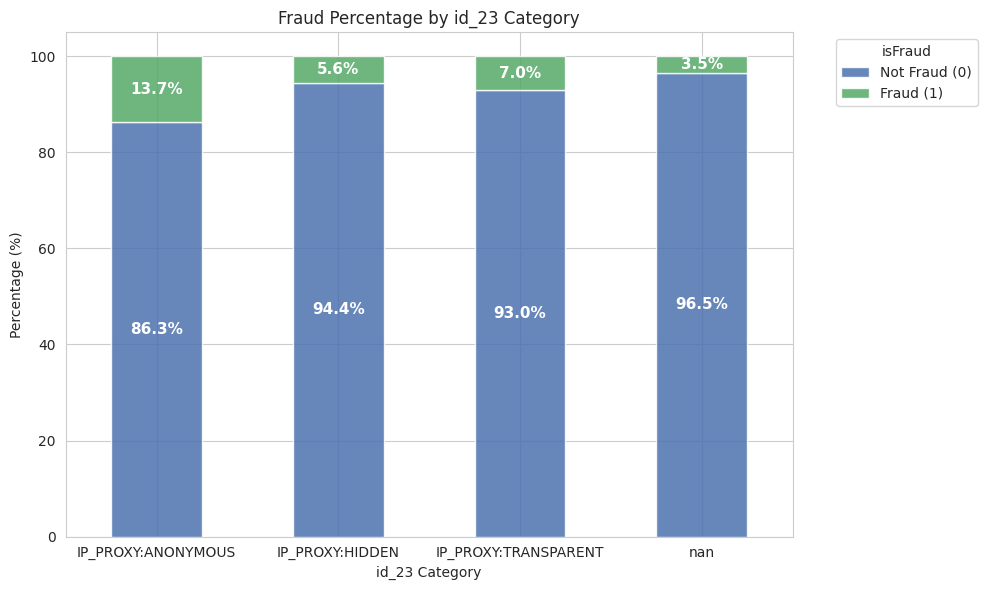

In [74]:
col_name = "id_23"

counts = merged_data[col_name].value_counts(dropna=False)
normalized_counts = merged_data[col_name].value_counts(dropna=False, normalize=True)

result = pd.DataFrame({
    col_name: counts.index,
    "Count": counts.values,
    "Percentage": normalized_counts.values * 100
})

print("\n",result,"\n\n")



merged_data['_id_23_str'] = merged_data['id_23'].astype(str)


counts = merged_data.groupby(['_id_23_str', 'isFraud']).size().unstack(fill_value=0)
counts['Total'] = counts.sum(axis=1)
counts[0] = (counts[0] / counts['Total']) * 100
counts[1] = (counts[1] / counts['Total']) * 100
counts.drop(columns=['Total'], inplace=True)

plt.figure(figsize=(8, 6))
ax = counts.plot(kind='bar', stacked=True, color=["#4c72b0", "#55a868"], alpha=0.85, figsize=(10, 6))

for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2, p.get_y() + height / 2),
                    ha='center', va='center', fontsize=11, color='white', fontweight='bold')

plt.xlabel("id_23 Category")
plt.ylabel("Percentage (%)")
plt.title("Fraud Percentage by id_23 Category")

plt.legend(title="isFraud", labels=["Not Fraud (0)", "Fraud (1)"], bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

merged_data.drop(columns=['_id_23_str'], inplace=True)

99% of values are NULL, but we can also see that the percents of frauds is different between the columns.

we wont remove those columns and we will let the model choose.

### V's

These are unknown transaction columns, and it's hard to explore them dou to the huge numbers of features (339).

In [75]:
columns = [f"V{i}" for i in range(1, 340)] + ["isFraud"]

correlation_matrix = merged_data[columns].corr()
correlation_matrix

V1        V2        V3        V4        V5        V6        V7  \
V1       1.000000  0.032175  0.024832  0.014216  0.013620  0.032285  0.026017   
V2       0.032175  1.000000  0.772979  0.318492  0.305451  0.621415  0.496882   
V3       0.024832  0.772979  1.000000  0.243617  0.353723  0.472496  0.546837   
V4       0.014216  0.318492  0.243617  1.000000  0.915161  0.279550  0.221581   
V5       0.013620  0.305451  0.353723  0.915161  1.000000  0.261448  0.294415   
...           ...       ...       ...       ...       ...       ...       ...   
V336          NaN       NaN       NaN       NaN       NaN       NaN       NaN   
V337          NaN       NaN       NaN       NaN       NaN       NaN       NaN   
V338          NaN       NaN       NaN       NaN       NaN       NaN       NaN   
V339          NaN       NaN       NaN       NaN       NaN       NaN       NaN   
isFraud  0.001045  0.019884  0.049269  0.012613  0.036907  0.010557  0.023495   

               V8        V9       V10  ...      V331      V332      V333  \
V1       0.040823  0.034011  0.006574  ...       NaN       NaN       NaN   
V2       0.732677  0.618537  0.036838  ...       NaN       NaN       NaN   
V3       0.556448  0.653037 -0.005312  ...       NaN       NaN       NaN   
V4       0.325820  0.273158 -0.013177  ...       NaN       NaN       NaN   
V5       0.308669  0.354219 -0.035422  ...       NaN       NaN       NaN   
...           ...       ...       ...  ...       ...       ...       ...   
V336          NaN       NaN       NaN  ...  0.389508  0.410970  0.425812   
V337          NaN       NaN       NaN  ...  0.309989  0.259108  0.295698   
V338          NaN       NaN       NaN  ...  0.752075  0.800310  0.823754   
V339          NaN       NaN       NaN  ...  0.572187  0.579686  0.620566   
isFraud  0.016047  0.037921 -0.074657  ... -0.021982 -0.023468 -0.024134   

             V334      V335      V336      V337      V338      V339   isFraud  
V1            NaN       NaN       NaN       NaN       NaN       NaN  0.001045  
V2            NaN       NaN       NaN       NaN       NaN       NaN  0.019884  
V3            NaN       NaN       NaN       NaN       NaN       NaN  0.049269  
V4            NaN       NaN       NaN       NaN       NaN       NaN  0.012613  
V5            NaN       NaN       NaN       NaN       NaN       NaN  0.036907  
...           ...       ...       ...       ...       ...       ...       ...  
V336     0.906312  0.914130  1.000000  0.118221  0.353950  0.274392 -0.002402  
V337     0.041888  0.166021  0.118221  1.000000  0.742652  0.907378 -0.005702  
V338     0.054911  0.552533  0.353950  0.742652  1.000000  0.940009 -0.019356  
V339     0.055864  0.411911  0.274392  0.907378  0.940009  1.000000 -0.014663  
isFraud -0.000451 -0.005456 -0.002402 -0.005702 -0.019356 -0.014663  1.000000  

[340 rows x 340 columns]

We will find the top 100 highest correlated features (in absulute values, because -0.9 is also good for us)..

In [76]:
abs_correlation_matrix = correlation_matrix.abs()

row_avgs = abs_correlation_matrix.mean(axis=1)

sorted_avgs = row_avgs.sort_values(ascending=False)

print("\nAverage of absolute correlations (sorted):\n", sorted_avgs)


Average of absolute correlations (sorted):
 V333    0.334474
V324    0.333706
V323    0.331843
V332    0.331014
V329    0.330965
          ...   
V65     0.025740
V1      0.018840
V240    0.010384
V241    0.009336
V305    0.006375
Length: 340, dtype: float64


In [77]:
# Get the top 50 features with the highest average absolute correlation
top_50_features = row_avgs.nlargest(50).index

# Extract the original correlation matrix for these features
top_50_correlation_matrix = correlation_matrix.loc[top_50_features, top_50_features]

# Restore the diagonal to 1
np.fill_diagonal(top_50_correlation_matrix.values, 1)

# Print the result
# print("\nTop 50 Features' Original Correlation Matrix:\n")
# top_50_correlation_matrix

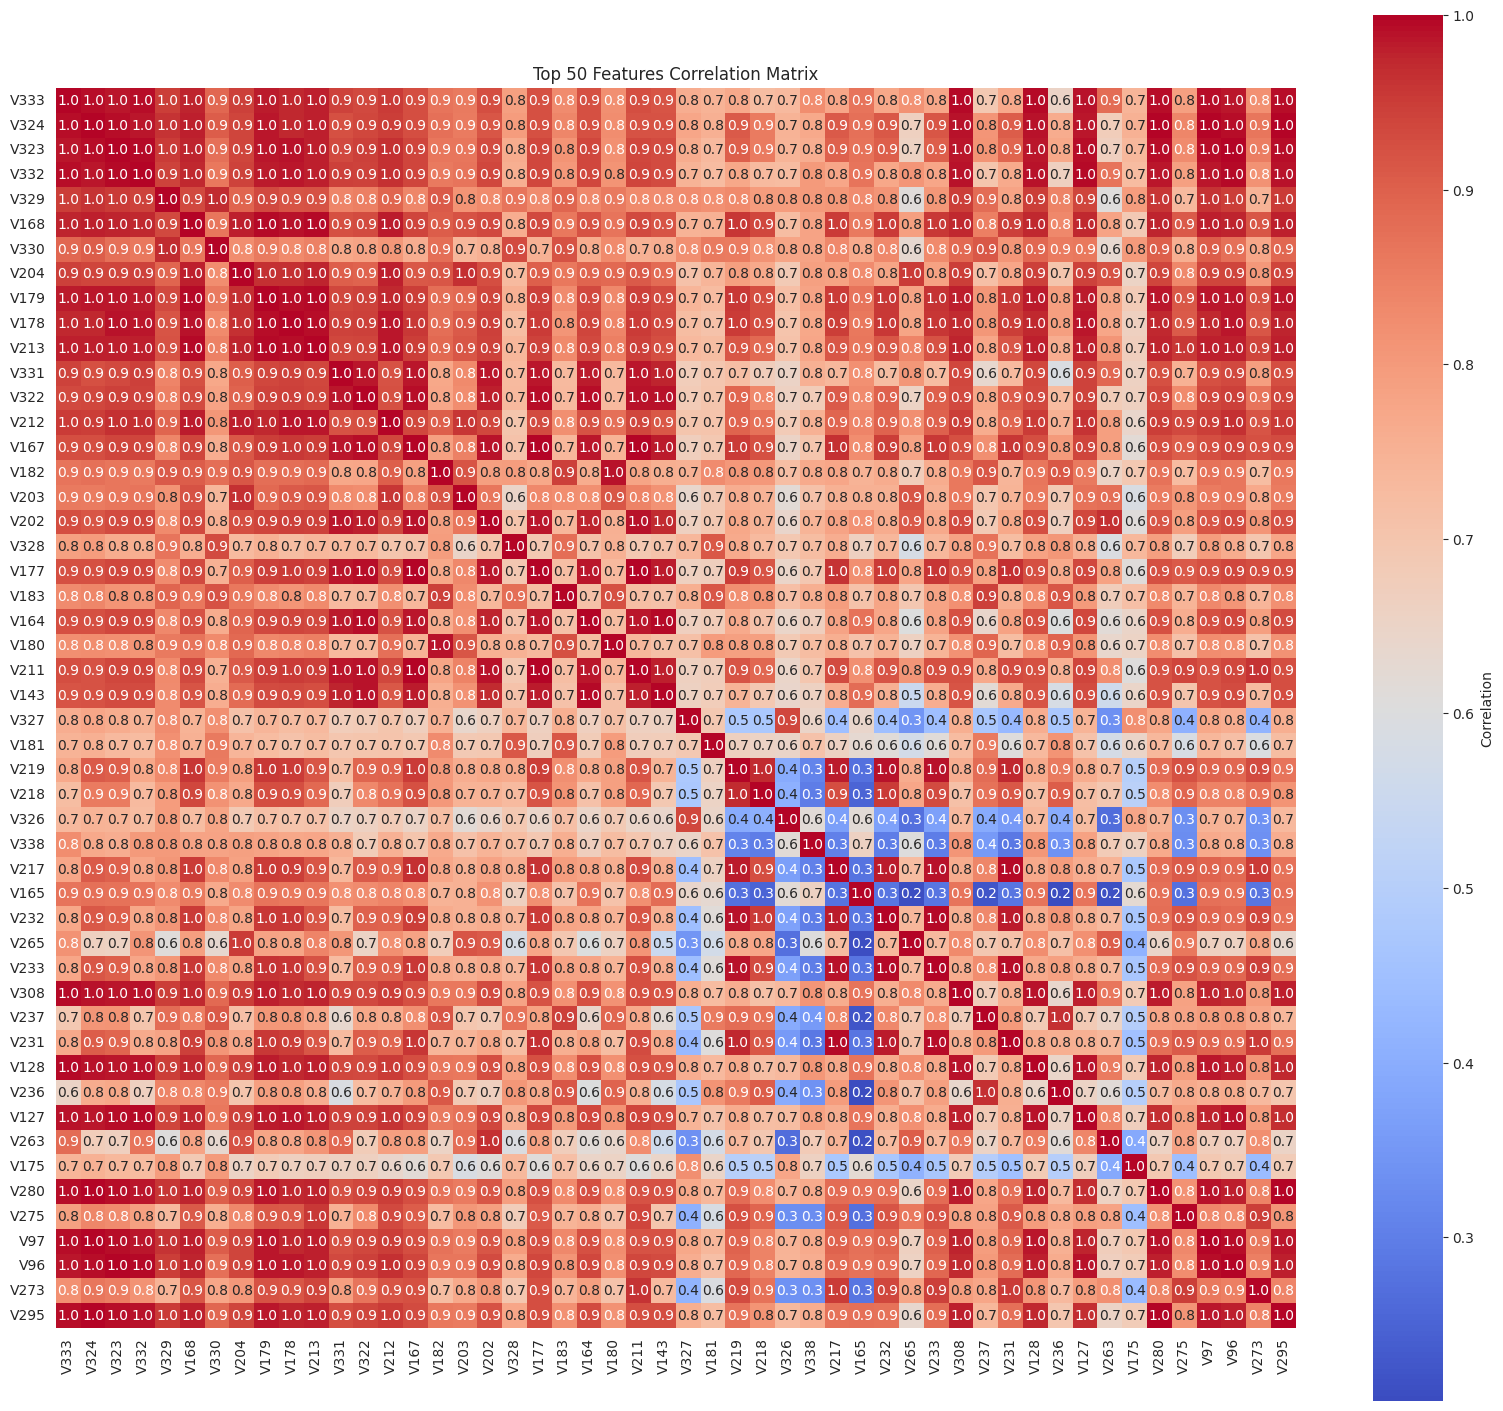

In [78]:
# Create the heatmap for the top 50 correlation matrix
plt.figure(figsize=(20, 18))  # Set the figure size
sns.heatmap(top_50_correlation_matrix, annot=True, fmt='.1f', cmap='coolwarm',
            cbar_kws={'label': 'Correlation'}, square=True)

# Show the plot
plt.title('Top 50 Features Correlation Matrix')
plt.show()

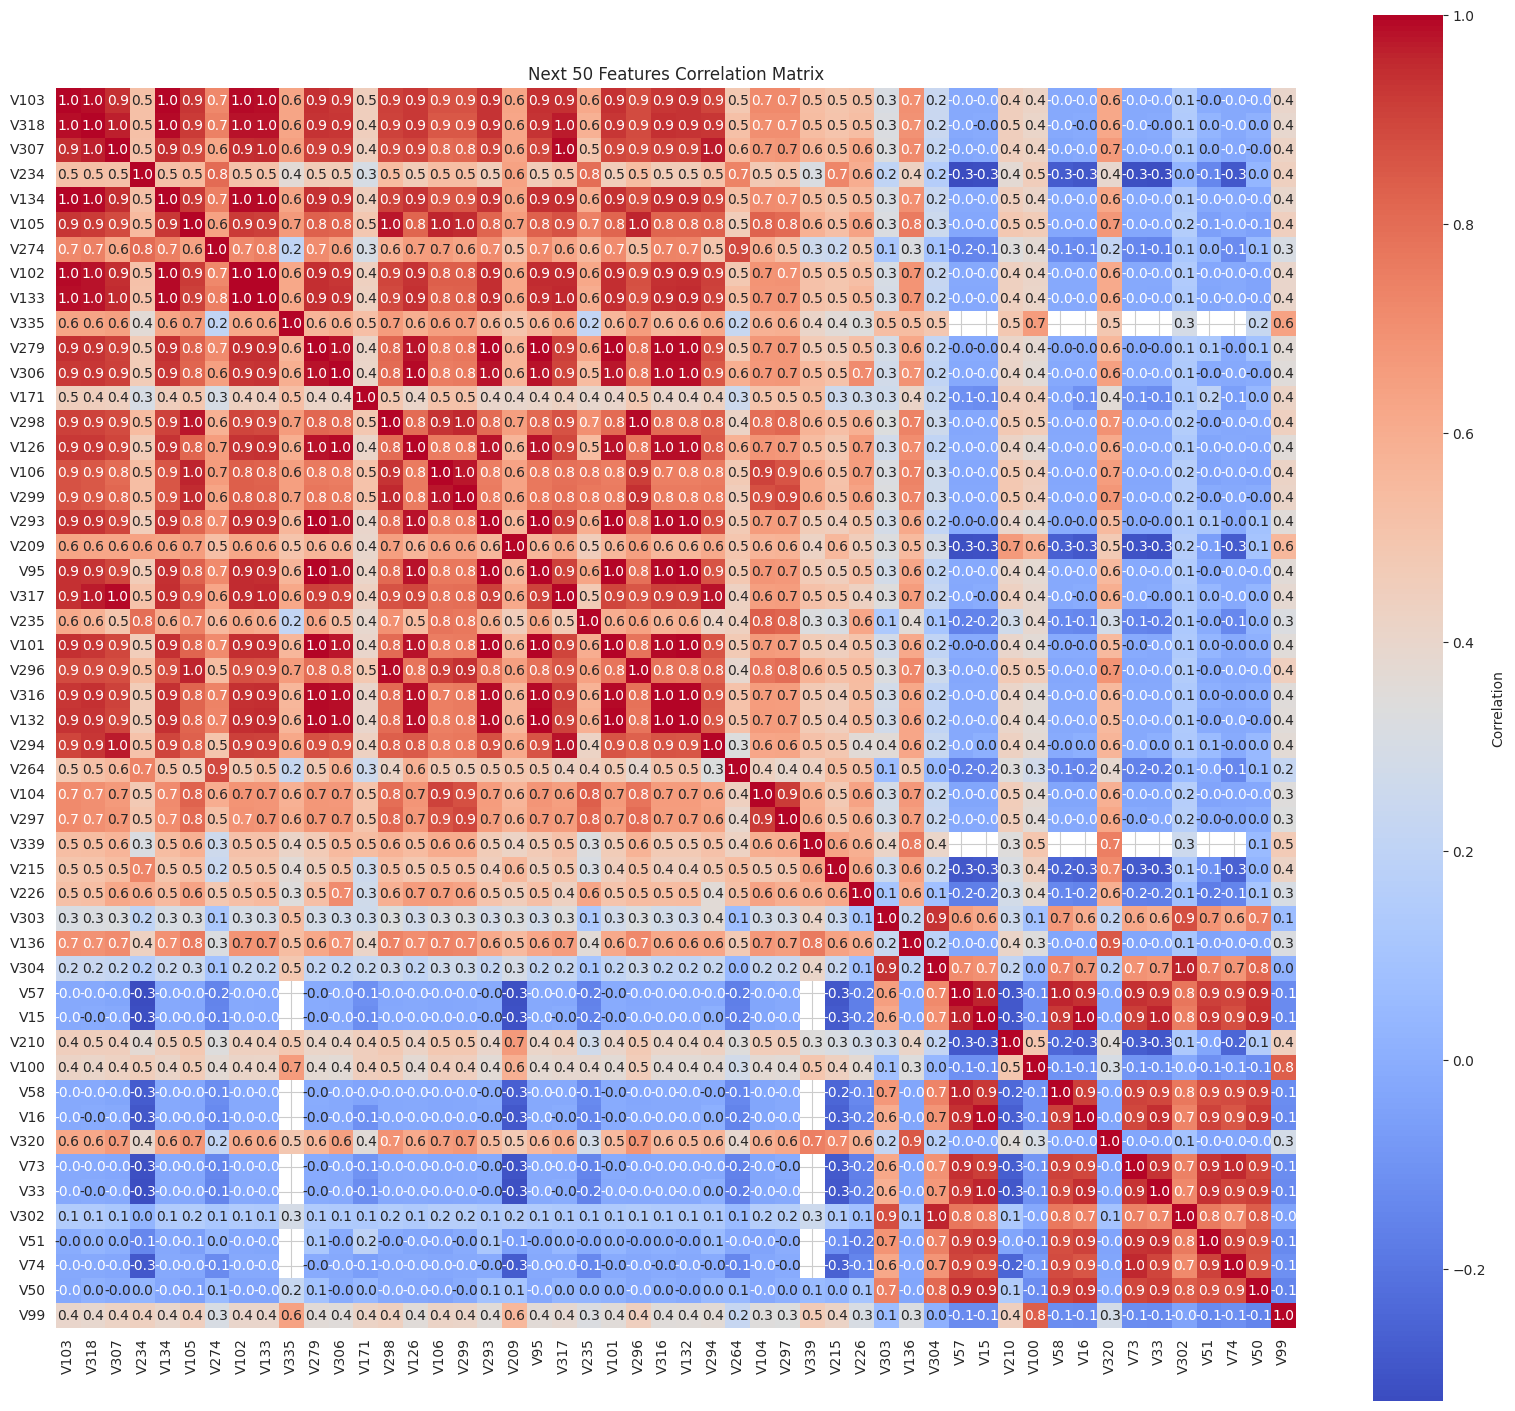

In [79]:
# Get the next 50 features with the highest average absolute correlation (after the top 50)
next_50_features = row_avgs.nlargest(100).iloc[50:].index

# Extract the original correlation matrix for these next 50 features
next_50_correlation_matrix = correlation_matrix.loc[next_50_features, next_50_features]

# Restore the diagonal to 1
np.fill_diagonal(next_50_correlation_matrix.values, 1)

# Create the heatmap for the next 50 correlation matrix
plt.figure(figsize=(20, 18))  # Set the figure size
sns.heatmap(next_50_correlation_matrix, annot=True, fmt='.1f', cmap='coolwarm',
            cbar_kws={'label': 'Correlation'}, square=True)

# Show the plot
plt.title('Next 50 Features Correlation Matrix')
plt.show()

We succeed to find the top 100 high correlated features!

Maybe it will be meaningful when we will choose the features for our model.

### other columns

After testing the baseline model, we looked for more features that would increase the model's performance.

In [80]:
# Transaction amount by card
merged_data['TransactionAmt_by_card1'] = merged_data.groupby('card1')['TransactionAmt'].transform('sum')
merged_data['TransactionAmt_by_card2'] = merged_data.groupby('card2')['TransactionAmt'].transform('sum')
merged_data['TransactionAmt_by_card3'] = merged_data.groupby('card3')['TransactionAmt'].transform('sum')
merged_data['TransactionAmt_by_card5'] = merged_data.groupby('card5')['TransactionAmt'].transform('sum')

# Number of transactions card
merged_data['TransactionCount_by_card1'] = merged_data.groupby('card1')['TransactionID'].transform('count')
merged_data['TransactionCount_by_card2'] = merged_data.groupby('card2')['TransactionID'].transform('count')
merged_data['TransactionCount_by_card3'] = merged_data.groupby('card3')['TransactionID'].transform('count')
merged_data['TransactionCount_by_card5'] = merged_data.groupby('card5')['TransactionID'].transform('count')

# Transaction Amount/Number of Transactions Ratio
merged_data['AvgTransactionAmt_by_card1'] = merged_data['TransactionAmt_by_card1'] / merged_data['TransactionCount_by_card1']
merged_data['AvgTransactionAmt_by_card2'] = merged_data['TransactionAmt_by_card2'] / merged_data['TransactionCount_by_card2']
merged_data['AvgTransactionAmt_by_card3'] = merged_data['TransactionAmt_by_card3'] / merged_data['TransactionCount_by_card3']
merged_data['AvgTransactionAmt_by_card5'] = merged_data['TransactionAmt_by_card5'] / merged_data['TransactionCount_by_card5']

# Time difference between transactions for a card
merged_data['TransactionDT_diff_by_card1'] = merged_data.groupby('card1')['TransactionDT'].diff()
merged_data['TransactionDT_diff_by_card2'] = merged_data.groupby('card2')['TransactionDT'].diff()
merged_data['TransactionDT_diff_by_card3'] = merged_data.groupby('card3')['TransactionDT'].diff()
merged_data['TransactionDT_diff_by_card5'] = merged_data.groupby('card5')['TransactionDT'].diff()


In [81]:
# New feature – the decimal part of the transaction amount
merged_data['TransactionAmt_decimal'] = merged_data['TransactionAmt'] - np.floor(merged_data['TransactionAmt'])


### Multicollinearity

now we will check multicollinearity of the features and choose the feature with the higher correlation with the label

In [82]:
numeric_cols = merged_data.select_dtypes(include=[np.number]).columns


corr_matrix = merged_data[numeric_cols].corr().abs()

# Select the upper triangle of the correlation matrix (to avoid duplicate comparisons)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find pairs of columns with correlation above 0.85
correlated_pairs = [(col, upper[col].idxmax()) for col in upper.columns if any(upper[col] > 0.85)]

fraud_corr = merged_data[numeric_cols].corr()["isFraud"].abs()


columns_to_remove = set()

for col1, col2 in correlated_pairs:
    # Check which column has the lower correlation with isFraud and mark it for removal
    if fraud_corr[col1] > fraud_corr[col2]:
        columns_to_remove.add(col2)
    else:
        columns_to_remove.add(col1)
columns_to_remove.discard('TransactionID')
columns_to_remove.discard('TransactionDT')

merged_data_reduced = merged_data.drop(columns=columns_to_remove)


print(f"Removed {len(columns_to_remove)} highly correlated features:")
print(columns_to_remove)
print(f"\nRemaining columns: {merged_data_reduced.shape[1]}")


Removed 197 highly correlated features:
{'V59', 'V13', 'V36', 'V219', 'V104', 'V44', 'D4new', 'V133', 'V146', 'V18', 'V306', 'V339', 'V14', 'V311', 'V263', 'V307', 'V119', 'D6', 'V95', 'V148', 'V64', 'V291', 'V60', 'C4', 'V49', 'V159', 'V88', 'V255', 'V250', 'V268', 'TransactionAmt_by_card3', 'V177', 'V233', 'D5new', 'V231', 'V161', 'V217', 'C1', 'V243', 'V28', 'V188', 'V152', 'V194', 'V248', 'V288', 'V191', 'D10', 'null_status', 'V22', 'V10', 'D1', 'C10', 'V126', 'V242', 'V157', 'V206', 'V215', 'V85', 'V326', 'D11', 'V69', 'V316', 'V16', 'V139', 'V302', 'V82', 'V144', 'V200', 'V300', 'V317', 'V50', 'V334', 'V84', 'C7', 'V267', 'V186', 'V253', 'TransactionCount_by_card3', 'V181', 'V100', 'V63', 'V106', 'V265', 'V325', 'V37', 'TransactionCount_by_card2', 'V216', 'V214', 'D15', 'V279', 'V11', 'C6', 'V42', 'V128', 'V272', 'V195', 'V246', 'V15', 'V274', 'V29', 'V168', 'V327', 'V17', 'V58', 'V319', 'V132', 'D12new', 'V164', 'V275', 'V70', 'V190', 'V30', 'V136', 'V245', 'V103', 'V4', 'V31', 

### Outliers

In [83]:
#merged_data_reduced = pd.read_csv("data_after_EDA.csv")

In [84]:
# Identify numerical columns
numerical_columns = merged_data_reduced.select_dtypes(include=['number'])

# Compute Q1, Q3, and IQR
Q1 = numerical_columns.quantile(0.25)
Q3 = numerical_columns.quantile(0.75)
IQR = Q3 - Q1

# Identify outliers
outliers = (numerical_columns < (Q1 - 1.5 * IQR)) | (numerical_columns > (Q3 + 1.5 * IQR))

# Compute number and percentage of outliers
outliers_count = outliers.sum()
outliers_percentage = (outliers_count / len(merged_data_reduced)) * 100

# Compute fraud percentage in outlier rows
fraud_percentage = (merged_data_reduced[outliers.any(axis=1)]['isFraud'].sum() / len(merged_data_reduced[outliers.any(axis=1)])) * 100

# Create DataFrame with the summary
outliers_summary = pd.DataFrame({
    'Column Name': outliers_count.index,
    'Number of Outliers': outliers_count.values,
    'Outliers Percentage': outliers_percentage.values
})

# Display fraud percentage among outliers
print(f"Fraud percentage among detected outliers: {fraud_percentage:.2f}%")




Fraud percentage among detected outliers: 3.74%


#### Keeping Outliers in the Dataset

The fraud percentage among outliers is **3.74%**, which may be higher than the overall fraud rate.  

##### Why keep them?
- **Potential fraud patterns** – Outliers may capture rare but meaningful fraud cases.  
- **Avoid losing critical data** – Fraudulent transactions can be naturally atypical.  
- **Better model performance** – Retaining outliers helps detect abnormal behavior.  

Removing them could reduce the model’s ability to identify certain fraud cases.


### Missing Values

In [85]:
nan_percentage = merged_data_reduced.isna().mean() * 100

nan_percentage_df = (
    pd.DataFrame({
        "Column": nan_percentage.index,
        "NaN Percentage": nan_percentage.values
    })  # Filter for columns with more than 80% NaNs
    .sort_values(by="NaN Percentage", ascending=False).reset_index(drop=True)
    .reset_index(drop=True)
)

nan_percentage_df

Column  NaN Percentage
0                     id_24       99.196157
1                     id_25       99.130962
2                     id_07       99.127067
3                     id_08       99.127067
4                     id_21       99.126390
..                      ...             ...
270                   card1        0.000000
271               ProductCD        0.000000
272          TransactionAmt        0.000000
273           TransactionDT        0.000000
274  TransactionAmt_decimal        0.000000

[275 rows x 2 columns]

In [86]:
numeric_cols = merged_data_reduced.select_dtypes(include=[float, int]).columns

# Compute correlation with isFraud only for numeric columns
correlation_with_target = merged_data_reduced[numeric_cols].corr()["isFraud"].abs()

nan_percentage_df["Correlation with isFraud"] = nan_percentage_df["Column"].map(correlation_with_target)

# Calculate the percentage of columns with more than 60% missing values
total_columns = len(nan_percentage_df)
columns_above_60 = len(nan_percentage_df[nan_percentage_df["NaN Percentage"] > 60])
percentage_above_60 = (columns_above_60 / total_columns) * 100

print(nan_percentage_df)

print(f"\nPercentage of columns with more than 60% missing values: {percentage_above_60:.2f}%")


                     Column  NaN Percentage  Correlation with isFraud
0                     id_24       99.196157                  0.001905
1                     id_25       99.130962                  0.034045
2                     id_07       99.127067                  0.084768
3                     id_08       99.127067                  0.057489
4                     id_21       99.126390                  0.063544
..                      ...             ...                       ...
270                   card1        0.000000                  0.013639
271               ProductCD        0.000000                       NaN
272          TransactionAmt        0.000000                  0.011763
273           TransactionDT        0.000000                  0.013103
274  TransactionAmt_decimal        0.000000                  0.048755

[275 rows x 3 columns]

Percentage of columns with more than 60% missing values: 47.64%


In [87]:
high_missing_cols = nan_percentage_df[nan_percentage_df["NaN Percentage"] > 60]

# Identify columns with high missing values but strong correlation with isFraud
important_high_missing_cols = high_missing_cols[high_missing_cols["Correlation with isFraud"] > 0.05]

# Identify columns with high missing values but low correlation (to be removed)
low_importance_cols = high_missing_cols[high_missing_cols["Correlation with isFraud"] <= 0.05]

columns_to_remove = low_importance_cols["Column"].tolist()

print(f"Total columns analyzed: {len(nan_percentage_df)}")
print(f"Columns recommended for removal: {len(columns_to_remove)} ({(len(columns_to_remove) / len(nan_percentage_df)) * 100:.2f}% of total)")
print(f"Columns with high missing values but strong correlation (consider keeping): {len(important_high_missing_cols)}")

merged_data_reduced = merged_data_reduced.drop(columns=columns_to_remove, errors="ignore")

print(f"\nUpdated dataset shape after removal: {merged_data_reduced.shape}")


Total columns analyzed: 275
Columns recommended for removal: 58 (21.09% of total)
Columns with high missing values but strong correlation (consider keeping): 56

Updated dataset shape after removal: (590538, 217)



During our analysis, we identified columns with **more than 60% missing values**.  
Instead of automatically removing all of them, we evaluated their correlation with `isFraud`.  

- **Columns with low correlation** (below 0.05) were removed, as they do not contribute to the model.  
- **Columns with high correlation** (above 0.05) were kept, since they may hold valuable predictive information.  

In the next step, we can decide **how to impute the missing values** in these important columns using techniques such as:


#### Numeric Columns

In [88]:

num_cols = merged_data_reduced.select_dtypes(include=[float, int]).columns
median_imputer = SimpleImputer(strategy="median")
merged_data_reduced[num_cols] = median_imputer.fit_transform(merged_data_reduced[num_cols])


We chose to fill missing values using the **median (`median`)** because it is the **most stable and reliable** method for large datasets.  

- **Less sensitive to outliers** compared to the mean (`mean`), which can be skewed by extreme values.  
- **Preserves the overall structure of the data** and prevents unwanted bias.  
- **Faster than computational methods like `KNN Imputer`**, making it suitable for large-scale data.  

The goal of this imputation is to ensure data consistency while minimizing distortions that could negatively impact the model.

#### Categorical Columns

In [89]:
categorical_cols = merged_data_reduced.select_dtypes(exclude=[float, int]).columns.tolist()

print(f"Categorical columns ({len(categorical_cols)} found):")
print(categorical_cols)

# Calculate missing values percentage for categorical columns
missing_categorical = merged_data_reduced[categorical_cols].isnull().mean() * 100

missing_categorical_sorted = missing_categorical[missing_categorical > 0].sort_values(ascending=False)

print("\nCategorical columns with missing values:")
print(missing_categorical_sorted)


Categorical columns (34 found):
['ProductCD', 'card4', 'card6', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'Transaction_Hour', 'Transaction_Weekday', 'AmountType', 'fraud_category_P_email', 'fraud_category_R_email']

Categorical columns with missing values:
id_23         99.124696
id_27         99.124696
id_33         87.589452
id_30         86.865367
id_34         86.824726
DeviceInfo    79.905442
id_16         78.097938
id_31         76.245051
DeviceType    76.155641
id_29         76.127192
id_28         76.127192
id_38         76.126007
id_37         76.126007
id_15         76.126007
id_36         76.126007
id_35         76.126007
id_12         75.576000
M5            59.349271
M7            58.635515
M9            58.633314
M8            58.633314
M4            47.658576
M3            45.907291
M2            45

In [90]:
missing_threshold = 70

# Identify columns that exceed the missing value threshold
columns_to_remove = nan_percentage_df[nan_percentage_df["NaN Percentage"] > missing_threshold]["Column"].tolist()

# Drop these columns from the dataset
merged_data_reduced = merged_data_reduced.drop(columns=columns_to_remove, errors="ignore")

# Print summary
print(f"Removed {len(columns_to_remove)} columns with more than {missing_threshold}% missing values.")
print(f"Updated dataset shape: {merged_data_reduced.shape}")


Removed 131 columns with more than 70% missing values.
Updated dataset shape: (590538, 144)


To maintain data quality and prevent biases in the model, we decided to remove columns where **more than 70% of the values are missing**.  
Columns with such a high percentage of missing data are unlikely to provide reliable insights and may introduce unnecessary noise.

Among the removed columns were **`DeviceInfo` and `DeviceType`**, which had a significant proportion of missing values.  
However, since device-related information could still be relevant, we created an additional feature (`all_4_is_nan`)  
to indicate whether this information was missing across all relevant columns.

With these removals, the dataset is now optimized, containing only meaningful and reliable features for further analysis and modeling.

In [91]:
categorical_cols = merged_data_reduced.select_dtypes(exclude=[float, int]).columns.tolist()

missing_categorical = merged_data_reduced[categorical_cols].isnull().mean() * 100

missing_categorical_sorted = missing_categorical[missing_categorical > 0].sort_values(ascending=False)

print("\nCategorical columns with missing values:")
print(missing_categorical_sorted)



Categorical columns with missing values:
M5       59.349271
M7       58.635515
M8       58.633314
M9       58.633314
M4       47.658576
M1       45.907291
M2       45.907291
M3       45.907291
M6       28.678595
card4     0.267045
card6     0.266029
dtype: float64


In [92]:
merged_data_reduced.dropna(subset=['card4', 'card6'],inplace=True)

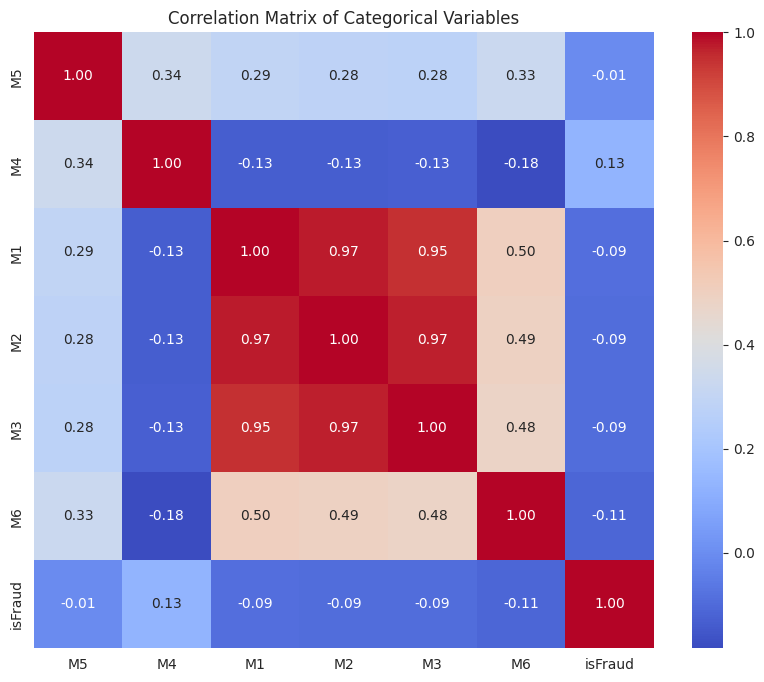

In [93]:
categorical_cols = ["M5",  "M4", "M1", "M2", "M3", "M6"]

encoded_data = merged_data_reduced[categorical_cols].apply(lambda x: x.astype('category').cat.codes)

# Add the target variable 'isFraud'
encoded_data["isFraud"] = merged_data_reduced["isFraud"]

# Compute correlation matrix
correlation_matrix = encoded_data.corr()


plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Categorical Variables")
plt.show()

In [94]:
columns_to_remove = ["M2", "M3", "M5", "M7", "M8", "M9"]

merged_data_reduced = merged_data_reduced.drop(columns=columns_to_remove, errors="ignore")


columns_to_impute = ["M1", "M4", "M6"]

# Apply mode imputation
mode_imputer = SimpleImputer(strategy="most_frequent")
merged_data_reduced[columns_to_impute] = mode_imputer.fit_transform(merged_data_reduced[columns_to_impute])

# Verify that missing values are filled
missing_after_imputation = merged_data_reduced[columns_to_impute].isnull().sum()


print("Missing values after imputation:")
print(missing_after_imputation[missing_after_imputation > 0])

print(f"Updated dataset shape: {merged_data_reduced.shape}")

Missing values after imputation:
Series([], dtype: int64)
Updated dataset shape: (588955, 138)


##### Handling Missing Values in `M` Columns

We removed `M2`, `M3`, `M5`, `M7`, `M8`, and `M9` due to high missing percentages, strong correlation among themselves, and low correlation with `isFraud`. Keeping these features could introduce noise rather than useful information.

We retained `M1`, `M4`, and `M6` as they had fewer missing values and a slight correlation with `isFraud`. Missing values in these columns were filled using mode (most frequent value) imputation.

This ensures a cleaner dataset, reducing redundancy while preserving meaningful features for modeling.


## Model Implementation

In [95]:


# 1. One-Hot Encoding on categorial columns
categorical_columns = merged_data_reduced.select_dtypes(include=['object']).columns
X = merged_data_reduced.drop(columns=['isFraud', 'TransactionID'])
y = merged_data_reduced['isFraud']

X = pd.get_dummies(X, columns=categorical_columns, drop_first=True)

# 2. Division into training and validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.25, random_state=42)

# 3. Standard normalization on the numeric columns
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

### Without adding data

we will run many models as a baseline, and than choose with which one to go on.

In [96]:

# Compute scale_pos_weight for imbalanced data
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# Define custom class weights for models that support it
custom_class_weight = {0: 1, 1: scale_pos_weight}

models = {
    "XGBoost": xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42),
    "LightGBM": lgb.LGBMClassifier(is_unbalance=True, random_state=42),
    "Random Forest": RandomForestClassifier(class_weight=custom_class_weight, n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(class_weight=custom_class_weight, max_iter=1000, random_state=42),
    "CatBoost": cb.CatBoostClassifier(auto_class_weights="Balanced", verbose=0, random_state=42)  }

# Train and evaluate models
results = {}
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_val_scaled)

    print(f"\n{name} - Classification Report:")
    print(classification_report(y_val, y_pred))

    print(f"{name} - Confusion Matrix:")
    print(confusion_matrix(y_val, y_pred))

    results[name] = classification_report(y_val, y_pred, output_dict=True)

    y_pred_prob = model.predict_proba(X_val_scaled)[:, 1] if hasattr(model, "predict_proba") else y_pred
    roc_auc = roc_auc_score(y_val, y_pred_prob)
    print(f"{name} - ROC AUC Score: {roc_auc:.4f}")

    results[name] = {
        "Classification Report": classification_report(y_val, y_pred, output_dict=True),
        "ROC AUC Score": roc_auc
    }
print("\nModel comparison complete.")


Training XGBoost...

XGBoost - Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.92      0.96     85124
         1.0       0.29      0.83      0.43      3219

    accuracy                           0.92     88343
   macro avg       0.64      0.88      0.69     88343
weighted avg       0.97      0.92      0.94     88343

XGBoost - Confusion Matrix:
[[78467  6657]
 [  545  2674]]
XGBoost - ROC AUC Score: 0.9448
Training LightGBM...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 16392, number of negative: 454772
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.137752 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11815
[LightGBM] [Info] Number of data points in the train set: 471164, number of used features: 170
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.034790 -> initscore=-3.323003
[LightGBM] [Info] Start training from score -3.323003


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



LightGBM - Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.89      0.94     85124
         1.0       0.22      0.83      0.34      3219

    accuracy                           0.88     88343
   macro avg       0.60      0.86      0.64     88343
weighted avg       0.96      0.88      0.91     88343

LightGBM - Confusion Matrix:
[[75443  9681]
 [  549  2670]]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM - ROC AUC Score: 0.9315
Training Random Forest...

Random Forest - Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     85124
         1.0       0.95      0.43      0.59      3219

    accuracy                           0.98     88343
   macro avg       0.96      0.72      0.79     88343
weighted avg       0.98      0.98      0.97     88343

Random Forest - Confusion Matrix:
[[85044    80]
 [ 1823  1396]]
Random Forest - ROC AUC Score: 0.9450
Training Logistic Regression...

Logistic Regression - Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.78      0.87     85124
         1.0       0.11      0.75      0.20      3219

    accuracy                           0.78     88343
   macro avg       0.55      0.76      0.54     88343
weighted avg       0.96      0.78      0.85     88343

Logistic Regression - Confusion Matrix:
[[66525 18599]
 [  818  24

**Baseline Model Conclusions**

Following the performance comparison, **XGBoost** and **CatBoost** emerged as the most effective models.
They achieve a strong balance between correctly identifying minority-class instances (class 1) and maintaining high overall accuracy.

Both models demonstrated impressive **precision**, **recall**, and **ROC AUC** scores, indicating robust separation between the classes.
Consequently, **XGBoost** and **CatBoost** will be the primary focus for further refinement and tuning.


#####  Hyperparameter Tuning

In [97]:

# Define parameter grids for each model
param_grids = {
    "XGBoost": {
        "max_depth": [3, 5, 7],
        "learning_rate": [0.01, 0.04, 0.1],
        "n_estimators": [100, 300, 500],
        "scale_pos_weight": [scale_pos_weight]  # Keeps class balance
    },
    "CatBoost": {
        "depth": [4, 6, 8],
        "learning_rate": [0.01, 0.05, 0.1],
        "iterations": [100, 300, 500],
        "l2_leaf_reg": [3, 5, 7]
    }
}

# Define models with default parameters
models = {
    "XGBoost": xgb.XGBClassifier(random_state=42),
    "CatBoost": cb.CatBoostClassifier(verbose=0, random_state=42)
}

# Perform GridSearchCV for each model
best_models = {}
for name, model in models.items():
    print(f"Tuning {name}...")
    grid_search = RandomizedSearchCV(model, param_distributions=param_grids[name], scoring="f1", cv=3, n_jobs=2, n_iter=10)
    grid_search.fit(X_train_scaled, y_train)

    best_models[name] = grid_search.best_estimator_
    print(f"Best parameters for {name}: {grid_search.best_params_}")

# Evaluate best models
for name, model in best_models.items():
    print(f"\nEvaluating {name}...")
    y_pred = model.predict(X_val_scaled)
    print(classification_report(y_val, y_pred))
    print(confusion_matrix(y_val, y_pred))


print("\nHyperparameter tuning complete.")


Tuning XGBoost...
Best parameters for XGBoost: {'scale_pos_weight': 27.743533430941923, 'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.1}
Tuning CatBoost...


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters for CatBoost: {'learning_rate': 0.1, 'l2_leaf_reg': 5, 'iterations': 300, 'depth': 6}

Evaluating XGBoost...
              precision    recall  f1-score   support

         0.0       0.99      0.96      0.98     85124
         1.0       0.43      0.82      0.57      3219

    accuracy                           0.95     88343
   macro avg       0.71      0.89      0.77     88343
weighted avg       0.97      0.95      0.96     88343

[[81632  3492]
 [  576  2643]]

Evaluating CatBoost...
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     85124
         1.0       0.90      0.39      0.55      3219

    accuracy                           0.98     88343
   macro avg       0.94      0.70      0.77     88343
weighted avg       0.97      0.98      0.97     88343

[[84987   137]
 [ 1956  1263]]

Hyperparameter tuning complete.


In [98]:
# Evaluating best models after tuning the parameters

results = {}

for name, model in best_models.items():
    print(f"\nEvaluating {name}...")
    y_pred = model.predict(X_val_scaled)

    # Display performance report and confusion matrix    print(classification_report(y_val, y_pred))
    print(confusion_matrix(y_val, y_pred))

    # Calculate AUC-ROC for the model
    y_pred_prob = model.predict_proba(X_val_scaled)[:, 1] if hasattr(model, "predict_proba") else y_pred
    roc_auc = roc_auc_score(y_val, y_pred_prob)
    print(f"{name} - ROC AUC Score: {roc_auc:.4f}")

    # Saving results
    results[name] = {
        "Classification Report": classification_report(y_val, y_pred, output_dict=True),
        "ROC AUC Score": roc_auc
    }

print("\ncomplete.")



Evaluating XGBoost...
[[81632  3492]
 [  576  2643]]
XGBoost - ROC AUC Score: 0.9589

Evaluating CatBoost...
[[84987   137]
 [ 1956  1263]]
CatBoost - ROC AUC Score: 0.9142

complete.


In [99]:
# Evaluate best models
for name, model in best_models.items():
    print(f"\nEvaluating {name}...")
    y_pred = model.predict(X_val_scaled)
    print(classification_report(y_val, y_pred))
    print(confusion_matrix(y_val, y_pred))

print("\nHyperparameter tuning complete.")


Evaluating XGBoost...
              precision    recall  f1-score   support

         0.0       0.99      0.96      0.98     85124
         1.0       0.43      0.82      0.57      3219

    accuracy                           0.95     88343
   macro avg       0.71      0.89      0.77     88343
weighted avg       0.97      0.95      0.96     88343

[[81632  3492]
 [  576  2643]]

Evaluating CatBoost...
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     85124
         1.0       0.90      0.39      0.55      3219

    accuracy                           0.98     88343
   macro avg       0.94      0.70      0.77     88343
weighted avg       0.97      0.98      0.97     88343

[[84987   137]
 [ 1956  1263]]

Hyperparameter tuning complete.


### XGBoost Model Performance: Before vs. After Hyperparameter Tuning

#### Key Improvements:
- **Precision (Fraud)** increased from **0.29 to 0.43** (+14%), reducing false positives.
- **Recall (Fraud)** decreased a bit.
- **F1-Score (Fraud)** improved from **0.43 to 0.57** (+14%), balancing precision and recall.
- **False Positives (legitimate transactions misclassified as fraud)** dropped from **6657 to 3492**.
- **False Negatives (fraud cases missed)** remained almost the same (**545 → 576**).

#### Conclusion:
The tuned model is significantly more **precise**, reducing the number of incorrectly flagged transactions, while still maintaining a **high recall**. This means better fraud detection with fewer unnecessary blocks on legitimate transactions.

The model is now more **balanced**, making it a more effective tool for fraud detection.

### CatBoost Model Performance: Before vs. After Hyperparameter Tuning

#### Conclusion:
Despite improvements in **precision**, the tuned model still struggles with **recall**, missing more than half of the fraud cases. Since the primary goal is to detect fraud effectively, this trade-off is not ideal.

The model prioritizes reducing false positives, but at the cost of failing to identify a significant number of fraudulent transactions. Given this, **CatBoost may not be the best choice unless further tuning can significantly improve recall**.



### With data added

In [100]:


# 1. Creating new examples of fraud using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print(f"Original dataset shape: {X_train_scaled.shape}, Fraud cases: {sum(y_train)}")
print(f"Resampled dataset shape: {X_train_resampled.shape}, Fraud cases: {sum(y_train_resampled)}")

# 2. List of models with optimal parameters after replication
balanced_models = {
    "XGBoost": xgb.XGBClassifier(
        learning_rate=0.1, max_depth=7, n_estimators=500, scale_pos_weight=28.024781751619262, random_state=42
    ),
    "CatBoost": cb.CatBoostClassifier(
        depth=6, iterations=300, l2_leaf_reg=7, learning_rate=0.1, verbose=0, random_state=42
    )
}

# 3. Training and Performance Evaluation
results = {}
for name, model in balanced_models.items():
    print(f"Training {name} with SMOTE data...")
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_val_scaled)

    print(f"\n{name} - Classification Report:")
    print(classification_report(y_val, y_pred))

    print(f"{name} - Confusion Matrix:")
    print(confusion_matrix(y_val, y_pred))

# Calculate AUC-ROC for the model
    y_pred_prob = model.predict_proba(X_val_scaled)[:, 1] if hasattr(model, "predict_proba") else y_pred
    roc_auc = roc_auc_score(y_val, y_pred_prob)
    print(f"{name} - ROC AUC Score: {roc_auc:.4f}")

    results[name] = {
        "Classification Report": classification_report(y_val, y_pred, output_dict=True),
        "ROC AUC Score": roc_auc
    }

print("\nSMOTE Resampling & Model Training Complete.")


Original dataset shape: (471164, 174), Fraud cases: 16392.0
Resampled dataset shape: (909544, 174), Fraud cases: 454772.0
Training XGBoost with SMOTE data...

XGBoost - Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.93      0.96     85124
         1.0       0.32      0.84      0.46      3219

    accuracy                           0.93     88343
   macro avg       0.66      0.89      0.71     88343
weighted avg       0.97      0.93      0.94     88343

XGBoost - Confusion Matrix:
[[79354  5770]
 [  519  2700]]
XGBoost - ROC AUC Score: 0.9516
Training CatBoost with SMOTE data...

CatBoost - Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     85124
         1.0       0.79      0.41      0.54      3219

    accuracy                           0.97     88343
   macro avg       0.88      0.70      0.76     88343
weighted avg       0.97      0.97      0.97   

#### SMOTE Evaluation
No significant improvement was observed when comparing models trained with SMOTE versus those without. Therefore, we will proceed **without** SMOTE for model training.


#### test set

In [101]:
X_test_scaled = scaler.transform(X_test)

In [102]:
# Evaluating the best models after tuning the parameters

results = {}

for name, model in best_models.items():
    print(f"\nEvaluating {name}...")
    y_pred_test = model.predict(X_test_scaled)

    # Display performance report and confusion matrix
    print(classification_report(y_test, y_pred_test))
    print(confusion_matrix(y_test, y_pred_test))

    # Calculate AUC-ROC for the model
    y_pred_test_prob = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, "predict_proba") else y_pred_test
    roc_auc = roc_auc_score(y_test, y_pred_test_prob)
    print(f"{name} - ROC AUC Score: {roc_auc:.4f}")

    # Saving results
    results[name] = {
        "Classification Report": classification_report(y_test, y_pred_test, output_dict=True),
        "ROC AUC Score": roc_auc
    }

print("\ncomplete.")



Evaluating XGBoost...
              precision    recall  f1-score   support

         0.0       0.99      0.96      0.98     28437
         1.0       0.41      0.80      0.54      1011

    accuracy                           0.95     29448
   macro avg       0.70      0.88      0.76     29448
weighted avg       0.97      0.95      0.96     29448

[[27281  1156]
 [  204   807]]
XGBoost - ROC AUC Score: 0.9553

Evaluating CatBoost...
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     28437
         1.0       0.92      0.38      0.54      1011

    accuracy                           0.98     29448
   macro avg       0.95      0.69      0.76     29448
weighted avg       0.98      0.98      0.97     29448

[[28404    33]
 [  627   384]]
CatBoost - ROC AUC Score: 0.9031

complete.


After evaluating the model on the test set, we are satisfied with its performance in terms of ROC AUC Score and fraud detection. We will now proceed to apply the model to Kaggle test set, as the next step toward final submission.


### final models

model 1

In [103]:



model_XG_BOOST_NO_SMOTE = xgb.XGBClassifier(
    scale_pos_weight=27.743533430941923,
    n_estimators=500,
    max_depth=7,
    learning_rate=0.1,
    random_state=42,
    eval_metric="logloss"
)


model_XG_BOOST_NO_SMOTE.fit(
    X_train_scaled, y_train,
    eval_set=[(X_train_scaled, y_train), (X_val_scaled, y_val)],
    verbose=True
)


results = model_XG_BOOST_NO_SMOTE.evals_result()

train_logloss = results["validation_0"]["logloss"]
val_logloss = results["validation_1"]["logloss"]

[0]	validation_0-logloss:0.65439	validation_1-logloss:0.65441
[1]	validation_0-logloss:0.62218	validation_1-logloss:0.62222
[2]	validation_0-logloss:0.59376	validation_1-logloss:0.59407
[3]	validation_0-logloss:0.56936	validation_1-logloss:0.56974
[4]	validation_0-logloss:0.54871	validation_1-logloss:0.54906
[5]	validation_0-logloss:0.53023	validation_1-logloss:0.53081
[6]	validation_0-logloss:0.51408	validation_1-logloss:0.51471
[7]	validation_0-logloss:0.49899	validation_1-logloss:0.49977
[8]	validation_0-logloss:0.48624	validation_1-logloss:0.48706
[9]	validation_0-logloss:0.47448	validation_1-logloss:0.47544
[10]	validation_0-logloss:0.46421	validation_1-logloss:0.46532
[11]	validation_0-logloss:0.45485	validation_1-logloss:0.45607
[12]	validation_0-logloss:0.44553	validation_1-logloss:0.44694
[13]	validation_0-logloss:0.43808	validation_1-logloss:0.43966
[14]	validation_0-logloss:0.43051	validation_1-logloss:0.43217
[15]	validation_0-logloss:0.42419	validation_1-logloss:0.42595
[1

import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import xgboost as xgb


model_XG_BOOST_NO_SMOTE = xgb.XGBClassifier(
    scale_pos_weight=28.024781751619262,  
    n_estimators=500,
    max_depth=7,
    learning_rate=0.1,
    random_state=42,
    eval_metric="logloss"  
)


model_XG_BOOST_NO_SMOTE.fit(
    X_train_scaled, y_train,
    eval_set=[(X_train_scaled, y_train), (X_val_scaled, y_val)],
    verbose=True
)


results = model_XG_BOOST_NO_SMOTE.evals_result()

train_logloss = results["validation_0"]["logloss"]
val_logloss = results["validation_1"]["logloss"]

In [104]:
y_pred = model_XG_BOOST_NO_SMOTE.predict(X_val_scaled)
print("Classification Report (Validation):")
print(classification_report(y_val, y_pred))
print("Confusion Matrix (Validation):")
print(confusion_matrix(y_val, y_pred))

y_pred_model1_prob = model_XG_BOOST_NO_SMOTE.predict_proba(X_val_scaled)[:, 1]
roc_auc = roc_auc_score(y_val, y_pred_model1_prob)
print(f'Validation ROC AUC Score: {roc_auc:.4f}')

Classification Report (Validation):
              precision    recall  f1-score   support

         0.0       0.99      0.96      0.98     85124
         1.0       0.43      0.82      0.57      3219

    accuracy                           0.95     88343
   macro avg       0.71      0.89      0.77     88343
weighted avg       0.97      0.95      0.96     88343

Confusion Matrix (Validation):
[[81632  3492]
 [  576  2643]]
Validation ROC AUC Score: 0.9589


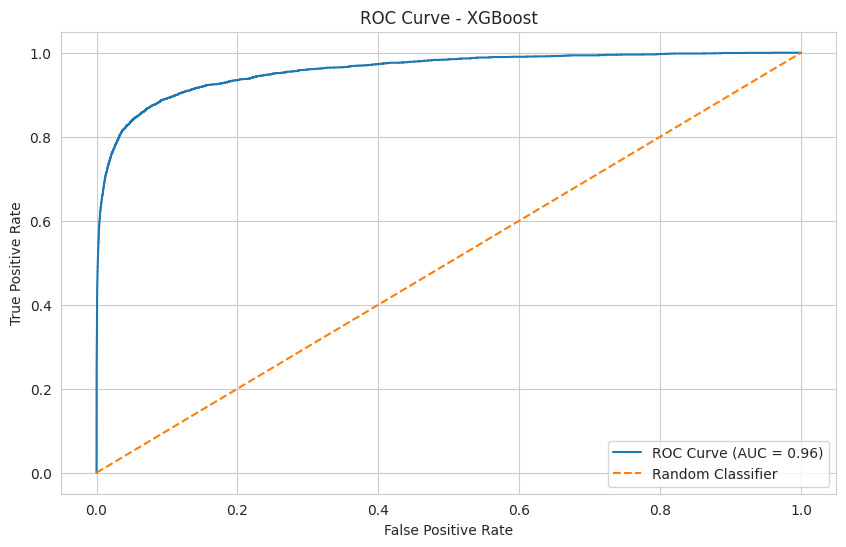

In [105]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_val, y_pred_model1_prob)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', label="Random Classifier")
plt.title("ROC Curve - XGBoost")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

The ROC curve (AUC = 0.96) indicates a high level of separation capability, maintaining consistently high true positive rates with relatively few false positives across different thresholds. This strong performance underscores the model’s effectiveness in distinguishing between fraudulent and legitimate transactions.


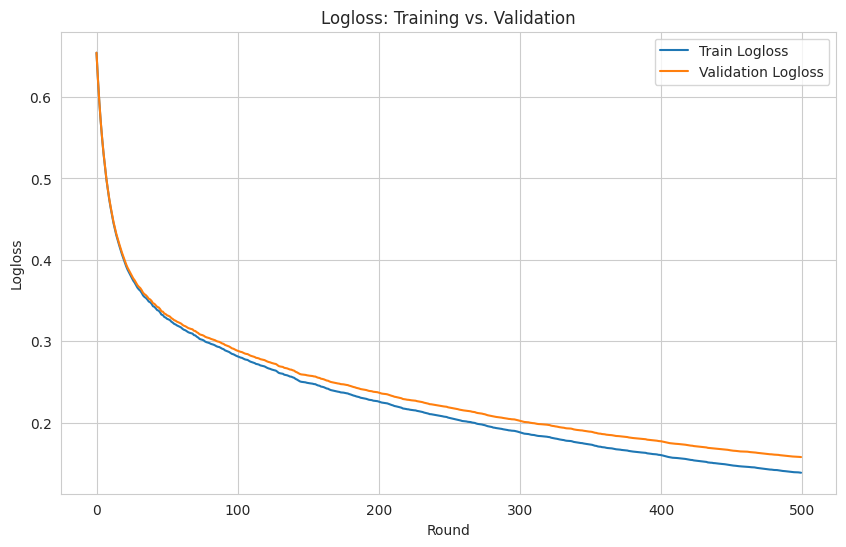

['XGboost_final_model.pkl']

In [106]:
plt.figure()
plt.plot(train_logloss, label="Train Logloss")
plt.plot(val_logloss, label="Validation Logloss")
plt.title("Logloss: Training vs. Validation")
plt.xlabel("Round")
plt.ylabel("Logloss")
plt.legend()
plt.show()

joblib.dump(model_XG_BOOST_NO_SMOTE, "XGboost_final_model.pkl")

The logloss curve shows a steep initial decline, reflecting rapid early learning. Both the training and validation curves track closely overall, indicating minimal overfitting. Even at higher rounds, the gap between them remains small, suggesting the model maintains good balance and consistent improvement.

**No Overfitting**  

model 2

In [107]:
from catboost import CatBoostClassifier
model_CAT_BOOST_NO_SMOTE = CatBoostClassifier(
    learning_rate=0.1,
    l2_leaf_reg=5,
    iterations=300,
    depth=8,
    eval_metric='Logloss',
    random_seed=42,
    verbose=True
)

model_CAT_BOOST_NO_SMOTE.fit(
    X_train_scaled, y_train,
    eval_set=(X_val_scaled, y_val)
)

y_pred = model_CAT_BOOST_NO_SMOTE.predict(X_val_scaled)

0:	learn: 0.5360600	test: 0.5367884	best: 0.5367884 (0)	total: 67.7ms	remaining: 20.2s
1:	learn: 0.4258440	test: 0.4267674	best: 0.4267674 (1)	total: 137ms	remaining: 20.3s
2:	learn: 0.3431275	test: 0.3443452	best: 0.3443452 (2)	total: 212ms	remaining: 21s
3:	learn: 0.2862546	test: 0.2876635	best: 0.2876635 (3)	total: 286ms	remaining: 21.2s
4:	learn: 0.2423985	test: 0.2440035	best: 0.2440035 (4)	total: 357ms	remaining: 21s
5:	learn: 0.2097371	test: 0.2116252	best: 0.2116252 (5)	total: 426ms	remaining: 20.9s
6:	learn: 0.1874081	test: 0.1893675	best: 0.1893675 (6)	total: 499ms	remaining: 20.9s
7:	learn: 0.1685158	test: 0.1706708	best: 0.1706708 (7)	total: 577ms	remaining: 21.1s
8:	learn: 0.1563685	test: 0.1586026	best: 0.1586026 (8)	total: 650ms	remaining: 21s
9:	learn: 0.1454012	test: 0.1477399	best: 0.1477399 (9)	total: 722ms	remaining: 20.9s
10:	learn: 0.1368178	test: 0.1392091	best: 0.1392091 (10)	total: 807ms	remaining: 21.2s
11:	learn: 0.1302160	test: 0.1326967	best: 0.1326967 (11)

In [108]:
results = model_CAT_BOOST_NO_SMOTE.get_evals_result()

train_logloss = results['learn']['Logloss']
val_logloss   = results['validation']['Logloss']

print("Classification Report (Validation):")
print(classification_report(y_val, y_pred))

print("Confusion Matrix (Validation):")
print(confusion_matrix(y_val, y_pred))

# ROC AUC
y_pred_model2_prob = model_CAT_BOOST_NO_SMOTE.predict_proba(X_val_scaled)[:, 1]
roc_auc = roc_auc_score(y_val, y_pred_model2_prob)
print(f'Validation ROC AUC Score: {roc_auc:.4f}')

Classification Report (Validation):
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     85124
         1.0       0.91      0.44      0.59      3219

    accuracy                           0.98     88343
   macro avg       0.95      0.72      0.79     88343
weighted avg       0.98      0.98      0.97     88343

Confusion Matrix (Validation):
[[84991   133]
 [ 1806  1413]]
Validation ROC AUC Score: 0.9269


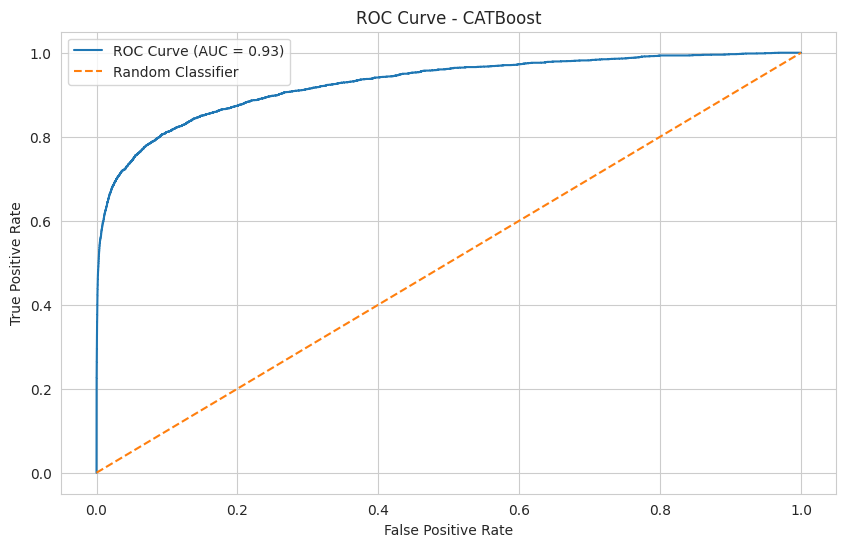

In [109]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred_model2_prob)
roc_auc = roc_auc_score(y_val, y_pred_model2_prob)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', label="Random Classifier")
plt.title("ROC Curve - CATBoost")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

The ROC curve (AUC = 0.91) indicates that CatBoost provides a solid level of class separation, maintaining a relatively high true positive rate with limited false positives across various thresholds. While this is slightly lower than the XGBoost score, it still demonstrates strong overall performance.


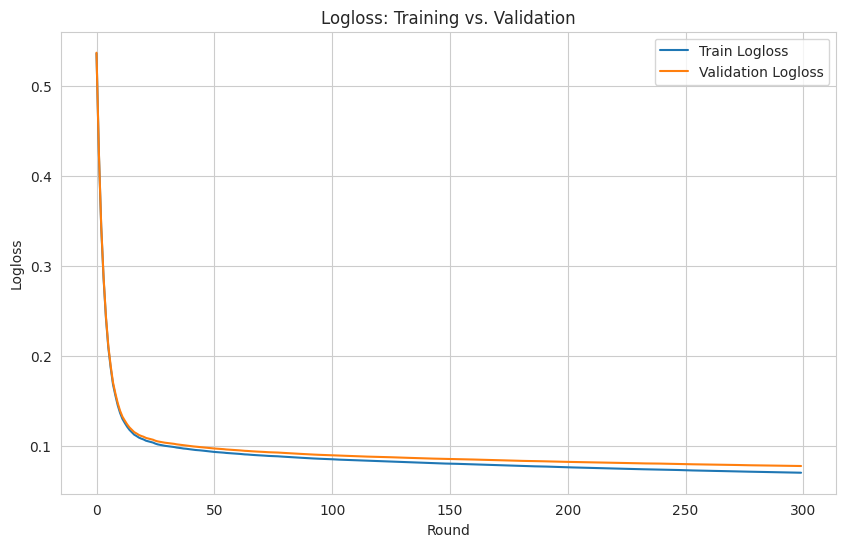

['CATBoost_final_model.pkl']

In [110]:
plt.figure()
plt.plot(train_logloss, label="Train Logloss")
plt.plot(val_logloss, label="Validation Logloss")
plt.title("Logloss: Training vs. Validation")
plt.xlabel("Round")
plt.ylabel("Logloss")
plt.legend()
plt.show()

joblib.dump(model_CAT_BOOST_NO_SMOTE, "CATBoost_final_model.pkl")

The logloss curve shows a rapid decrease during the first 50 rounds, indicating quick initial learning. Beyond that, both the training and validation curves remain close together, suggesting minimal overfitting. The continued, gradual decrease indicates consistent learning, with the model exhibiting stable performance across training and validation sets.

**No Overfitting**

### Preparing the test set

In [111]:
print("Loading test data...")

transaction_data_test = pd.read_csv('test_transaction.csv')
identity_data_test= pd.read_csv('test_identity.csv')
merged_data_test = pd.merge(transaction_data_test, identity_data_test, on='TransactionID', how='left')

print(f"train_transaction shape: {transaction_data_test.shape}")
print(f"train_identity shape: {identity_data_test.shape}")
print(f"Merged train_df shape: {merged_data_test.shape}\n")


Loading test data...
train_transaction shape: (506691, 393)
train_identity shape: (141907, 41)
Merged train_df shape: (506691, 433)



We will now apply all relevant preprocessing and feature engineering steps to the Kaggle test set in order to ensure it is fully aligned with our model’s requirements before generating final predictions.


In [112]:

# Function to prepare the data, receives a prepared dictionary
def preprocess_data(df, fraud_category_dict_p, fraud_category_dict_r):
    df = df.copy()

    df['Transaction_Hour'] = (df['TransactionDT'] // 3600) % 24
    df["Transaction_Hour"] = df["Transaction_Hour"].astype(str)

    df['Transaction_Weekday'] = ((df['TransactionDT'] // (24*3600)) % 7).astype(int)
    day_mapping = {0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday",
                   4: "Friday", 5: "Saturday", 6: "Sunday"}
    df['Transaction_Weekday'] = df['Transaction_Weekday'].map(day_mapping)

    df["LogTransactionAmt"] = np.log1p(df["TransactionAmt"])

    d_columns = [f'D{i}' for i in [2, 3, 10, 11, 15]]
    for col in d_columns:
        normalized_col = f'{col}new'
        df[normalized_col] = df[col] - df['TransactionDT'] / np.float32(24 * 60 * 60)

    df['all_4_is_nan'] = df.apply(lambda row: 1 if pd.isnull(row['card4']) \
                                              and pd.isnull(row['card6']) \
                                              and pd.isnull(row['DeviceType']) \
                                              and pd.isnull(row['DeviceInfo']) else 0, axis=1)

    df["AmountType"] = df["TransactionAmt"].apply(lambda x: "Whole" if x.is_integer() else "Decimal")

# Applying the mapping to the data
    df["fraud_category_P_email"] = df["P_emaildomain"].fillna("nan").map(fraud_category_dict_p)
    df["fraud_category_R_email"] = df["R_emaildomain"].fillna("nan").map(fraud_category_dict_r)

# If there are values ​​that are not in the dictionary, we will fill them in by default
    df["fraud_category_P_email"].fillna("0-1%", inplace=True)
    df["fraud_category_R_email"].fillna("0-1%", inplace=True)

# Transaction amount by card
    df['TransactionAmt_by_card1'] = df.groupby('card1')['TransactionAmt'].transform('sum')
    df['TransactionAmt_by_card2'] = df.groupby('card2')['TransactionAmt'].transform('sum')
    df['TransactionAmt_by_card3'] = df.groupby('card3')['TransactionAmt'].transform('sum')
    df['TransactionAmt_by_card5'] = df.groupby('card5')['TransactionAmt'].transform('sum')

# number of Transactions by card
    df['TransactionCount_by_card1'] = df.groupby('card1')['TransactionID'].transform('count')
    df['TransactionCount_by_card2'] = df.groupby('card2')['TransactionID'].transform('count')
    df['TransactionCount_by_card3'] = df.groupby('card3')['TransactionID'].transform('count')
    df['TransactionCount_by_card5'] = df.groupby('card5')['TransactionID'].transform('count')

#Transaction amount/number of transactions ratio by card
    df['AvgTransactionAmt_by_card1'] = df['TransactionAmt_by_card1'] / df['TransactionCount_by_card1']
    df['AvgTransactionAmt_by_card2'] = df['TransactionAmt_by_card2'] / df['TransactionCount_by_card2']
    df['AvgTransactionAmt_by_card3'] = df['TransactionAmt_by_card3'] / df['TransactionCount_by_card3']
    df['AvgTransactionAmt_by_card5'] = df['TransactionAmt_by_card5'] / df['TransactionCount_by_card5']


# Time difference between transactions for card
    df['TransactionDT_diff_by_card1'] = df.groupby('card1')['TransactionDT'].diff()
    df['TransactionDT_diff_by_card2'] = df.groupby('card2')['TransactionDT'].diff()
    df['TransactionDT_diff_by_card3'] = df.groupby('card3')['TransactionDT'].diff()
    df['TransactionDT_diff_by_card5'] = df.groupby('card5')['TransactionDT'].diff()


# New feature – the decimal part of the transaction amount
    df['TransactionAmt_decimal'] = df['TransactionAmt'] - np.floor(df['TransactionAmt'])


    return df

# Apply data processing to the test set (without isFraud)
test_df_processed = preprocess_data(merged_data_test, fraud_category_dict_p, fraud_category_dict_r)

# Categorial columns
ohe_columns = ["ProductCD", "card4", "card6", "M1", "M4", "M6", "Transaction_Weekday", "AmountType",
               "fraud_category_P_email", "fraud_category_R_email"]


# numeric columns for normalization
numeric_columns =  [
    'TransactionAmt', 'card1', 'card2', 'card3', 'card5', 'addr1', 'addr2', 'dist1',
    'C2', 'C3', 'C8', 'C9', 'C12', 'C13', 'D2', 'D3', 'D4', 'V1', 'V2', 'V3', 'V5',
    'V6', 'V7', 'V8', 'V9', 'V12', 'V20', 'V23', 'V24', 'V25', 'V26', 'V27', 'V35',
    'V38', 'V40', 'V41', 'V43', 'V45', 'V46', 'V47', 'V48', 'V52', 'V53', 'V55', 'V56',
    'V62', 'V66', 'V67', 'V72', 'V74', 'V75', 'V77', 'V78', 'V79', 'V81', 'V83', 'V86',
    'V87', 'V89', 'V93', 'V94', 'V98', 'V99', 'V107', 'V108', 'V109', 'V110', 'V111',
    'V112', 'V114', 'V115', 'V116', 'V117', 'V118', 'V120', 'V121', 'V122', 'V123',
    'V124', 'V125', 'V129', 'V130', 'V131', 'V135', 'V137', 'V281', 'V282', 'V283',
    'V284', 'V286', 'V287', 'V289', 'V290', 'V292', 'V293', 'V295', 'V296', 'V301',
    'V305', 'V308', 'V309', 'V310', 'V312', 'V314', 'V315', 'Transaction_Hour',
    'LogTransactionAmt', 'D2new', 'D3new', 'D10new', 'D11new', 'D15new', 'all_4_is_nan',
    'TransactionAmt_by_card1', 'TransactionAmt_by_card2', 'TransactionCount_by_card5',
    'AvgTransactionAmt_by_card1', 'AvgTransactionAmt_by_card2', 'AvgTransactionAmt_by_card3',
    'AvgTransactionAmt_by_card5', 'TransactionDT_diff_by_card1', 'TransactionDT_diff_by_card2',
    'TransactionDT_diff_by_card3', 'TransactionDT_diff_by_card5', 'TransactionAmt_decimal'
]

# create ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), ohe_columns)
    ]
)

# Create pipeline for processing data only
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])


<ipython-input-112-8d3762467448>:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["fraud_category_P_email"].fillna("0-1%", inplace=True)
<ipython-input-112-8d3762467448>:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tru

In [113]:
merged_data_reduced_columns = merged_data_reduced.drop('isFraud',axis=1)
test_df_processed = test_df_processed[merged_data_reduced_columns.columns]

In [114]:
categorical_columns = test_df_processed.select_dtypes(include=['object']).columns

# One-Hot Encoding by X_train columns
test_df_processed = pd.get_dummies(test_df_processed, columns=categorical_columns, drop_first=True)

missing_cols = set(X_train.columns) - set(test_df_processed.columns)

# Adding the missing columns with a value of 0 to fit the model
for col in missing_cols:
    test_df_processed[col] = 0

test_df_processed = test_df_processed[X_train.columns]
test_df_processed_main = test_df_processed

test_df_processed_scaled = scaler.transform(test_df_processed)


Now the test set is ready to our final models.

### Kaggle Submission

Model 1: XG Boost

In [115]:
y_pred_final_test = model_XG_BOOST_NO_SMOTE.predict_proba(test_df_processed_scaled)[:, 1]


submission_df = pd.DataFrame({
    "TransactionID": transaction_data_test.iloc[:,0] if transaction_data_test.ndim == 2 else transaction_data_test,  # Assuming transaction_data_test might be a DataFrame, take the first column
    "isFraud": y_pred_final_test
})

submission_df.to_csv("model_XG_BOOST_final.csv", index=False)

print("Submission file saved as submission.csv - Ready for Kaggle upload!")


Submission file saved as submission.csv - Ready for Kaggle upload!


Model 2: CAT Boost

In [116]:
y_pred_final_test = model_CAT_BOOST_NO_SMOTE.predict_proba(test_df_processed_scaled)[:, 1]

submission_df = pd.DataFrame({
    "TransactionID": transaction_data_test.iloc[:,0] if transaction_data_test.ndim == 2 else transaction_data_test,  # Assuming transaction_data_test might be a DataFrame, take the first column
    "isFraud": y_pred_final_test
})


submission_df.to_csv("model_CAT_BOOST_final.csv", index=False)

print("Submission file saved as submission.csv - Ready for Kaggle upload!")


Submission file saved as submission.csv - Ready for Kaggle upload!


Model 3: Ensemble XG Boost and CAT Boost

In [117]:

modelxg= joblib.load("XGboost_final_model.pkl")
modelcat= joblib.load("CATBoost_final_model.pkl")

# Creating an average between the models
y_pred_xgb = modelxg.predict_proba(test_df_processed_scaled)[:, 1]
y_pred_cat = modelcat.predict_proba(test_df_processed_scaled)[:, 1]

# forecasts Average
y_pred_ensemble = (y_pred_xgb + y_pred_cat) / 2


submission_df = pd.DataFrame({
    "TransactionID": transaction_data_test.iloc[:,0] if transaction_data_test.ndim == 2 else transaction_data_test,  # Assuming transaction_data_test might be a DataFrame, take the first column
    "isFraud": y_pred_ensemble
})

#3. Saving the file in the correct format
submission_df.to_csv("model_XGCAT_BOOST_final.csv", index=False)

Model 4:Ensemble XG Boost and CAT Boost Weighted

In [156]:

modelxg= joblib.load("XGboost_final_model.pkl")
modelcat= joblib.load("CATBoost_final_model.pkl")

# Creating an average between the models
y_pred_xgb = modelxg.predict_proba(test_df_processed_scaled)[:, 1]
y_pred_cat = modelcat.predict_proba(test_df_processed_scaled)[:, 1]

# forecasts Average
y_pred_ensemble = 0.1*y_pred_xgb + 0.9*y_pred_cat


submission_df = pd.DataFrame({
    "TransactionID": transaction_data_test.iloc[:,0] if transaction_data_test.ndim == 2 else transaction_data_test,  # Assuming transaction_data_test might be a DataFrame, take the first column
    "isFraud": y_pred_ensemble
})

#3. Saving the file in the correct format
submission_df.to_csv("XGCAT_BOOST_final_weighted.csv", index=False)

Downloading...
From: https://drive.google.com/uc?id=1E71Z-l_avJ6f92RZjdW1kfk279aiI4eN
To: /content/downloaded_image.jpg
100%|██████████| 113k/113k [00:00<00:00, 46.1MB/s]


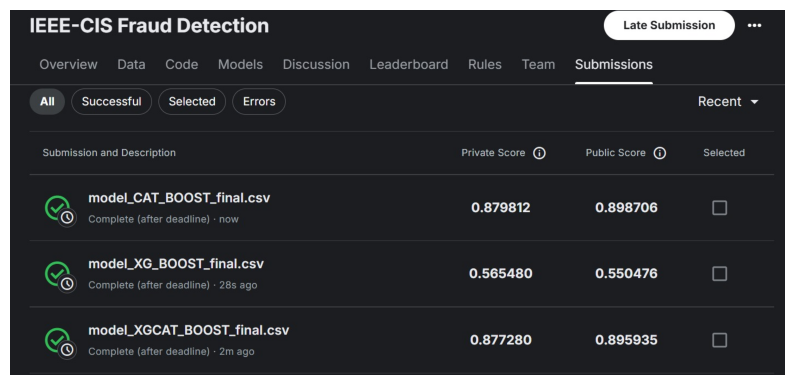

In [118]:

file_id = "1E71Z-l_avJ6f92RZjdW1kfk279aiI4eN"
output = "downloaded_image.jpg"

gdown.download(f"https://drive.google.com/uc?id={file_id}", output, quiet=False)

image = cv2.imread(output)
if image is None:
    print("Error: Unable to read image. Check the file path.")
else:
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
